In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import sys
import math
from mpl_toolkits import mplot3d
import seaborn as sns

from matplotlib import rc
import pandas as pd
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
import itertools
from itertools import accumulate

from bayes_opt import BayesianOptimization
from bayes_opt.util import load_logs
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events
from sklearn.metrics import mean_squared_error


import subprocess
import sys
import os

import time

from multiprocessing import Pool
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
with open('death_croatia_31_12_19_04') as my_file:
    death_croatia = my_file.read().splitlines()
death_croatia_int = list(map(int, death_croatia))

with open('Stringency_index_croatia_31_12_19_04') as my_file:
    stringency = my_file.read().splitlines()
stringency_croatia_float = list(map(float, stringency))

def moving_avg(mylis,N):
    cumsum, moving_aves = [0], []
    mylist=mylis.copy()
    for i in range(N-1):
        mylist.insert(0,mylist[0])
    for i, x in enumerate(mylist, 1):
        cumsum.append(cumsum[i-1] + x)
        if i>=N:
            moving_ave = (cumsum[i] - cumsum[i-N])/N
            #can do stuff with moving_ave here
            moving_aves.append(moving_ave)
    return moving_aves

In [3]:
def model_cluster_trip(config_file_name, seed, devnull):
    if sys.version_info > (3, 0):
        return subprocess.run(["./model_cluster_trip_v2", config_file_name, str(seed)],
                stdout=subprocess.PIPE, stderr=devnull).stdout
    else:
        p = subprocess.Popen(["./model_cluster_trip_v2", config_file_name, str(seed)],
                stdout=subprocess.PIPE, stderr=devnull)
        return "".join(p.stdout.readlines())

def graph_generation(baseline_icu,baseline_nodes,baseline_days,scale,scaledays,ext,cluster_size,mu,k,r,extpop
                     ,stringency,oduzeti_dani,var_koef,inf_icu_rate,new_day):
    num_icus=int(baseline_icu/scale)#200 baseline
    num_days=int(baseline_days/scaledays) #1200 baseline, we want most, even controlled pandemic to end.
    
    if ext==0 or ext==4 or ext==5:
        if ext==0:
            with open("config_for_grid_search.json") as f:
                config = json.load(f)
        if ext==4:
            #"config_for_croatia.json"
            #"config_for_croatia:default.json"
            with open("config_for_croatia_default.json") as f:
                config = json.load(f)
        if ext==5:
            #"config_for_croatia.json"
            #"config_for_croatia:default.json"
            with open("config_for_croatia_default_range_death.json") as f:
                config = json.load(f)
                
        num_nodes=int(baseline_nodes/scale)#1,000,000 baseline
        num_clusters=int(num_nodes/cluster_size)

        config["graph_generation"][0]["num_people_per_cluster"]=cluster_size
        config["graph_generation"][0]["num_clusters"]=num_clusters
        
    if ext==1 or ext==2: # superspreaders model and/or domovi model
        if ext==1:
            with open("config_for_grid_search_superspreaders.json") as f:
                config = json.load(f)
        if ext==2:
            with open("config_for_grid_search_domovi.json") as f:
                config = json.load(f)

        num_nodes0=int((baseline_nodes-extpop)/scale)#1,000,000 baseline
        num_clusters0=int(num_nodes0/cluster_size)

        num_nodes1=int(extpop/scale)
        num_clusters1=int(num_nodes1/cluster_size)

        config["graph_generation"][0]["num_people_per_cluster"]=cluster_size
        config["graph_generation"][0]["num_clusters"]=num_clusters0

        config["graph_generation"][1]["num_people_per_cluster"]=cluster_size
        config["graph_generation"][1]["num_clusters"]=num_clusters1
        
        a=config["graph_generation"][0]["category_ratios"][0]
        b=config["graph_generation"][0]["category_ratios"][1]
        
        if ext==1:
            config["graph_generation"][0]["category_ratios"][0]=int(max(baseline_nodes*(a/(a+b))/scale-num_nodes1,0))
            # diminish <60 because some are superspreaders
            config["graph_generation"][0]["category_ratios"][1]=int(max(baseline_nodes*(b/(a+b))/scale,0))
        if ext==2:
            config["graph_generation"][0]["category_ratios"][0]=int(max(baseline_nodes*(a/(a+b))/scale,0)) 
            config["graph_generation"][0]["category_ratios"][1]=int(max(baseline_nodes*(b/(a+b))/scale-num_nodes1,0)) 
            # diminish >=60 because some are in domovi
            
    config["simulation"]["stopping_conditions"]["num_days"]=num_days
    config["simulation"]["num_icus"]=num_icus
    config["simulation"]["mu"] = mu
    config["simulation"]["k_trip"] = k
    config["simulation"]["prob_transmission"] = r
    if ext==5:
        config["simulation"]["initial_params"][0]["prob_i_to_ic"] = inf_icu_rate
    
    # TU MIJENJAMO CUSTOM EVENTE ZA HRVATSKU.
    if ext==4 or ext==5:
        i=0
        #pocetak_korone=40 
        pocetak_korone=max(0,51 - oduzeti_dani)
        pocetak_ljeta=-1
        kraj_ljeta=-1
        #pocetak_ljeta=max(1,174 - oduzeti_dani)
        #kraj_ljeta=max(2,268 - oduzeti_dani)

        #pocetak_variranja=100
        stringency_var=[]
        #j=0
        for index in stringency:
            #if j>new_day:
            #    stringency_var.append(var_koef*index)
            #else:    
            stringency_var.append(index)
            #j+=1
        for index in stringency_var:
            if i==pocetak_korone:
                event={'label': 'str_index_'+str(i),'day': i,'update_params': {
                                                                    'prob_goes_on_trip': [1-index/100, 1-index/100],
                                                                    #'prob_s_to_i': [5e-07, 5e-07]}}
                                                                    'prob_s_to_i': [2.5e-07, 2.5e-07]}}
            elif i==pocetak_ljeta:
                event={'label': 'str_index_'+str(i),'day': i,'update_params': {
                                                                    'prob_goes_on_trip': [1-index/100, 1-index/100],
                                                                    "prob_i_to_ic" : [0.002,0.05]}}
                                                                            #[0.002,0.05]
                                                                            #[0.0005,0.0012]
            elif i==kraj_ljeta:
                event={'label': 'str_index_'+str(i),'day': i,'update_params': {
                                                                    'prob_goes_on_trip': [1-index/100, 1-index/100],
                                                                    "prob_i_to_ic" : [0.00471,0.11285]}}
                                                                            #[0.00471,0.11285]
                                                                            #[0.00236,0.05643]
                                                                            #[0.00117,0.02821]
            elif i<new_day:
                event={'label': 'str_index_'+str(i),'day': i,'update_params': {
                                                                    'prob_goes_on_trip': [1-index/100, 1-index/100]}}
            else:
                event={'label': 'str_index_'+str(i),'day': i,'update_params': {
                                                'prob_goes_on_trip': [var_koef*(1-index/100), var_koef*(1-index/100)]}}
            config['simulation']['events'].append(event)
            i+=1
    return config

def grid_search_parameters(config,p1,p2,ext,k,mu,cluster_size,seed,new_p2,new_day):
    config["simulation"]["initial_params"][0]["prob_goes_on_trip"] = p1
    config["simulation"]["initial_params"][1]["prob_goes_on_trip"] = p1
    config["simulation"]["initial_params"][0]["prob_c_neighbour_trip_candidate"] = p2
    config["simulation"]["initial_params"][1]["prob_c_neighbour_trip_candidate"] = p2
    
    event={'label': 'str_index_p2_'+str(new_day),'day': int(new_day),'update_params': {
                                                    "prob_c_neighbour_trip_candidate": [new_p2, new_p2]}}
    config['simulation']['events'].append(event)
    
    if ext==0 or ext==4:
        config_file_name = "tmp/Base_tmp_config_rgs{}_{}_{}_{}.json".format(
            k, mu, cluster_size, seed)
    if ext==1:
        config_file_name = "tmp/Superspreaders_tmp_config_rgs{}_{}_{}_{}_extpop{}.json".format(
                k, mu, cluster_size, seed, extpop)
    if ext==2:
        # >=60 in domovi 10 times more likely to be in quarantine and 10 times more likely not to go on trip.
        config["simulation"]["initial_params"][2]["prob_goes_on_trip"] = p1/10 
        config["simulation"]["initial_params"][2]["prob_c_neighbour_trip_candidate"] = p2/10

        config_file_name = "tmp/Domovi_tmp_config_rgs{}_{}_{}_{}_extpop{}.json".format(
                k, mu, cluster_size, seed, extpop)
    return [config, config_file_name]



In [4]:
# 1 na rubu sa ulazom u overload na 100-200 dana
#p1=0.4; p2=0.65; ext=0; extpop=0; k=2.5; mu=5; cluster_size=4; seed=0;

# 2 katastrofalni primjer 1
#p1=0.8; p2=0.8; ext=0; extpop=0; k=2.5; mu=5; cluster_size=4; seed=0;

# katastrofalni primjer 2
# p1=0.6; p2=0.6; ext=0; extpop=0; k=2.5; mu=5; cluster_size=4; seed=0;

# 4 primjer gdje superspreaderi uzrokuju oscilacije
#p1=0.2; p2=0.1; ext=1; extpop=2000; k=2.5; mu=5; cluster_size=8; seed=0;

# 5 primjer gdhe superspreaderi bace u overload.
#p1=0.2; p2=0.2; ext=1; extpop=2000; k=2.5; mu=5; cluster_size=8; seed=0;

# 3 primjer domovi gdje bez failanja sustava dobijemo immunity od oko 20% u nekoliko stotina dana
#p1=0.78; p2=1; ext=2; extpop=280000; k=2.5; mu=5; cluster_size=2; seed=0;

#Za relativno dobar prediction
#p1=0.7; p2=0.47; ext=4; extpop=0; k=2.5; mu=5; cluster_size=3; seed=0; r=0.1

#jako precizno za kompletni prediction sa smortnosti 1% i oduzeto 35, stay in icu 10., beginning pandemic 40 days.
#p1=1; p2=0.09; ext=4; extpop=0; k=2.5; mu=5; cluster_size=3; seed=0; r=0.1

#jako precizno za kompletni prediction sa smortnosti 1% i oduzeto 35, stay in icu 20., beginning pandemic 50 days.
#p1=1; p2=0.07; ext=4; extpop=0; k=2.5; mu=5; cluster_size=3; seed=0; r=0.1

#jako precizno za prediction sa smrtnosti 1% i oduzeto 190
#p1=1; p2=0.18; ext=4; extpop=0; k=2.5; mu=5; cluster_size=3; seed=0; r=0.1

#smortnost 1% i oduzeto 0, broj dana 150
#p1=1; p2=0.5; ext=4; extpop=0; k=2.5; mu=5; cluster_size=3; seed=0; r=0.1

def simulation(scale,num_icu,number_people,days,oduzeto,scaledays,p1,p2,ext,extpop,k,mu,cluster_size,seed,
               r,coef,type_ext,inf_icu_rate,new_p2,new_day):

    config=graph_generation(num_icu,number_people,days-oduzeto,scale,scaledays,ext,cluster_size,mu,k,r,extpop,
                            stringency_croatia_float[oduzeto:],oduzeto,coef,inf_icu_rate,new_day)
    if ext==4 or ext==5:
        ext=0


    devnull = open(os.devnull, 'w')
    
    config_list=grid_search_parameters(config,p1,p2,ext,k,mu,cluster_size,seed,new_p2,new_day) #dodane varijable new
    #vezane za promjenu od p2 kroz vrijeme
    config=config_list[0]
    config_file_name=config_list[1]
    #print(config)

    with open(config_file_name, "w") as f:
        json.dump(config, f, indent=4)

    print("Running model with params: cluster_size = {:.3f}".format(cluster_size),
          ", prob_goes_on_trip = {:.3f}".format(p1),
          ", prob_c_neighbour_trip_candidate = {:.3f}".format(p2),
          "seed = {}".format(seed), file=sys.stderr)
    stdout = model_cluster_trip(config_file_name, seed, devnull)

    output=json.loads(stdout)
    os.remove(config_file_name)
    devnull.close()

    data1=output

    # "mild" is better name than "confirmed" since people in "icu" state are also
    # confirmed cases in the real world
    data=data1["stats"]
    data["mild"] = data["confirmed"]
    del data["confirmed"]
    data["dead covid19"] = data["dead"]
    del data["dead"]
    data["icu covid19"] = data["icu"]
    del data["icu"]
    data["dead nocovid19"] = data["nocorona_dead"]
    del data["nocorona_dead"]
    data["icu nocovid19"] = data['nocorona_icu']
    del data['nocorona_icu']
    data["recovered"] = data['immune']
    del data['immune']
    data["infected"] = data['infectious']
    del data['infectious']
    
    return data

In [5]:
def colorplot(state):
    if state=="dead covid19":
        return "purple"
    if state=="dead nocovid19":
        return "black"
    if state=="icu covid19":
        return "chocolate"
    if state=="icu nocovid19":
        return "grey"
    if state=="infected":
        return "tomato"
    if state=="mild":
        return "darkorange"
    if state=="recovered":
        return "limegreen"
    if state=="susceptible":
        return "blue"

    
def time_series_plot_infected(data,cluster_dim,p1,p2,k,mu,r,type_ext,save,extpop,death_croatia,N,shade,oduzeto
                      ,coef_var,num_icu,odrezi):
    
    if type_ext=="base" or type_ext=="croatia":
        title_plot="" 
    else:
        title_plot=(type_ext.capitalize()  + " Model, Cluster size = {}".format(cluster_dim) + 
                    ", P1 = {}".format(p1) +
                    ", P2 = {}".format(p2) + 
                    ", S. pop. = {}%".format(extpop/10000)) 
    
    file_title=("bayes100it"+ type_ext.capitalize() + " Model " 
                + ", Cluster size".format(cluster_dim)
                + ", K = {}".format(k)
                + ', MU = {}'.format(mu)
                + ", Special pop = {}".format(extpop)
                + ", p1 = {}".format(p1)
                + ", p2 = {}".format(p2)
                + ", r = {}".format(r)
                + ", N = {}".format(N)
                + ", shade = {}".format(shade)
                + ", oduzeto = {}".format(oduzeto)
                + ", coef_var = {}".format(coef_var)
                + ", icu = {}".format(num_icu)
                + ", double_data_plot_outputvar") 
    sx=2
    sy=1
    fig, ax = plt.subplots(nrows=sx,ncols=sy, sharex=False, sharey=False,figsize=(16, 12))
    fig.subplots_adjust(left=0.07, bottom=0.13, right=0.95, top=0.99, wspace=0.1,hspace = 0.05)
    fig.suptitle(title_plot,fontsize=24)

    #'inferno'
    #'rainbow'
    #'num_able_people_with_cluster_corona''num_people_on_trip_with_cluster_corona''num_people_on_trip'
    data1={}
    if odrezi>0:
        for state in data:
            data1[state]=data[state][:-odrezi]
            if (state=="dead nocovid19" or state=="icu nocovid19" or state=='num_able_people_with_cluster_corona' 
                or state=='num_people_on_trip_with_cluster_corona' or state=='num_people_on_trip'):
                del data1[state]
        data=data1
        death_croatia=death_croatia[:-odrezi]
    
    ax[0].set_ylabel('Number of people',fontsize=24)
    ax[0].tick_params(size=10)
    for state in data:
        ax[0].plot(np.arange(len(moving_avg(data[state],N))), moving_avg(data[state],N),
                    label=state,color=colorplot(state)) 
    january=31 - oduzeto
    february=january + 29
    march=february + 31
    april=march + 30
    may=april+31
    june=may+30
    july=june+31
    august=july+31
    september=august+30
    october=september+31
    november=october+30
    december=november+31
    january21=december+31
    february21=january21+28
    march21=february21+31
    april21=march21+30
    months_end=[january,february,march,april,may,june,july,august,september,october,november,december,
               january21,february21,march21,april21]
    labels=["31.01.2020","29.02.2020","31.03.2020","30.04.2020","31.05.2020","30.06.2020",
            "31.07.2020","31.08.2020","30.09.2020","31.10.2020","30.11.2020","31.12.2020",
            "31.01.2021","28.02.2021","31.03.2021","30.04.2021"]
    ax[0].set_xticks(months_end, minor=False)
    ax[0].tick_params(labelsize=15,size=10)
    ax[0].set_xticklabels(months_end, fontdict=None, minor=False,rotation=60,fontsize=1)
    
    #ax[0].xticks( months_end, calendar.month_name[1:13], rotation=17 )

    #for state in data:
    #    ax[0].plot(np.arange(len(data[state])), data[state],
    #                 label=state,color=colorplot(state))
        
    #ax[0].set_title("Logarithmic Plot",fontsize=20)
    ax[0].legend(bbox_to_anchor=(0.20, 0.95),loc='upper right',fontsize=15)
    ax[0].set_yscale("log")
    ax[0].grid(color='black',axis='y' ,which='major',linestyle='-', linewidth=0.5)
    #ax[0,1].grid(color='grey', which='minor',linestyle='--', linewidth=0.05)
    
    width=1
    ax[1].set_ylabel('Number of people',fontsize=24)            
    #ax[1].set_title("Deaths per day",fontsize=20)
    #diffdead=[t - s for s, t in zip(data['dead covid19'], data['dead covid19'][1:])]
    diffdead=[(a-b)-(c-d) for a,b,c,d in zip(data['infected'],data['infected'][5:],
                                             data['infected'][1:],data['infected'][6:])]
    #diffnocoronadead=[t - s for s, t in zip(data['dead nocovid19'], data['dead nocovid19'][1:])]
    
    predicted=moving_avg(diffdead,N)
    real=moving_avg(death_croatia,N)
    
    predicted_donji_ = [math.floor(element * 0.5) for element in predicted]
    predicted_gornji_ = [math.ceil(element * 2) for element in predicted]
    
    #predicted_donji = interp1d(np.arange(len(predicted_donji_)), predicted_donji_, kind='cubic')
    #predicted_gornji = interp1d(np.arange(len(predicted_gornji_)), predicted_gornji_, kind='cubic')
    predicted_donji = savgol_filter(predicted_donji_, 51, 3)
    predicted_gornji = savgol_filter(predicted_gornji_, 51, 3)
    
    if shade == False:
        item2=plt.bar(np.arange(len(predicted)), predicted,width=width,color="chocolate")
        #item1,=plt.plot(np.arange(len(moving_avg(death_croatia,7))), moving_avg(death_croatia,7))
        item1,=plt.plot(real,color="blue",linewidth=1)
        ax[1].legend([item1 ,item2], ['real dead covid19','simulated dead covid19'],fontsize=15)
        #ax[1].set_xlabel('Days',fontsize=20)
    if shade == True:
        item2,=plt.plot(predicted_donji,color="chocolate")
        item3,=plt.plot(predicted_gornji,color="chocolate")
        item1,=plt.plot(real,color="blue")
        plt.fill_between(np.arange(len(predicted_donji)), predicted_donji, 
                                predicted_gornji,where=predicted_gornji > predicted_donji,color="navajowhite")
        ax[1].legend([item1 ,item2 , item3], ['real dead covid19','predicted dead covid19_Lbound'
                                              ,'predicted dead covid19_Ubound' ],fontsize=15)
        ax[1].set_xlabel('Days',fontsize=20)
    ax[1].tick_params(labelsize=15,size=10)
    ax[1].set_xticks(months_end, minor=False)
    ax[1].set_xticklabels(labels, fontdict=None, minor=False,fontsize=18,rotation=60)
    ax[1].grid(color='black',axis='y' ,which='major',linestyle='-', linewidth=0.5)
    
    ax[1].axvline(february,color="black",linewidth=1,linestyle='--')
    ax[1].axvline(april,color="black",linewidth=1,linestyle='--')
    ax[1].axvline(june,color="black",linewidth=1,linestyle='--')
    ax[1].axvline(august,color="black",linewidth=1,linestyle='--')
    ax[1].axvline(october,color="black",linewidth=1,linestyle='--')
    ax[1].axvline(december,color="black",linewidth=1,linestyle='--')
    ax[1].axvline(february21,color="black",linewidth=1,linestyle='--')


    if save==True:            
        plt.savefig("outputsBilj/prediction_croatia_final/"+ file_title + '.png')
        plt.close(fig)

    

def time_series_plot2(data,cluster_dim,p1,p2,k,mu,r,type_ext,save,extpop,death_croatia,N,shade,oduzeto
                      ,coef_var,num_icu,odrezi):
    
    if type_ext=="base" or type_ext=="croatia":
        title_plot="" 
    else:
        title_plot=(type_ext.capitalize()  + " Model, Cluster size = {}".format(cluster_dim) + 
                    ", P1 = {}".format(p1) +
                    ", P2 = {}".format(p2) + 
                    ", S. pop. = {}%".format(extpop/10000)) 
    
    file_title=("bayes100it"+ type_ext.capitalize() + " Model " 
                + ", Cluster size".format(cluster_dim)
                + ", K = {}".format(k)
                + ', MU = {}'.format(mu)
                + ", Special pop = {}".format(extpop)
                + ", p1 = {}".format(p1)
                + ", p2 = {}".format(p2)
                + ", r = {}".format(r)
                + ", N = {}".format(N)
                + ", shade = {}".format(shade)
                + ", oduzeto = {}".format(oduzeto)
                + ", coef_var = {}".format(coef_var)
                + ", icu = {}".format(num_icu)
                + ", double_data_plot_outputvar") 
    sx=2
    sy=1
    fig, ax = plt.subplots(nrows=sx,ncols=sy, sharex=False, sharey=False,figsize=(16, 12))
    fig.subplots_adjust(left=0.07, bottom=0.13, right=0.95, top=0.99, wspace=0.1,hspace = 0.05)
    fig.suptitle(title_plot,fontsize=24)

    #'inferno'
    #'rainbow'
    #'num_able_people_with_cluster_corona''num_people_on_trip_with_cluster_corona''num_people_on_trip'
    data1={}
    if odrezi>0:
        for state in data:
            data1[state]=data[state][:-odrezi]
            if (state=="dead nocovid19" or state=="icu nocovid19" or state=='num_able_people_with_cluster_corona' 
                or state=='num_people_on_trip_with_cluster_corona' or state=='num_people_on_trip'):
                del data1[state]
        data=data1
        death_croatia=death_croatia[:-odrezi]
    
    ax[0].set_ylabel('Number of people',fontsize=24)
    ax[0].tick_params(size=10)
    for state in data:
        ax[0].plot(np.arange(len(moving_avg(data[state],N))), moving_avg(data[state],N),
                    label=state,color=colorplot(state)) 
    january=31 - oduzeto
    february=january + 29
    march=february + 31
    april=march + 30
    may=april+31
    june=may+30
    july=june+31
    august=july+31
    september=august+30
    october=september+31
    november=october+30
    december=november+31
    january21=december+31
    february21=january21+28
    march21=february21+31
    april21=march21+30
    months_end=[january,february,march,april,may,june,july,august,september,october,november,december,
               january21,february21,march21,april21]
    labels=["31.01.2020","29.02.2020","31.03.2020","30.04.2020","31.05.2020","30.06.2020",
            "31.07.2020","31.08.2020","30.09.2020","31.10.2020","30.11.2020","31.12.2020",
            "31.01.2021","28.02.2021","31.03.2021","30.04.2021"]
    ax[0].set_xticks(months_end, minor=False)
    ax[0].tick_params(labelsize=15,size=10)
    ax[0].set_xticklabels(months_end, fontdict=None, minor=False,rotation=60,fontsize=1)
    
    #ax[0].xticks( months_end, calendar.month_name[1:13], rotation=17 )

    #for state in data:
    #    ax[0].plot(np.arange(len(data[state])), data[state],
    #                 label=state,color=colorplot(state))
        
    #ax[0].set_title("Logarithmic Plot",fontsize=20)
    ax[0].legend(bbox_to_anchor=(0.20, 0.95),loc='upper right',fontsize=15)
    ax[0].set_yscale("log")
    ax[0].grid(color='black',axis='y' ,which='major',linestyle='-', linewidth=0.5)
    #ax[0,1].grid(color='grey', which='minor',linestyle='--', linewidth=0.05)
    
    width=1
    ax[1].set_ylabel('Number of people',fontsize=24)            
    #ax[1].set_title("Deaths per day",fontsize=20)
    diffdead=[t - s for s, t in zip(data['dead covid19'], data['dead covid19'][1:])]
    #diffnocoronadead=[t - s for s, t in zip(data['dead nocovid19'], data['dead nocovid19'][1:])]
    
    predicted=moving_avg(diffdead,N)
    real=moving_avg(death_croatia,N)
    
    predicted_donji_ = [math.floor(element * 0.5) for element in predicted]
    predicted_gornji_ = [math.ceil(element * 2) for element in predicted]
    
    #predicted_donji = interp1d(np.arange(len(predicted_donji_)), predicted_donji_, kind='cubic')
    #predicted_gornji = interp1d(np.arange(len(predicted_gornji_)), predicted_gornji_, kind='cubic')
    predicted_donji = savgol_filter(predicted_donji_, 51, 3)
    predicted_gornji = savgol_filter(predicted_gornji_, 51, 3)
    
    if shade == False:
        item2=plt.bar(np.arange(len(predicted)), predicted,width=width,color="chocolate")
        #item1,=plt.plot(np.arange(len(moving_avg(death_croatia,7))), moving_avg(death_croatia,7))
        item1,=plt.plot(real,color="blue",linewidth=1)
        ax[1].legend([item1 ,item2], ['real dead covid19','simulated dead covid19'],fontsize=15)
        #ax[1].set_xlabel('Days',fontsize=20)
    if shade == True:
        item2,=plt.plot(predicted_donji,color="chocolate")
        item3,=plt.plot(predicted_gornji,color="chocolate")
        item1,=plt.plot(real,color="blue")
        plt.fill_between(np.arange(len(predicted_donji)), predicted_donji, 
                                predicted_gornji,where=predicted_gornji > predicted_donji,color="navajowhite")
        ax[1].legend([item1 ,item2 , item3], ['real dead covid19','predicted dead covid19_Lbound'
                                              ,'predicted dead covid19_Ubound' ],fontsize=15)
        ax[1].set_xlabel('Days',fontsize=20)
    ax[1].tick_params(labelsize=15,size=10)
    ax[1].set_xticks(months_end, minor=False)
    ax[1].set_xticklabels(labels, fontdict=None, minor=False,fontsize=18,rotation=60)
    ax[1].grid(color='black',axis='y' ,which='major',linestyle='-', linewidth=0.5)
    
    ax[1].axvline(february,color="black",linewidth=1,linestyle='--')
    ax[1].axvline(april,color="black",linewidth=1,linestyle='--')
    ax[1].axvline(june,color="black",linewidth=1,linestyle='--')
    ax[1].axvline(august,color="black",linewidth=1,linestyle='--')
    ax[1].axvline(october,color="black",linewidth=1,linestyle='--')
    ax[1].axvline(december,color="black",linewidth=1,linestyle='--')
    ax[1].axvline(february21,color="black",linewidth=1,linestyle='--')


    if save==True:            
        plt.savefig("outputsBilj/prediction_croatia_final/"+ file_title + '.png')
        plt.close(fig)

        
def time_series_plot_p1(data,save):
    
    file_title=("p1s") 
    figure = plt.gcf() # get current figure
    figure.set_size_inches(16, 6)

    january=31
    february=january + 29
    march=february + 31
    april=march + 30
    may=april+31
    june=may+30
    july=june+31
    august=july+31
    oduzeto2=august
    september=august+30
    october=september+31
    november=october+30
    december=november+31
    january21=december+31
    february21=january21+28
    march21=february21+31
    april21=march21+30
    #months_end=[0,january,february,march,april,may,june,july,august,september,october,november,december,
    #           january21,february21,march21]
    months_end=[0,february,april,june,august,october,december,
               february21]
    labels=["31.12.2019","29.02.2020","30.04.2020","30.06.2020",
            "31.08.2020","31.10.2020","31.12.2020",
            "28.02.2021"]
    #labels=["31.12.2019","31.01.2020","29.02.2020","31.03.2020","30.04.2020","31.05.2020","30.06.2020","31.07.2020",
    #        "31.08.2020","30.09.2020","31.10.2020","30.11.2020","31.12.2020",
    #        "31.01.2021","28.02.2021","31.03.2021"]
    plt.yticks(fontsize=20)
    plt.ylabel('Probability of mobility p1',fontsize=24)
    plt.xticks(ticks=months_end,labels=labels,rotation=60,fontsize=19)

    dday=len(data)-19-31-20
    p1s=[]
    p12s=[]
    j=0
    for index in data:
                #if j>new_day:
                #    stringency_var.append(var_koef*index)
                #else:
                if j<dday:
                    p1s.append(1-index/100)
                else:
                    p1s.append(1.4*(1-index/100))
                j+=1
                p12s.append(1-index/100)
    plt.plot(np.arange(len(p1s[:-3])),p1s[:-3],color="red",linestyle="--",linewidth=2)
    plt.plot(np.arange(len(p12s[:-3])),p12s[:-3],color="blue",linewidth=2)
    plt.legend(fontsize=18)
    plt.ylim([0, 1.01])
    plt.xlim([0, len(p1s[:-3])])
    #ax[1].set_xlabel('Days',fontsize=20)
    lwidt=0.5
    plt.grid(color='black',axis='y' ,which='major',linestyle='--', linewidth=lwidt)
    plt.axvline(0,color="black",linewidth=lwidt,linestyle='--')
    plt.axvline(february,color="black",linewidth=lwidt,linestyle='--')
    plt.axvline(april,color="black",linewidth=lwidt,linestyle='--')
    plt.axvline(june,color="black",linewidth=lwidt,linestyle='--')
    plt.axvline(august,color="black",linewidth=lwidt,linestyle='--')
    plt.axvline(october,color="black",linewidth=lwidt,linestyle='--')
    plt.axvline(december,color="black",linewidth=lwidt,linestyle='--')
    plt.axvline(february21,color="black",linewidth=lwidt,linestyle='--')
    #plt.axvline(march21,color="black",linewidth=1,linestyle='--')


    if save==True:            
        plt.savefig("outputsBilj/paper images/"+ file_title + '.png',bbox_inches = 'tight')
        plt.close(figure)

        
def time_series_plot2_2(data,data2,data3,cluster_dim,p1,p2,k,mu,r,type_ext,save,extpop,death_croatia,N,shade,oduzeto
                      ,coef_var,num_icu,odrezi):
    if type_ext=="base" or type_ext=="croatia":
        title_plot="" 
    else:
        title_plot=(type_ext.capitalize()  + " Model, Cluster size = {}".format(cluster_dim) + 
                    ", P1 = {}".format(p1) +
                    ", P2 = {}".format(p2) + 
                    ", S. pop. = {}%".format(extpop/10000)) 
    
    file_title=("bayes100it"+ type_ext.capitalize() + " Model " 
                + ", Cluster size".format(cluster_dim)
                + ", K = {}".format(k)
                + ', MU = {}'.format(mu)
                + ", Special pop = {}".format(extpop)
                + ", p1 = {}".format(p1)
                + ", p2 = {}".format(p2)
                + ", r = {}".format(r)
                + ", N = {}".format(N)
                + ", shade = {}".format(shade)
                + ", oduzeto = {}".format(oduzeto)
                + ", coef_var = {}".format(coef_var)
                + ", icu = {}".format(num_icu)
                + ", double_data_plot_outputvar") 
    figure = plt.gcf() # get current figure
    figure.set_size_inches(16, 12)

    data1={}
    if odrezi>0:
        for state in data:
            data1[state]=data[state][:-odrezi]
            if state=="dead nocovid19" or state=="icu nocovid19":
                del data1[state]
        data=data1
    data1={}
    if odrezi>0:
        for state in data2:
            data1[state]=data2[state][:-odrezi]
            if state=="dead nocovid19" or state=="icu nocovid19":
                del data1[state]
        data2=data1
    data1={}
    if odrezi>0:
        for state in data3:
            data1[state]=data3[state][:-odrezi]
            if state=="dead nocovid19" or state=="icu nocovid19":
                del data1[state]
        data3=data1
        death_croatia=death_croatia[:-odrezi]

    january=31 - oduzetoplt
    february=january + 29
    march=february + 31
    april=march + 30
    may=april+31
    june=may+30
    july=june+31
    august=july+31
    oduzeto2=august
    september=august+30-oduzeto2
    october=september+31
    november=october+30
    december=november+31
    january21=december+31
    february21=january21+28
    march21=february21+31
    april21=march21+30
    months_end=[0,september,october,november,december,
               january21,february21,march21,april21]
    labels=["31.08.2020","30.09.2020","31.10.2020","30.11.2020","31.12.2020",
            "31.01.2021","28.02.2021","31.03.2021","30.04.2021"]
    plt.yticks(fontsize=20)
    plt.ylabel('Number of people',fontsize=24)
    plt.xticks(ticks=months_end,labels=labels,rotation=60,fontsize=20)

    width=1
    diffdead=[t - s for s, t in zip(data['dead covid19'], data['dead covid19'][1:])]
    diffdead2=[t - s for s, t in zip(data2['dead covid19'], data2['dead covid19'][1:])]
    diffdead3=[t - s for s, t in zip(data3['dead covid19'], data3['dead covid19'][1:])]
    #diffnocoronadead=[t - s for s, t in zip(data['dead nocovid19'], data['dead nocovid19'][1:])]
    
    predicted=moving_avg(diffdead,N)
    predicted2=moving_avg(diffdead2,N)
    predicted3=moving_avg(diffdead3,N)
    real=moving_avg(death_croatia,N)
    
    predicted2=[0]*(january21+28)+predicted2[(oduzeto2+january21+28):]
    predicted3=[0]*(january21+28)+predicted3[(oduzeto2+january21+28):]
    
    predicted_donji_ = [math.floor(element * 0.5) for element in predicted]
    predicted_gornji_ = [math.ceil(element * 2) for element in predicted]
    
    #predicted_donji = interp1d(np.arange(len(predicted_donji_)), predicted_donji_, kind='cubic')
    #predicted_gornji = interp1d(np.arange(len(predicted_gornji_)), predicted_gornji_, kind='cubic')
    predicted_donji = savgol_filter(predicted_donji_, 51, 3)
    predicted_gornji = savgol_filter(predicted_gornji_, 51, 3)
    
    if shade == False:
        item6=plt.bar(np.arange(len(predicted3)),predicted3,width=width,color="red")
        item2=plt.bar(np.arange(len(predicted[oduzeto2:])), predicted[oduzeto2:],width=width,color="chocolate")
        item4=plt.bar(np.arange(len(predicted2)),predicted2,width=width,color="limegreen")
        #item1,=plt.plot(np.arange(len(moving_avg(death_croatia,7))), moving_avg(death_croatia,7))
        item1,=plt.plot(real[oduzeto2:],color="blue",linewidth=1)
        plt.legend([item1 ,item4, item2, item6], ['real dead covid19','simulated dead covid19_low',
                                                'simulated dead covid19','simulated dead covid19_high'],fontsize=18)
        #ax[1].set_xlabel('Days',fontsize=20)
    if shade == True:
        item2,=plt.plot(predicted_donji,color="chocolate")
        item3,=plt.plot(predicted_gornji,color="chocolate")
        item1,=plt.plot(real,color="blue")
        plt.fill_between(np.arange(len(predicted_donji)), predicted_donji, 
                                predicted_gornji,where=predicted_gornji > predicted_donji,color="navajowhite")
        ax[1].legend([item1 ,item2 , item3], ['real dead covid19','predicted dead covid19_Lbound'
                                              ,'predicted dead covid19_Ubound' ],fontsize=15)
        ax[1].set_xlabel('Days',fontsize=20)
    plt.grid(color='black',axis='y' ,which='major',linestyle='-', linewidth=0.5)
    
    plt.axvline(0,color="black",linewidth=1,linestyle='--')
    plt.axvline(september,color="black",linewidth=1,linestyle='--')
    plt.axvline(october,color="black",linewidth=1,linestyle='--')
    plt.axvline(november,color="black",linewidth=1,linestyle='--')
    plt.axvline(december,color="black",linewidth=1,linestyle='--')
    plt.axvline(january21,color="black",linewidth=1,linestyle='--')
    plt.axvline(february21,color="black",linewidth=1,linestyle='--')
    plt.axvline(march21,color="black",linewidth=1,linestyle='--')


    if save==True:            
        plt.savefig("outputsBilj/prediction_croatia_final/"+ file_title + '.png')
        plt.close(fig)
        
def time_series_plot2_3(data,data2,data3,cluster_dim,p1,p2,k,mu,r,type_ext,save,extpop,death_croatia,N,N1,shade,oduzeto
                      ,coef_var,num_icu,odrezi):
    if type_ext=="base" or type_ext=="croatia":
        title_plot="" 
    else:
        title_plot=(type_ext.capitalize()  + " Model, Cluster size = {}".format(cluster_dim) + 
                    ", P1 = {}".format(p1) +
                    ", P2 = {}".format(p2) + 
                    ", S. pop. = {}%".format(extpop/10000)) 
    
    file_title=("bayes100it"+ type_ext.capitalize() + " Model " 
                + ", Cluster size".format(cluster_dim)
                + ", K = {}".format(k)
                + ', MU = {}'.format(mu)
                + ", Special pop = {}".format(extpop)
                + ", p1 = {}".format(p1)
                + ", p2 = {}".format(p2)
                + ", r = {}".format(r)
                + ", N = {}".format(N)
                + ", shade = {}".format(shade)
                + ", oduzeto = {}".format(oduzeto)
                + ", coef_var = {}".format(coef_var)
                + ", icu = {}".format(num_icu)
                + ", double_data_plot_outputvar") 

    data1={}
    if odrezi>0:
        for state in data:
            data1[state]=data[state][:-odrezi]
            if state=="dead nocovid19" or state=="icu nocovid19":
                del data1[state]
        data=data1
    data1={}
    if odrezi>0:
        for state in data2:
            data1[state]=data2[state][:-odrezi]
            if state=="dead nocovid19" or state=="icu nocovid19":
                del data1[state]
        data2=data1
    data1={}
    if odrezi>0:
        for state in data3:
            data1[state]=data3[state][:-odrezi]
            if state=="dead nocovid19" or state=="icu nocovid19":
                del data1[state]
        data3=data1
        death_croatia=death_croatia[:-odrezi]

    january=31 - oduzeto
    february=january + 29
    march=february + 31
    april=march + 30
    may=april+31
    june=may+30
    july=june+31
    august=july+31
    oduzeto2=august
    september=august+30-oduzeto2
    october=september+31
    november=october+30
    december=november+31
    january21=december+31
    february21=january21+28
    march21=february21+31
    april21=march21+30
    months_end=[0,september,october,november,december,
               january21,february21,march21,april21]
    labels=["31.08.2020","30.09.2020","31.10.2020","30.11.2020","31.12.2020",
            "31.01.2021","28.02.2021","31.03.2021","30.04.2021"]

    width=1
    diffdead=[t - s for s, t in zip(data['dead covid19'], data['dead covid19'][1:])]
    diffdead2=[t - s for s, t in zip(data2['dead covid19'], data2['dead covid19'][1:])]
    diffdead3=[t - s for s, t in zip(data3['dead covid19'], data3['dead covid19'][1:])]
    #diffnocoronadead=[t - s for s, t in zip(data['dead nocovid19'], data['dead nocovid19'][1:])]
    sx=2;sy=1;
    fig, ax = plt.subplots(nrows=sx,ncols=sy, sharex=False, sharey=False,figsize=(16, 12))
    fig.subplots_adjust(left=0.07, bottom=0.13, right=0.95, top=0.99, wspace=0.1,hspace = 0.05)
    fig.suptitle(title_plot,fontsize=24)
    for i in range(0,2):
        if i == 0:
            EN=N
        else:
            EN=N1
        ax[i].set_ylabel('Number of people',fontsize=24)
        ax[i].tick_params(labelsize=15,size=10)
        ax[i].set_xticks(months_end, minor=False)
        ax[i].set_xticklabels(labels, fontdict=None, minor=False,fontsize=18,rotation=60)
        ax[i].grid(color='black',axis='y' ,which='major',linestyle='-', linewidth=0.5)

        ax[i].axvline(0,color="black",linewidth=1,linestyle='--')
        #ax[i].axvline(august,color="black",linewidth=1,linestyle='--')
        ax[i].axvline(september,color="black",linewidth=1,linestyle='--')
        ax[i].axvline(october,color="black",linewidth=1,linestyle='--')
        ax[i].axvline(november,color="black",linewidth=1,linestyle='--')
        ax[i].axvline(december,color="black",linewidth=1,linestyle='--')
        ax[i].axvline(january21,color="black",linewidth=1,linestyle='--')
        ax[i].axvline(february21,color="black",linewidth=3,linestyle='--')
        ax[i].axvline(march21,color="black",linewidth=1,linestyle='--')
        
        predicted=moving_avg(diffdead,EN)
        predicted2=moving_avg(diffdead2,EN)
        predicted3=moving_avg(diffdead3,EN)
        real=moving_avg(death_croatia,EN)


        predicted2=[0]*(january21+28)+predicted2[(oduzeto2+january21+28):]
        predicted3=[0]*(january21+28)+predicted3[(oduzeto2+january21+28):]

        item6=ax[i].bar(np.arange(len(predicted3)),predicted3,width=width,color="brown")
        item2=ax[i].bar(np.arange(len(predicted[oduzeto2:])), predicted[oduzeto2:],width=width,color="chocolate")
        item4=ax[i].bar(np.arange(len(predicted2)),predicted2,width=width,color="lightgreen")
        #item1,=plt.plot(np.arange(len(moving_avg(death_croatia,7))), moving_avg(death_croatia,7))
        item1,=ax[i].plot(real[oduzeto2:],color="blue",linewidth=1)
    ax[0].legend([item1 ,item4, item2, item6], ['real dead covid19','simulated dead covid19 low',
                                                'simulated dead covid19 med.','simulated dead covid19 high'],fontsize=18)
    ax[1].set_xticklabels(labels, fontdict=None, minor=False,fontsize=18,rotation=60)
    if save==True:            
        plt.savefig("outputsBilj/prediction_croatia_final/"+ file_title + '.png')
        plt.close(fig)
        
def time_series_plot3(data1,data2,data,cluster_dim,p1,p2,k,r,type_ext,save,extpop,death_croatia,N,shade,oduzeto
                      ,coef1,coef2,coef,fill,num_icu,var_p2):
    
    if type_ext=="base" or type_ext=="croatia":
        title_plot=(type_ext.capitalize()  + " Model, Cluster size = {}".format(cluster_dim) + 
                    ", P1 = {}".format(p1) +
                    ", P2 = {}".format(p2)) 
    else:
        title_plot=(type_ext.capitalize()  + " Model, Cluster size = {}".format(cluster_dim) + 
                    ", P1 = {}".format(p1) +
                    ", P2 = {}".format(p2) + 
                    ", S. pop. = {}%".format(extpop/10000)) 
    
    file_title=(type_ext.capitalize() + " Model " 
                + ", Cluster size".format(cluster_dim)
                + ", K = {}".format(k)
                + ', MU = {}'.format(mu)
                + ", Special pop = {}".format(extpop)
                + ", p1 = {}".format(p1)
                + ", p2 = {}".format(p2)
                + ", r = {}".format(r)
                + ", N = {}".format(N)
                + ", shade = {}".format(shade)
                + ", oduzeto = {}".format(oduzeto)
                + ", coef_var1 = {}".format(coef1)
                + ", coef_var2 = {}".format(coef2)
                + ", coef = {}".format(coef)
                + ", fill = {}".format(fill) 
                + ", icu = {}".format(num_icu)
                + ", double_data_plot_p1var"
                + ", p2 sensitivity = {}".format(var_p2)) 
    sx=2
    sy=1
    fig, ax = plt.subplots(nrows=sx,ncols=sy, sharex=False, sharey=False,figsize=(16, 12))
    fig.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.94, wspace=0.1,hspace = 0.12)
    fig.suptitle(title_plot)

    #'inferno'
    #'rainbow'
        
    ax[0].set_ylabel('Number of people')
    
    if fill == False:
    #logplot
        for state in data:
            ax[0].plot(np.arange(len(moving_avg(data[state],N))), moving_avg(data[state],N),
                        label=state,color=colorplot(state)) 

    
    
    # related to fill between.
    if fill == True:
        for state1 in data1: # just for label purposes
            ax[0].plot(np.arange(len(moving_avg(data1[state1],N))), moving_avg(data1[state1],N),
                        label=state1,color=colorplot(state1)) 

        for state1, state2 in zip(data1, data2):
            ax[0].fill_between(np.arange(len(moving_avg(data1[state1],N))), moving_avg(data1[state1],N), 
                            moving_avg(data2[state2],N),color=colorplot(state1))
    january=31 - oduzeto
    february=january + 29
    march=february + 31
    april=march + 30
    may=april+31
    june=may+30
    july=june+31
    august=july+31
    september=august+30
    october=september+31
    november=october+30
    december=november+31
    
    months_end=[february,march,april,may,june,july,august,september,october,november,december]
    labels=["29.02.2020","31.03.2020","30.04.2020","31.05.2020","30.06.2020",
            "appoggiare english31.07.2020","31.08.2020","30.09.2020","31.10.2020","30.11.2020","31.12.2020"]
    ax[0].set_xticks(months_end, minor=False)
    ax[0].set_xticklabels(labels, fontdict=None, minor=False)
    
    ax[0].set_title("Logarithmic Plot")
    ax[0].legend(bbox_to_anchor=(0.16, 0.95), loc='upper right',fontsize='medium')
    ax[0].set_yscale("log")
    ax[0].grid(color='black',axis='y' ,which='major',linestyle='-', linewidth=0.5)
    #ax[0,1].grid(color='grey', which='minor',linestyle='--', linewidth=0.05)
    
    width=1
    ax[1].set_ylabel('Number of people')            
    ax[1].set_title("Deaths per day")
    
    diffdead1=[t - s for s, t in zip(data1['dead covid19'], data1['dead covid19'][1:])]
    diffdead2=[t - s for s, t in zip(data2['dead covid19'], data2['dead covid19'][1:])]
    
    real=moving_avg(death_croatia,N)    
    predicted_donji_ = moving_avg(diffdead1,N)
    predicted_gornji_ = moving_avg(diffdead2,N)
    
    #predicted_donji = interp1d(np.arange(len(predicted_donji_)), predicted_donji_, kind='cubic')
    #predicted_gornji = interp1d(np.arange(len(predicted_gornji_)), predicted_gornji_, kind='cubic')
    predicted_donji = savgol_filter(predicted_donji_, 51, 3)
    predicted_gornji = savgol_filter(predicted_gornji_, 51, 3)
    
    if shade == True:
        item2,=plt.plot(predicted_donji,color="chocolate")
        item3,=plt.plot(predicted_gornji,color="chocolate")
        item1,=plt.plot(real,color="blue")
        plt.fill_between(np.arange(len(predicted_donji)), predicted_donji, 
                                predicted_gornji,color="navajowhite")
        ax[1].legend([item1 ,item2 , item3], ['real dead covid19','predicted dead covid19_Lbound'
                                              ,'predicted dead covid19_Ubound' ])
        ax[1].set_xlabel('Days')
    ax[1].set_xticks(months_end, minor=False)
    ax[1].set_xticklabels(labels, fontdict=None, minor=False)

    if save==True:            
        plt.savefig("outputsBilj/prediction_croatia_final/"+ file_title + "2" + '.pdf')
        plt.close(fig)

In [31]:
save=True
time_series_plot_p1(stringency_croatia_float,save)

No handles with labels found to put in legend.


In [52]:
p1=0.24; p2=0.1; ext=1; extpop=2000; k=2.5; mu=5; r=0.1; cluster_size=8; seed=0; scale=1; num_icu=200; 
number_people=1000000; days=1200; oduzeto=0; scaledays=1;inf_icu_rate="NA";coef=1;type_ext="NA"
data_rad1=simulation(scale,num_icu,number_people,days,oduzeto,scaledays,p1,p2,ext,extpop,k,mu,cluster_size,seed,
               r,coef,type_ext,inf_icu_rate,1,10000)

Running model with params: cluster_size = 8.000 , prob_goes_on_trip = 0.240 , prob_c_neighbour_trip_candidate = 0.100 seed = 0


KeyboardInterrupt: 

In [15]:
print(data_rad1.keys())

dict_keys(['num_able_people_with_cluster_corona', 'num_people_on_trip', 'num_people_on_trip_with_cluster_corona', 'susceptible', 'mild', 'dead covid19', 'icu covid19', 'dead nocovid19', 'icu nocovid19', 'recovered', 'infected'])


In [83]:
[p1_l,p2_l]=random_walk(data_rad2,p1,p2)

In [84]:
p2_l

[0.65,
 0.65,
 0.65,
 0.65,
 0.65,
 0.65,
 0.65,
 0.65,
 0.65,
 0.65,
 0.65,
 0.65,
 0.65,
 0.65,
 0.65,
 0.65,
 0.65,
 0.65,
 0.65,
 0.65,
 0.65,
 0.65,
 0.65,
 0.8333333333333333,
 0.7352941176470588,
 0.25,
 0.5,
 0.8571428571428571,
 0.6666666666666666,
 0.611111111111111,
 0.4787234042553191,
 0.6779661016949152,
 0.6140350877192982,
 0.7589285714285713,
 0.5288461538461539,
 0.45454545454545453,
 0.8214285714285714,
 0.6716417910447761,
 0.5864197530864197,
 0.703125,
 0.5528846153846153,
 0.5672268907563025,
 0.5978260869565217,
 0.5916030534351144,
 0.6352459016393442,
 0.5343511450381679,
 0.7462686567164178,
 0.6335616438356164,
 0.6891025641025641,
 0.6140350877192982,
 0.47368421052631576,
 0.6365740740740741,
 0.6885593220338982,
 0.6967213114754097,
 0.5357142857142857,
 0.6785714285714285,
 0.7106164383561644,
 0.5907534246575342,
 0.7741935483870968,
 0.5932203389830508,
 0.6877022653721683,
 0.7317073170731706,
 0.7238605898123325,
 0.6944444444444444,
 0.6646341463414

In [74]:
[i if i!= 0 else 0.65 for i in p2_l]

0.6531492270664695

In [66]:
#data_rad1['susceptible']+data_rad1['recovered']+data_rad1['infected']
[sum(x) for x in zip(data_rad1['susceptible'], data_rad1['recovered'],data_rad1['infected'])]

[999995,
 999986,
 999981,
 999973,
 999967,
 999968,
 999971,
 999971,
 999968,
 999963,
 999959,
 999956,
 999952,
 999951,
 999949,
 999947,
 999942,
 999941,
 999941,
 999938,
 999934,
 999936,
 999931,
 999925,
 999921,
 999916,
 999910,
 999905,
 999898,
 999891,
 999873,
 999859,
 999846,
 999829,
 999813,
 999798,
 999783,
 999773,
 999754,
 999729,
 999703,
 999683,
 999657,
 999636,
 999610,
 999571,
 999540,
 999514,
 999480,
 999432,
 999394,
 999360,
 999324,
 999280,
 999245,
 999197,
 999156,
 999121,
 999076,
 999051,
 999039,
 999031,
 998999,
 998986,
 998968,
 998935,
 998913,
 998889,
 998815,
 998774,
 998721,
 998684,
 998634,
 998603,
 998527,
 998502,
 998435,
 998415,
 998413,
 998430,
 998417,
 998432,
 998423,
 998412,
 998391,
 998400,
 998360,
 998312,
 998226,
 998131,
 998012,
 997907,
 997753,
 997613,
 997438,
 997244,
 997023,
 996820,
 996605,
 996404,
 996183,
 995969,
 995694,
 995431,
 995168,
 994911,
 994690,
 994484,
 994250,
 994049,
 993727,
 

In [37]:
'num_able_people_with_cluster_corona''num_people_on_trip_with_cluster_corona''num_people_on_trip'

TypeError: object of type 'zip' has no len()

In [16]:
data_rad1['num_able_people_with_cluster_corona']

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 7,
 7,
 6,
 20,
 33,
 31,
 33,
 30,
 38,
 48,
 62,
 59,
 62,
 73,
 76,
 80,
 106,
 120,
 128,
 129,
 181,
 205,
 207,
 220,
 243,
 273,
 251,
 272,
 282,
 334,
 327,
 378,
 398,
 475,
 470,
 482,
 486,
 502,
 523,
 527,
 554,
 583,
 628,
 648,
 733,
 769,
 815,
 895,
 955,
 909,
 899,
 885,
 946,
 939,
 954,
 947,
 937,
 936,
 923,
 1042,
 1098,
 1103,
 1143,
 1236,
 1276,
 1286,
 1348,
 1399,
 1469,
 1493,
 1545,
 1646,
 1774,
 1852,
 1943,
 2075,
 2249,
 2367,
 2416,
 2619,
 2764,
 3052,
 3202,
 3335,
 3430,
 3670,
 3759,
 4050,
 4329,
 4593,
 4718,
 4869,
 5211,
 5500,
 5773,
 5999,
 6072,
 6093,
 6251,
 6415,
 6547,
 6677,
 6804,
 6965,
 7038,
 7270,
 7416,
 7592,
 7614,
 7712,
 7823,
 7812,
 7965,
 8106,
 8351,
 8490,
 8565,
 9010,
 9481,
 9668,
 10045,
 10202,
 10589,
 11051,
 11420,
 11521,
 12133,
 12602,
 12928,
 13150,
 13709,
 14244,
 14692,
 14988,
 15336,
 15817,
 16038,
 16571,
 17058,
 17324

In [17]:
data_rad1['num_people_on_trip_with_cluster_corona']

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 3,
 0,
 0,
 0,
 2,
 2,
 2,
 3,
 1,
 3,
 1,
 1,
 1,
 4,
 2,
 2,
 5,
 4,
 5,
 5,
 5,
 6,
 4,
 3,
 8,
 17,
 15,
 13,
 16,
 23,
 21,
 18,
 20,
 16,
 18,
 22,
 24,
 24,
 26,
 29,
 26,
 24,
 21,
 26,
 30,
 25,
 35,
 23,
 34,
 34,
 39,
 41,
 36,
 41,
 42,
 60,
 56,
 62,
 65,
 61,
 70,
 67,
 86,
 78,
 90,
 84,
 92,
 85,
 100,
 109,
 114,
 116,
 135,
 142,
 143,
 153,
 144,
 144,
 170,
 172,
 171,
 188,
 208,
 201,
 199,
 196,
 197,
 211,
 225,
 227,
 238,
 231,
 220,
 217,
 210,
 218,
 250,
 251,
 282,
 290,
 303,
 274,
 279,
 328,
 332,
 342,
 345,
 341,
 362,
 385,
 370,
 399,
 444,
 449,
 469,
 485,
 480,
 523,
 504,
 551,
 529,
 573,
 596,
 552,
 556,
 580,
 604,
 642,
 637,
 615,
 644,
 662,
 678,
 645,
 669,
 615,
 633,
 712,
 697,
 671,
 681,
 779,
 678,
 689,
 720,
 721,
 703,
 707,
 726,
 714,
 716,
 634,
 683,
 667,
 698,
 687,
 667,
 667,
 629,
 696,
 640,
 619,
 636,
 615,
 557,
 597,
 

In [12]:
data_rad1['num_people_on_trip']

[240824,
 242137,
 241207,
 241079,
 241744,
 241546,
 242736,
 242384,
 241384,
 241587,
 240966,
 241435,
 241895,
 241443,
 241586,
 241354,
 240915,
 241783,
 241951,
 241989,
 241489,
 241787,
 241401,
 240931,
 241096,
 241276,
 241925,
 241600,
 241804,
 241076,
 241614,
 241525,
 242443,
 241583,
 241965,
 241640,
 241625,
 240970,
 241601,
 241912,
 241649,
 241563,
 241512,
 240567,
 241311,
 242151,
 240863,
 242102,
 241137,
 240681,
 241533,
 241898,
 241190,
 241219,
 241451,
 240521,
 240805,
 241665,
 242233,
 241423,
 241725,
 241260,
 241550,
 241106,
 240817,
 241134,
 241193,
 240867,
 241679,
 240733,
 240957,
 241088,
 241062,
 240076,
 240562,
 241480,
 240826,
 240738,
 240567,
 240587,
 240317,
 240924,
 240746,
 240474,
 240428,
 240512,
 240453,
 239765,
 240279,
 241315,
 240910,
 240120,
 240613,
 240968,
 239765,
 240220,
 239760,
 240665,
 240564,
 240855,
 239701,
 240039,
 239949,
 239355,
 239104,
 238779,
 239968,
 239304,
 238772,
 239018,
 238691,
 

In [39]:
p1=0.4; p2=0.65; ext=0; extpop=0; k=2.5; mu=5; r=0.1; cluster_size=4; seed=0; scale=1; num_icu=200; 
number_people=1000000; days=1200; oduzeto=0; scaledays=1;inf_icu_rate="NA";coef=1;type_ext="NA"
data_rad2=simulation(scale,num_icu,number_people,days,oduzeto,scaledays,p1,p2,ext,extpop,k,mu,cluster_size,seed,
               r,coef,type_ext,inf_icu_rate,1,10000)

Running model with params: cluster_size = 4.000 , prob_goes_on_trip = 0.400 , prob_c_neighbour_trip_candidate = 0.650 seed = 0


In [389]:
p1=0.7; p2=0.7; ext=0; extpop=0; k=2.5; mu=5; r=0.1; cluster_size=4; seed=0; scale=1; num_icu=200; 
number_people=1000000; days=1200; oduzeto=0; scaledays=1;inf_icu_rate="NA";coef=1;type_ext="NA"
data_rad3=simulation(scale,num_icu,number_people,days,oduzeto,scaledays,p1,p2,ext,extpop,k,mu,cluster_size,seed,
               r,coef,type_ext,inf_icu_rate)

Running model with params: cluster_size = 4.000 , prob_goes_on_trip = 0.700 , prob_c_neighbour_trip_candidate = 0.700 seed = 0


# BAYES OPTIMIZATION 

In [6]:
link1="/logs_death_var_1000_icu_3cluster_31_12_26_03_100it.json"
link2="/logs_death_var_inf_icu_3cluster_31_12_26_03_100it.json"
link3="/logs_death_var_inf_icu_3cluster_31_12_26_03_100it_highp2.json"

In [222]:
def Bayes_Opt_prediction(p2,inf_icu_rate):
    scale=1 #1 if real simul 
    days=len(death_croatia_int) 
    oduzeto=35 
    scaledays=1
    p1=1; ext=5; extpop=0; k=2.5; mu=5; cluster_size=3; seed=0; r=0.1; num_icu=1000; number_people=4000000
    type_ext="croatia"; coef=1
    
    data=simulation(scale,num_icu,number_people,days,oduzeto,1,p1,p2,ext,extpop,k,mu,
                    cluster_size,seed,r,coef,type_ext,inf_icu_rate)
    
    rms = mean_squared_error(moving_avg(list(accumulate(death_croatia_int[oduzeto:])),14), 
                             moving_avg(data['dead covid19'],14), squared=False)
    
    return -rms

optimizer = BayesianOptimization(
    f=Bayes_Opt_prediction,
    pbounds={'p2': (0, 0.5),'inf_icu_rate':(0.002,0.04)},
    random_state=10,
    verbose=2
)
#load_logs(optimizer, logs=["./logs_death_var_inf_icu_3cluster_final.json"])
logger = JSONLogger(path=os.getcwd()+link1)
optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)


optimizer.maximize(
    init_points=30,
    n_iter=70,
    alpha=1e-2
)


#load_logs(optimizer, logs=["./logs.json"])


Running model with params: cluster_size = 3.000 , prob_goes_on_trip = 1.000 , prob_c_neighbour_trip_candidate = 0.010 seed = 0
Running model with params: cluster_size = 3.000 , prob_goes_on_trip = 1.000 , prob_c_neighbour_trip_candidate = 0.374 seed = 0
Running model with params: cluster_size = 3.000 , prob_goes_on_trip = 1.000 , prob_c_neighbour_trip_candidate = 0.112 seed = 0
Running model with params: cluster_size = 3.000 , prob_goes_on_trip = 1.000 , prob_c_neighbour_trip_candidate = 0.380 seed = 0
Running model with params: cluster_size = 3.000 , prob_goes_on_trip = 1.000 , prob_c_neighbour_trip_candidate = 0.044 seed = 0
Running model with params: cluster_size = 3.000 , prob_goes_on_trip = 1.000 , prob_c_neighbour_trip_candidate = 0.477 seed = 0
Running model with params: cluster_size = 3.000 , prob_goes_on_trip = 1.000 , prob_c_neighbour_trip_candidate = 0.256 seed = 0
Running model with params: cluster_size = 3.000 , prob_goes_on_trip = 1.000 , prob_c_neighbour_trip_candidate =

Running model with params: cluster_size = 3.000 , prob_goes_on_trip = 1.000 , prob_c_neighbour_trip_candidate = 0.023 seed = 0
Running model with params: cluster_size = 3.000 , prob_goes_on_trip = 1.000 , prob_c_neighbour_trip_candidate = 0.300 seed = 0
Running model with params: cluster_size = 3.000 , prob_goes_on_trip = 1.000 , prob_c_neighbour_trip_candidate = 0.233 seed = 0
Running model with params: cluster_size = 3.000 , prob_goes_on_trip = 1.000 , prob_c_neighbour_trip_candidate = 0.175 seed = 0
Running model with params: cluster_size = 3.000 , prob_goes_on_trip = 1.000 , prob_c_neighbour_trip_candidate = 0.098 seed = 0
Running model with params: cluster_size = 3.000 , prob_goes_on_trip = 1.000 , prob_c_neighbour_trip_candidate = 0.241 seed = 0
Running model with params: cluster_size = 3.000 , prob_goes_on_trip = 1.000 , prob_c_neighbour_trip_candidate = 0.095 seed = 0
Running model with params: cluster_size = 3.000 , prob_goes_on_trip = 1.000 , prob_c_neighbour_trip_candidate =

In [104]:
def Bayes_Opt_prediction(p2,inf_icu_rate):
    scale=1 #1 if real simul 
    days=len(death_croatia_int[:-24]) 
    oduzeto=35 
    scaledays=1
    p1=1; ext=5; extpop=0; k=2.5; mu=5; cluster_size=3; seed=0; r=0.1; num_icu=4000000; number_people=4000000
    type_ext="croatia"; coef=1
    
    data=simulation(scale,num_icu,number_people,days,oduzeto,1,p1,p2,ext,extpop,k,mu,
                    cluster_size,seed,r,coef,type_ext,inf_icu_rate,0,2000)
    
    rms = mean_squared_error(moving_avg(list(accumulate(death_croatia_int[oduzeto:-24])),14), 
                             moving_avg(data['dead covid19'],14), squared=False)
    
    return -rms

optimizer = BayesianOptimization(
    f=Bayes_Opt_prediction,
    pbounds={'p2': (0.5, 1),'inf_icu_rate':(0.002,0.04)},
    random_state=10,
    verbose=2
)
#load_logs(optimizer, logs=["./logs_death_var_inf_icu_3cluster_31_12_26_03_100it.json"])
logger = JSONLogger(path=os.getcwd()+link3) #infinity
optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)


optimizer.maximize(
    init_points=30,
    n_iter=70,
    alpha=1e-2
)


#load_logs(optimizer, logs=["./logs.json"])


Running model with params: cluster_size = 3.000 , prob_goes_on_trip = 1.000 , prob_c_neighbour_trip_candidate = 0.510 seed = 0
Running model with params: cluster_size = 3.000 , prob_goes_on_trip = 1.000 , prob_c_neighbour_trip_candidate = 0.874 seed = 0
Running model with params: cluster_size = 3.000 , prob_goes_on_trip = 1.000 , prob_c_neighbour_trip_candidate = 0.612 seed = 0
Running model with params: cluster_size = 3.000 , prob_goes_on_trip = 1.000 , prob_c_neighbour_trip_candidate = 0.880 seed = 0
Running model with params: cluster_size = 3.000 , prob_goes_on_trip = 1.000 , prob_c_neighbour_trip_candidate = 0.544 seed = 0
Running model with params: cluster_size = 3.000 , prob_goes_on_trip = 1.000 , prob_c_neighbour_trip_candidate = 0.977 seed = 0
Running model with params: cluster_size = 3.000 , prob_goes_on_trip = 1.000 , prob_c_neighbour_trip_candidate = 0.756 seed = 0
Running model with params: cluster_size = 3.000 , prob_goes_on_trip = 1.000 , prob_c_neighbour_trip_candidate =

Running model with params: cluster_size = 3.000 , prob_goes_on_trip = 1.000 , prob_c_neighbour_trip_candidate = 0.598 seed = 0
Running model with params: cluster_size = 3.000 , prob_goes_on_trip = 1.000 , prob_c_neighbour_trip_candidate = 0.743 seed = 0
Running model with params: cluster_size = 3.000 , prob_goes_on_trip = 1.000 , prob_c_neighbour_trip_candidate = 0.547 seed = 0


In [7]:
logs_1000_icu = []
with open("."+link1) as f:
    for line in f:
        logs_1000_icu.append(json.loads(line))
        

logs_inf_icu = []
with open("."+link2) as f:
    for line in f:
        logs_inf_icu.append(json.loads(line))

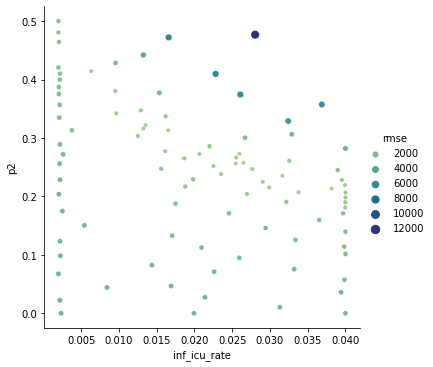

In [8]:
pd.set_option('display.max_rows', 320)
def create_dataframe(logs_1000_icu):
    data_icu_1000=[]
    target_1000_icu=[]
    for logs in logs_1000_icu:
        target_1000_icu.append(-logs['target'])
        data_icu_1000.append((logs['params']['inf_icu_rate'],logs['params']['p2'],-logs['target']))
    target_1000_icu.sort()

    data_icu_1000_frame = pd.DataFrame(data_icu_1000, columns = ['inf_icu_rate','p2','rmse'])
    data_icu_1000_frame.sort_values(by=['rmse'],ascending=False)
    data_icu_1000_frame_sorted=data_icu_1000_frame.sort_values(by ='rmse')
    return data_icu_1000_frame_sorted

logs_dataframe=create_dataframe(logs_inf_icu) # logs_1000_icu, logs_inf_icu
sns_plot=sns.relplot(data=logs_dataframe,x='inf_icu_rate', y='p2',kind='scatter',hue='rmse',
            size='rmse',palette="crest")
#sns_plot.savefig("log_rmse_inf_icu.png")

In [9]:
print(logs_dataframe)

    inf_icu_rate        p2          rmse
82      0.027621  0.246845    287.461203
36      0.026494  0.257372    290.575092
50      0.038171  0.213128    293.190558
91      0.020665  0.272730    298.305653
13      0.025475  0.256569    302.963857
77      0.027674  0.246914    303.196078
97      0.016535  0.313263    305.597880
78      0.031641  0.235333    314.613354
70      0.025970  0.272859    344.108583
98      0.013544  0.322007    354.195283
95      0.009650  0.342388    354.289821
18      0.006331  0.414341    399.113940
62      0.029058  0.224960    434.330084
60      0.018593  0.265218    453.516125
30      0.023528  0.238342    469.158090
99      0.013264  0.316221    505.670807
83      0.040000  0.206754    529.685698
75      0.029904  0.215386    538.472965
81      0.039925  0.219505    551.934482
76      0.018709  0.265211    551.963071
94      0.033787  0.207285    559.688517
93      0.022516  0.251912    570.053600
86      0.025531  0.266552    573.917678
32      0.040000

In [10]:
def produce_simul(inf_icu_rate,p2,num_icu,coef):
    #coef_list=[1.40]
    #for coef in coef_list:
    scale=1 #1 if real simul 
    days=len(death_croatia_int) ; oduzeto=35 ; scaledays=1
    #inf_icu_rate=optimizer.max['params']['inf_icu_rate']
    #p2=optimizer.max['params']['p2']
    #inf_icu_rate= 0.013498085670761639 ; p2= 0.1297056829469699
    #p1=1; p2=0.07; ext=4; extpop=0; k=2.5; mu=5; cluster_size=3; seed=0; r=0.1 ; num_icu=250; number_people=1000000
    #p1=1; p2=0.065; ext=4; extpop=0; k=2.5; mu=5; cluster_size=3; seed=0; r=0.1 ; num_icu=250; number_people=1000000
    #p1=1; p2=0.11; ext=4; extpop=0; k=2.5; mu=5; cluster_size=3; seed=0; r=0.1 ; num_icu=1000000; number_people=1000000
    #p1=1; p2=0.01497677267445777; ext=4; extpop=0; k=2.5; mu=5; cluster_size=3; seed=0; r=0.1 ; num_icu=1000000; number_people=1000000
    p1=1; ext=5; extpop=0; k=2.5; mu=5; cluster_size=3; seed=0; r=0.1 ; number_people=4000000 ; 
    if ext==0:
        type_ext="base"
    if ext==1:
        type_ext="superspreaders"
    if ext==2:
        type_ext="domovi"
    else:
        type_ext="croatia"

    new_p2=p2*coef; new_day=days-19-31-20-oduzeto
    data=simulation(scale,num_icu,number_people,days,oduzeto,scaledays,p1,p2,ext,extpop,k,mu,cluster_size,seed,
                    r,1.4,type_ext,inf_icu_rate,new_p2,new_day)
    return data
def create_list_optimal_data(logs_dataframe,n_icu):
    oduzeto = 35
    data_list_inf=[]
    small_icu_1000=logs_dataframe.head(1)
    for index, row in small_icu_1000.iterrows():
        print(row["inf_icu_rate"],row["p2"],row["rmse"])
        data = produce_simul(row["inf_icu_rate"],row["p2"],n_icu,2.2) # 1000,4000000
        rms = mean_squared_error(moving_avg(list(accumulate(death_croatia_int[oduzeto:])),14), 
                moving_avg(data['dead covid19'],14), squared=False)
        print(rms)
        
        data_list_inf.append((data,row["inf_icu_rate"],row["p2"]))
    return data_list_inf

def create_list_optimal_data2(logs_dataframe,n_icu):
    oduzeto = 35
    data_list_inf=[]
    small_icu_1000=logs_dataframe.head(1)
    coef_list=[1.4,1.6,1.8,2.0,2.2,2.4,2.5,2.6,2.7,2.8,2.9,3.0] #[1.8,2.2,2.6] #40%,120% ,180%
    for coef in coef_list:
        for index, row in small_icu_1000.iterrows():
                print(row["inf_icu_rate"],row["p2"],row["rmse"],coef)
                data = produce_simul(row["inf_icu_rate"],row["p2"],n_icu,coef) # 1000,4000000
                rms = mean_squared_error(moving_avg(list(accumulate(death_croatia_int[oduzeto:])),14), 
                        moving_avg(data['dead covid19'],14), squared=False)
                print(rms)
        
        data_list_inf.append((data,small_icu_1000["inf_icu_rate"],small_icu_1000["p2"]))
    return data_list_inf

n_icu=4000000 #1000,4000000
list_optimal_data_inf=[] # list_optimal_data_1000, list_optimal_data_inf
list_optimal_data_inf=create_list_optimal_data(logs_dataframe,n_icu)
#list_optimal_data_inf=create_list_optimal_data2(logs_dataframe,n_icu)

0.027621257119491878 0.24684514907974991 287.46120323215166


Running model with params: cluster_size = 3.000 , prob_goes_on_trip = 1.000 , prob_c_neighbour_trip_candidate = 0.247 seed = 0


307.8060686631642


In [151]:
#with open("list_optimal_data_1000.json", "w") as f:
#    json.dump(list_optimal_data_1000, f, indent=4)
    
with open("list_optimal_data_inf.json", "w") as f:
    json.dump(list_optimal_data_inf, f, indent=4)

mortality=  1.3810628559745939 %   p2 =  0.24684514907974991


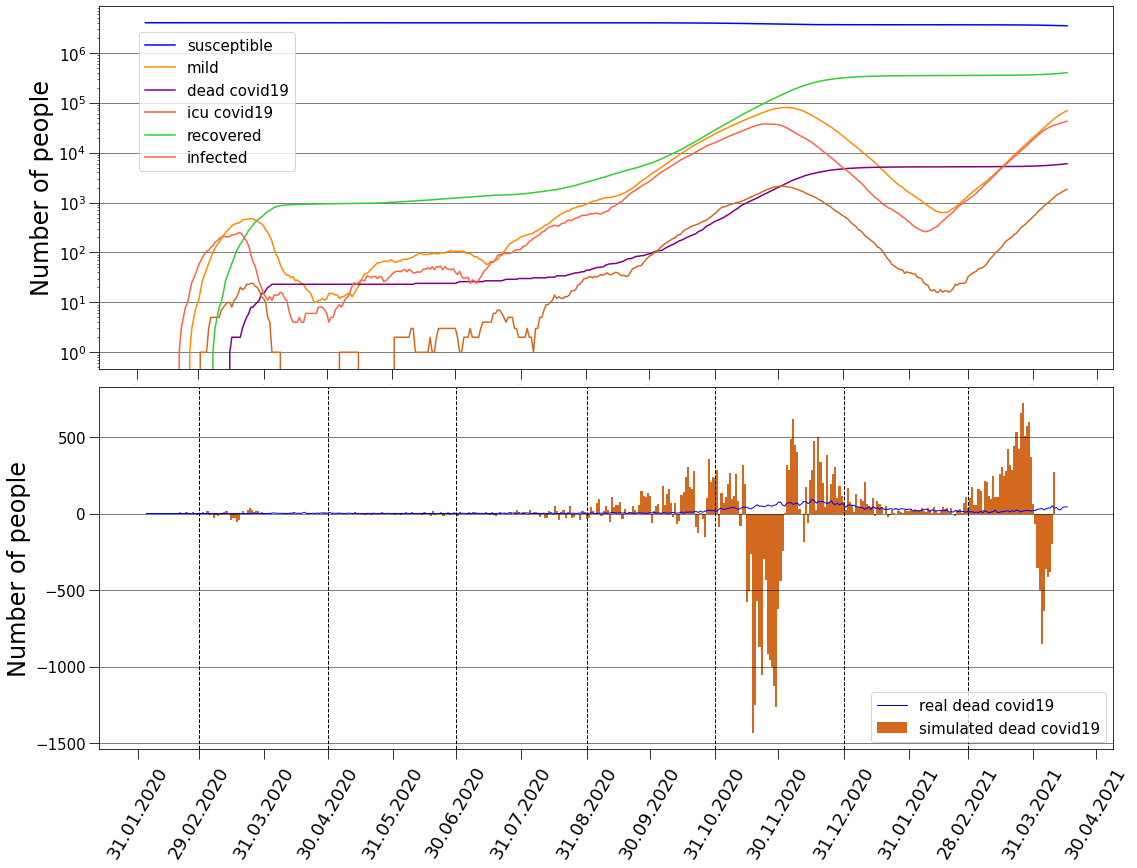

In [93]:
def plot_optimal(data,num_icu,inf_icu_rate,p2):
    days=len(death_croatia_int) ; oduzeto=35 ; scaledays=1 ; coef=1.5 
    p1=1; ext=5; extpop=0; k=2.5; mu=5; cluster_size=3; seed=0; r=0.1 ; number_people=4000000 ; 
    odrezi=3
    save=False
    shade_list=[False]
    N_list=[1]
    type_ext="croatia"
    for shade in shade_list:
        for N in N_list:
            time_series_plot_infected(data,cluster_size,p1,p2,k,mu,r,type_ext,save,extpop,death_croatia_int[oduzeto:],N,shade,
                              oduzeto,coef,num_icu,odrezi)
            
ind=0# 0,3,5 ako inf, 3,4,5,6,7 ako si 1000 icu
print("mortality= ", list_optimal_data_inf[ind][1]*50,"%","  p2 = ",list_optimal_data_inf[ind][2])
plot_optimal(list_optimal_data_inf[ind][0],4000000,list_optimal_data_inf[ind][1],list_optimal_data_inf[ind][2])
#for i in range(0,10):
#    print(list_optimal_data_1000[i][0]["icu covid19"][-30])

mortality=  1.3810628559745939 %   p2 =  0.24684514907974991


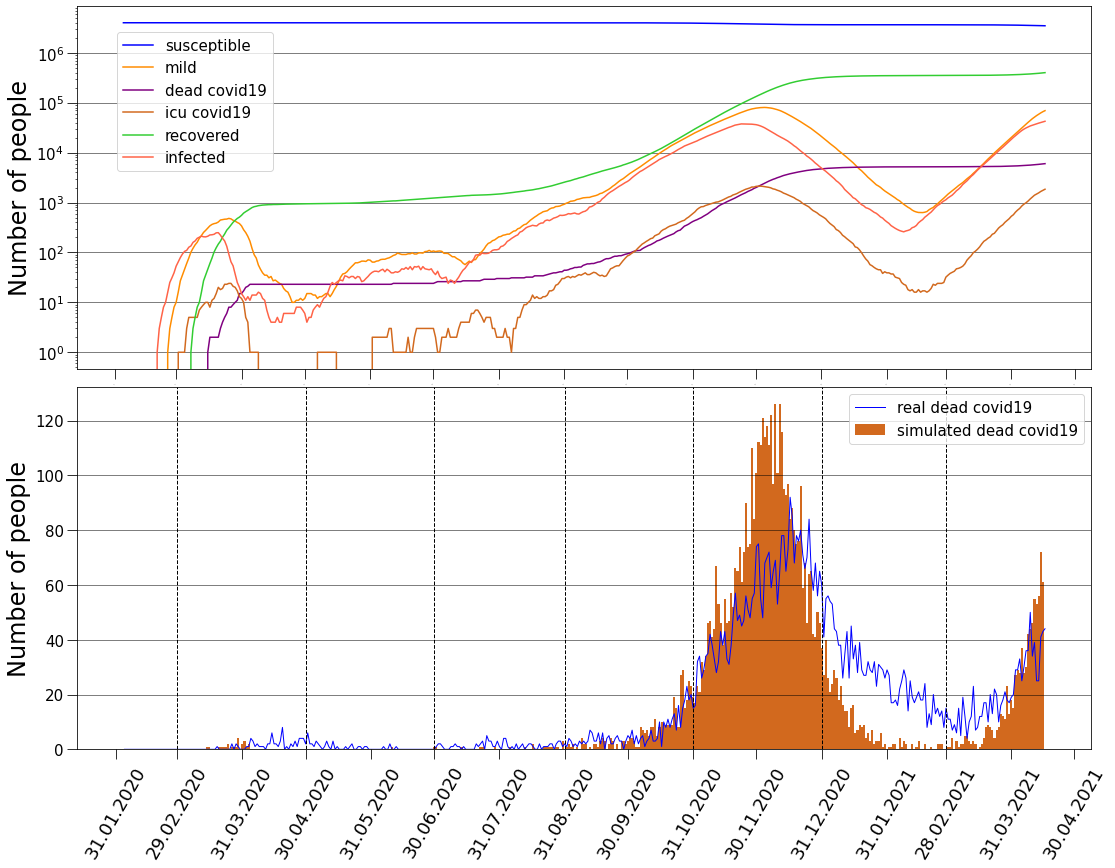

In [20]:
def plot_optimal(data,num_icu,inf_icu_rate,p2):
    days=len(death_croatia_int) ; oduzeto=35 ; scaledays=1 ; coef=1.5 
    p1=1; ext=5; extpop=0; k=2.5; mu=5; cluster_size=3; seed=0; r=0.1 ; number_people=4000000 ; 
    odrezi=3
    save=False
    shade_list=[False]
    N_list=[1]
    type_ext="croatia"
    for shade in shade_list:
        for N in N_list:
            time_series_plot2(data,cluster_size,p1,p2,k,mu,r,type_ext,save,extpop,death_croatia_int[oduzeto:],N,shade,
                              oduzeto,coef,num_icu,odrezi)
            
ind=0# 0,3,5 ako inf, 3,4,5,6,7 ako si 1000 icu
print("mortality= ", list_optimal_data_inf[ind][1]*50,"%","  p2 = ",list_optimal_data_inf[ind][2])
plot_optimal(list_optimal_data_inf[ind][0],4000000,list_optimal_data_inf[ind][1],list_optimal_data_inf[ind][2])
#for i in range(0,10):
#    print(list_optimal_data_1000[i][0]["icu covid19"][-30])

mortality=  82    1.381063
Name: inf_icu_rate, dtype: float64 %   p2 =  82    0.246845
Name: p2, dtype: float64


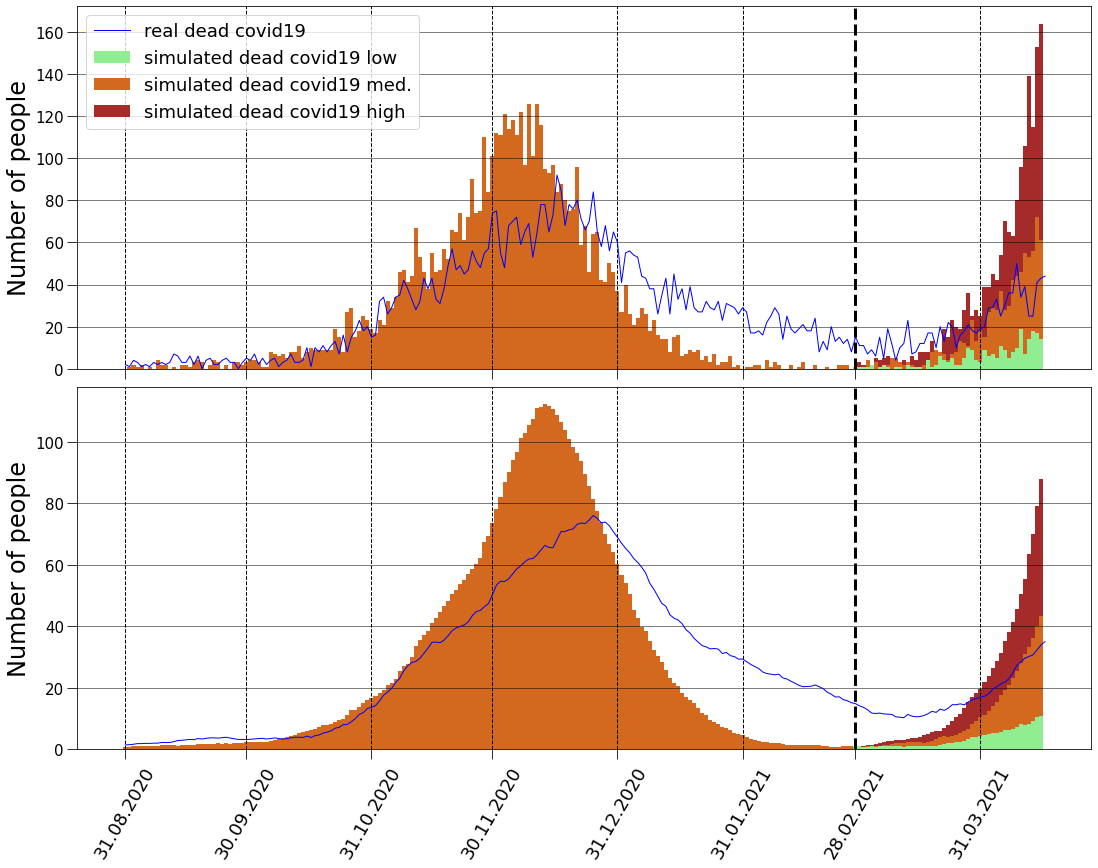

In [164]:
def plot_optimal2(data,data2,data3,num_icu,inf_icu_rate,p2):
    days=len(death_croatia_int) ; oduzeto=35 ; scaledays=1 ; coef=1.5 
    p1=1; ext=5; extpop=0; k=2.5; mu=5; cluster_size=3; seed=0; r=0.1 ; number_people=4000000 ; 
    odrezi=3
    save=False
    shade=False
    N=1; N1=14;
    type_ext="croatia"
    time_series_plot2_3(data,data2,data3,cluster_size,p1,p2,k,mu,r,type_ext,save,extpop,
                      death_croatia_int[oduzeto:],N,N1,shade,oduzeto,coef,num_icu,odrezi)
            
ind=7# 0,3,5 ako inf, 3,4,5,6,7 ako si 1000 icu
print("mortality= ", list_optimal_data_inf[ind][1]*50,"%","  p2 = ",list_optimal_data_inf[ind][2])
plot_optimal2(list_optimal_data_inf[4][0],list_optimal_data_inf[0][0],list_optimal_data_inf[9][0],
             4000000,list_optimal_data_inf[ind][1],list_optimal_data_inf[ind][2])

In [278]:
#coef_list=[0.99,1.01]
ind=9
scale=1 #1 if real simul 

days=366 ; oduzeto=35 ; scaledays=1

#p1=1; p2=0.065; ext=4; extpop=0; k=2.5; mu=5; cluster_size=3; seed=0; r=0.1 ; num_icu=250; number_people=1000000
p1=1; p2=list_optimal_data_1000[ind][2]; 
ext=5; extpop=0; k=2.5; mu=5; cluster_size=3; seed=0; r=0.1 ; num_icu=1000; number_people=4000000

#coef=1.05

if ext==0:
    type_ext="base"
if ext==1:
    type_ext="superspreaders"
if ext==2:
    type_ext="domovi"
else:
    type_ext="croatia"

#coef1=1.005 ; coef2=0.995 ; coef=1
#data1=simulation(scale,days,oduzeto,scaledays,p1,p2,ext,extpop,k,mu,cluster_size,seed,r,coef1,type_ext)
#data2=simulation(scale,days,oduzeto,scaledays,p1,p2,ext,extpop,k,mu,cluster_size,seed,r,coef2,type_ext)
#data=simulation(scale,days,oduzeto,scaledays,p1,p2,ext,extpop,k,mu,cluster_size,seed,r,coef,type_ext)

#list_variation = [0.12,0.15,0.2,0.25]
#list_variation = [0.03]
list_variation = [0.01,0.02,0.05]
coef=1
#data=simulation(scale,num_icu,number_people,days,oduzeto,scaledays,p1,p2,ext,extpop,k,mu,cluster_size,seed,r,
#                coef,type_ext,list_optimal_data_1000[ind][1])
for variation in list_variation:
    #coef1=coef+variation
    #coef2=coef-variation
    
    #p2=p2 - p2*variation; coef1=1.005 ; coef2=0.995 ; coef=1
    #p2=p2 - p2*variation
    data1=simulation(scale,num_icu,number_people,days,oduzeto,scaledays,p1,p2,ext,extpop,k,mu,cluster_size,seed,r,
                     coef1,type_ext,list_optimal_data_1000[ind][1])
    #p2=0.065 ; p2 = p2 + p2*variation;
    #p2 = p2 + p2*variation
    data2=simulation(scale,num_icu,number_people,days,oduzeto,scaledays,p1,p2,ext,extpop,k,mu,cluster_size,seed,r,
                     coef2,type_ext,list_optimal_data_1000[ind][1])
    #p2=0.065

    save=True
    p2_sens=True
    fill_list=[False]
    N_list=[1,14]
    shade=True
    #type_ext="croatia_p2_var"
    for N in N_list:
        for fill in fill_list:
            time_series_plot3(data1,data2,data,cluster_size,p1,p2,k,r,type_ext,save,extpop,
                              death_croatia_int[oduzeto:],N,shade,oduzeto,coef1,coef2,coef,fill,num_icu,p2_sens)

Running model with params: cluster_size = 3.000 , prob_goes_on_trip = 1.000 , prob_c_neighbour_trip_candidate = 0.077 seed = 0
Running model with params: cluster_size = 3.000 , prob_goes_on_trip = 1.000 , prob_c_neighbour_trip_candidate = 0.078 seed = 0
Running model with params: cluster_size = 3.000 , prob_goes_on_trip = 1.000 , prob_c_neighbour_trip_candidate = 0.076 seed = 0
Running model with params: cluster_size = 3.000 , prob_goes_on_trip = 1.000 , prob_c_neighbour_trip_candidate = 0.078 seed = 0
Running model with params: cluster_size = 3.000 , prob_goes_on_trip = 1.000 , prob_c_neighbour_trip_candidate = 0.074 seed = 0
Running model with params: cluster_size = 3.000 , prob_goes_on_trip = 1.000 , prob_c_neighbour_trip_candidate = 0.077 seed = 0


In [11]:
a=config["simulation"]["initial_params"][0]["prob_goes_on_trip"]
b=config["simulation"]["initial_params"][0]["prob_c_neighbour_trip_candidate"]
c=config["simulation"]["mu"]
d=config["graph_generation"][0]["num_clusters"]
e=config["graph_generation"][0]["num_people_per_cluster"]
print("prob_goes_on_trip = ",a)
print("prob_c_neighbour_trip_candidate = ",b)
print("Mu = ", c)
print("num clusters = ", d)
print("num people per cluster = ", e)

prob_goes_on_trip =  0.5
prob_c_neighbour_trip_candidate =  0
Mu =  5
num clusters =  250000
num people per cluster =  4


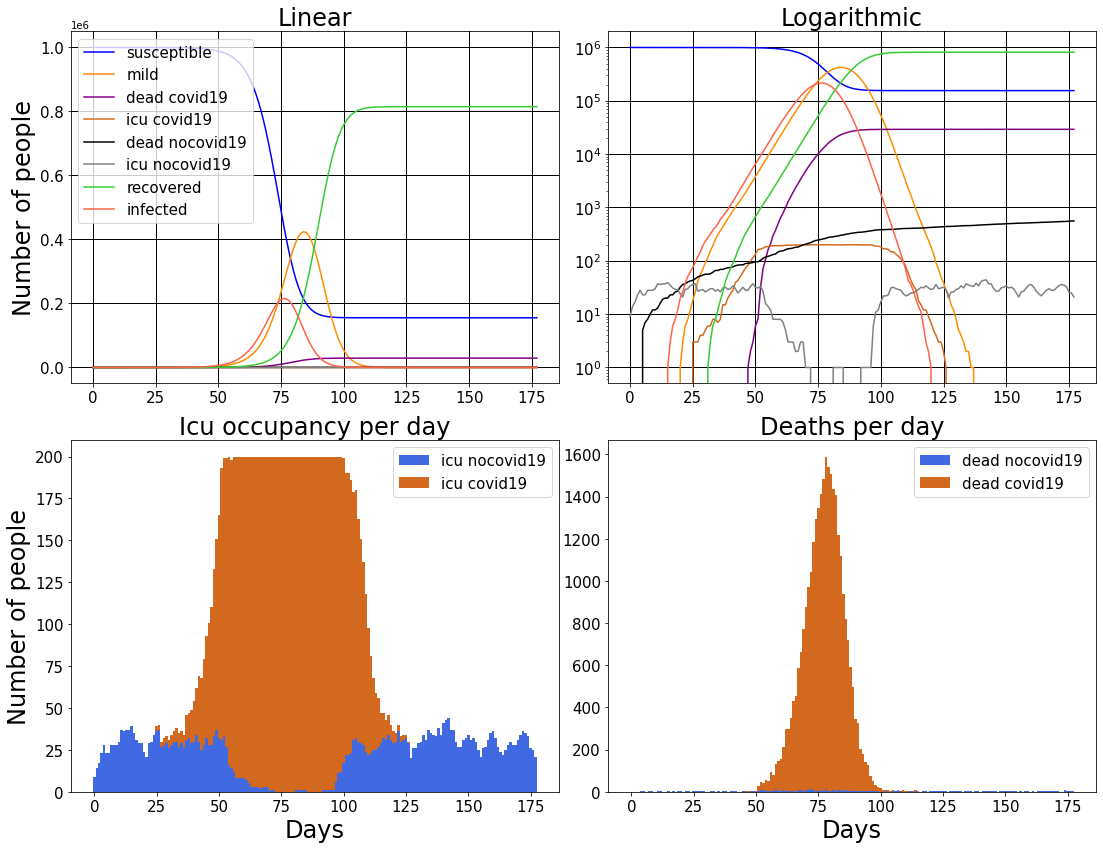

In [391]:
def colorplot(state):
    if state=="dead covid19":
        return "purple"
    if state=="dead nocovid19":
        return "black"
    if state=="icu covid19":
        return "chocolate"
    if state=="icu nocovid19":
        return "grey"
    if state=="infected":
        return "tomato"
    if state=="mild":
        return "darkorange"
    if state=="recovered":
        return "limegreen"
    if state=="susceptible":
        return "blue"


def time_series_plot(data,cluster_dim,p1,p2,k,type_ext,save,extpop):
    
    if type_ext=="base":
        title_plot=""
    else:
        title_plot=""
    
    file_title=(type_ext.capitalize() + " Model " 
                + ", Cluster size = {}".format(cluster_dim)
                + " , Special pop = {}".format(extpop)
                + " , p1 = {}".format(p1)
                + " , p2 = {}".format(p2)) 
    sx=2
    sy=2
    fig, ax = plt.subplots(nrows=sx,ncols=sy, sharex=False, sharey=False,figsize=(16, 12))
    fig.subplots_adjust(left=0.06, bottom=0.06, right=0.95, top=0.94, wspace=0.1,hspace = 0.16)
    fig.suptitle(title_plot)

    #'inferno'
    #'rainbow'
    
    end_pandemic = (len((data["mild"])) - 1 - 
        next(x for x, val in enumerate(reversed(data["mild"])) if val > 0 ))
    days=(end_pandemic+40)+1
    
    #standard
    for state in data:
        ax[0,0].plot(np.arange(len(data[state][0:days])), data[state][0:days],
                     label=state,color=colorplot(state))
    #for event in config["simulation"]["events"]:
    #    ax[0,0].axvline(x=event["day"], label=event["label"],color="k", linewidth=5)
        
    ax[0,0].set_title("Linear",fontsize=24)
    #ax[0,0].legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.5)
    ax[0,0].grid(color='black', which='major',linestyle='-', linewidth=1)
    ax[0,0].grid(color='grey', which='minor',linestyle='--', linewidth=0.3)
    ax[0,0].legend(bbox_to_anchor=(0, 1), loc='upper left',fontsize=15)
    ax[0,0].tick_params(labelsize=15)
    #bbox_to_anchor=(0.75, 1), loc='upper left',

    ax[0, 0].set_ylabel('Number of people',fontsize=24)
    
    #logplot
    for state in data:
        ax[0,1].plot(np.arange(len(data[state][0:days])), data[state][0:days],
                     label=state,color=colorplot(state))
        
    ax[0,1].set_title("Logarithmic", fontsize=24)
    ax[0,1].set_yscale("log")
    ax[0,1].grid(color='black', which='major',linestyle='-', linewidth=1)
    #ax[0,1].grid(color='grey', which='minor',linestyle='--', linewidth=0.05)
    
    #icu plot
    width=1
    
    ax[1,0].set_title("Icu occupancy per day",fontsize=24)
    item1=ax[1,0].bar(np.arange(len(data['icu nocovid19'][0:days])), data['icu nocovid19'][0:days],width=width,
                     color="royalblue")
    # Create green bars (middle), on top of the firs ones
    item2=ax[1,0].bar(np.arange(len(data['icu covid19'][0:days])), data['icu covid19'][0:days], 
                      bottom=data['icu nocovid19'][0:days],width=width,color="chocolate")
    # Create green bars (top)
    ax[1,0].legend([item1, item2], ['icu nocovid19','icu covid19'],fontsize=15)
    
    diffdead=[t - s for s, t in zip(data['dead covid19'], data['dead covid19'][1:])]
    diffnocoronadead=[t - s for s, t in zip(data['dead nocovid19'], data['dead nocovid19'][1:])]
    
    ax[1, 0].set_ylabel('Number of people',fontsize=24)            
    ax[1, 0].set_xlabel('Days',fontsize=24)
    
    # Create brown bars
    ax[1,1].set_title("Deaths per day",fontsize=24)
    item1=plt.bar(np.arange(len(diffnocoronadead[0:days])), diffnocoronadead[0:days], width=width,
                     color="royalblue")
    # Create green bars (middle), on top of the firs ones
    item2=plt.bar(np.arange(len(diffdead[0:days])), diffdead[0:days], bottom=diffnocoronadead[0:days], 
                  width=width,color="chocolate")
    # Create green bars (top)

    ax[1,1].legend([item1, item2], ['dead nocovid19','dead covid19'],fontsize=15)
    ax[1, 1].set_xlabel('Days',fontsize=24)
    ax[0,0].tick_params(labelsize=15)
    ax[0,1].tick_params(labelsize=15)
    ax[1,0].tick_params(labelsize=15)
    ax[1,1].tick_params(labelsize=15)
    
    if save==True:            
        plt.savefig("outputsBilj/"+ file_title + '.png')

#p1=0.7 # p trip
#p2=0.85 # p neighbour quarantine misbehaviour
if ext==0:
    type_ext="base"
if ext==1:
    type_ext="superspreaders"
if ext==2:
    type_ext="domovi"
#ext=1 # 0 base, 1 superspreaders, 2 domovi
#extpop=100
#k=2.5
#mu=5
cluster_dim=cluster_size
seed=0
save=True
    
time_series_plot(data_rad3,cluster_dim,p1,p2,k,type_ext,save,extpop)

In [155]:
#sansa da ovdje izleti stopiteration jer se niko nije zarazio je ((0.999999)^{10^6})^30 = 10^{-13}, ali evo try. :D
try:
    beginning_pandemic = next(x for x, val in enumerate(data1["stats"]["infectious"]) if val > 0)
except StopIteration:
    beginning_pandemic = 15
    end_pandemic = 15
    len_pandemic = 0
else:    
    beginning_pandemic = next(x for x, val in enumerate(data1["stats"]["infectious"]) if val > 0)
    end_pandemic = len((data1["stats"]["mild"])) - 1 - next(x for x, val in enumerate(reversed(data1["stats"]["mild"])) if val > 0 )
    #end_pandemic = next(x for x, val in enumerate(data1["stats"]["mild"]) if (val == 0 and x > beginning_pandemic + 10) )
    len_pandemic = end_pandemic - beginning_pandemic + 1
peak_corona_total = max([sum(x) for x in zip( (data1["stats"]["infectious"]),(data1["stats"]["mild"]), (data1["stats"]["icu"]))])
peak_corona_system_load = max([sum(x) for x in zip( (data1["stats"]["mild"]), (data1["stats"]["icu"]))])
corona_deaths = data1["stats"]["dead"][-1]
no_corona_deaths = data1["stats"]["nocorona_dead"][-1]

print("beginning pandemic = ",beginning_pandemic) # first index is 0.
print("length pandemic = ",len_pandemic)
print("peak corona total = ",peak_corona_total)
print("peak corona known (mild+ic) = ",peak_corona_system_load)
print("corona deaths total = ",corona_deaths)
print("no_corona deaths total= ",no_corona_deaths)



KeyError: 'infectious'

In [8]:
croatiaresp=int(34/4)
croatiadeaths=int(31/4)

croatia_now_resp = next(x for x, val in enumerate(data1["stats"]["icu"]) if val > croatiaresp)
croatia_now_deaths = next(x for x, val in enumerate(data1["stats"]["dead"]) if val > croatiadeaths)

print("Day in pandemic for respirators = ",croatia_now_resp)
print("Day in pandemic for deaths = ",croatia_now_deaths)

corona_total = [sum(x) for x in zip( (data1["stats"]["infectious"]),(data1["stats"]["mild"]), (data1["stats"]["icu"]))]
print("Croatia's Total number of cases is in the range = ",
      4*min(corona_total[croatia_now_resp],corona_total[croatia_now_deaths]), "-",
      4*max(corona_total[croatia_now_resp],corona_total[croatia_now_deaths]))

Day in pandemic for respirators =  77
Day in pandemic for deaths =  91
Croatia's Total number of cases is in the range =  14348 - 28256


In [50]:
def outbreak_plot(data_list,perc_list,cluster_dim,type_ext,save,days,N,od):
    file_title=(type_ext.capitalize() + " Model " 
                + ", Cluster size".format(cluster_dim))
    
    figure = plt.gcf() # get current figure
    figure.set_size_inches(16, 12)
    N=14
    #days=500
    i=0
    for data in data_list:
        #del data["mild"]
        #del data["dead covid19"]
        #del data["icu covid19"]
        #del data["dead nocovid19"]
        #del data['icu nocovid19']
        #del data['recovered']
        #del data["infected"]
        total_cases= [sum(x) for x in zip( (data['recovered']),(data["dead covid19"]))]
        for state in data:
            if state=="icu covid19":
                plt.axvline(x=data[state].index(199))
            if state=="dead covid19":
                #plt.plot(np.arange(len(moving_avg(list(total_cases[od:days]),N))), 
                #         moving_avg(list(total_cases[od:days]),N),label="p1 = " + str(perc_list[i]))
                plt.plot(np.arange(len(moving_avg(list(data[state][0:days]),N))), 
                         moving_avg(list(data[state][0:days]),N),label="p1 = " + str(perc_list[i]))
            else:
                continue
        i+=1
    #for event in config["simulation"]["events"]:
    #    ax[0,0].axvline(x=event["day"], label=event["label"],color="k", linewidth=5)
        
    #ax[0,0].legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.5)
    plt.legend(fontsize=25)
    #plt.grid(color='black', which='major',linestyle='-', linewidth=1)
    plt.grid(color='grey', which='minor',linestyle='--', linewidth=0.3)
    plt.xlim(0,days-od)
    #plt.ylim(0,50000)
    #plt.xticks(ticks=cluster_dim_list,fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.xlabel('Days',fontsize=30)
    plt.ylabel('Cases',fontsize=30)
    #logplot
    #plt.yscale("log")
    
    
    if save==True:            
        plt.savefig("outputsBilj/"+ file_title + '.png')

In [86]:
scale=1 #1 if real simul 

days=100 ; oduzeto=0 ; scaledays=1

#p1=1; p2=0.065; ext=4; extpop=0; k=2.5; mu=5; cluster_size=3; seed=0; r=0.1 ; num_icu=250; number_people=1000000
p2=0;
ext=0; extpop=0; k=2.5; mu=5; cluster_size=3; seed=0; r=0.1 ; num_icu=200; number_people=1000000
inf_icu_rate=0.01; coef1=1;

#coef=1.05

if ext==0:
    type_ext="base"
if ext==1:
    type_ext="superspreaders"
if ext==2:
    type_ext="domovi"
else:
    type_ext="croatia"

p1=1
data100=simulation(scale,num_icu,number_people,days,oduzeto,scaledays,p1,p2,ext,extpop,k,mu,cluster_size,seed,r,
                 coef1,type_ext,inf_icu_rate)
p1=0.75
data75=simulation(scale,num_icu,number_people,days,oduzeto,scaledays,p1,p2,ext,extpop,k,mu,cluster_size,seed,r,
                 coef1,type_ext,inf_icu_rate)
p1=0.5
data50=simulation(scale,num_icu,number_people,days,oduzeto,scaledays,p1,p2,ext,extpop,k,mu,cluster_size,seed,r,
                 coef1,type_ext,inf_icu_rate)
p1=0.25
data25=simulation(scale,num_icu,number_people,days,oduzeto,scaledays,p1,p2,ext,extpop,k,mu,cluster_size,seed,r,
                 coef1,type_ext,inf_icu_rate)
p1=0
data0=simulation(scale,num_icu,number_people,days,oduzeto,scaledays,p1,p2,ext,extpop,k,mu,cluster_size,seed,r,
                 coef1,type_ext,inf_icu_rate)
data_list=[data100,data75,data50,data25,data0]

Running model with params: cluster_size = 3.000 , prob_goes_on_trip = 1.000 , prob_c_neighbour_trip_candidate = 0.000 seed = 0
Running model with params: cluster_size = 3.000 , prob_goes_on_trip = 0.750 , prob_c_neighbour_trip_candidate = 0.000 seed = 0
Running model with params: cluster_size = 3.000 , prob_goes_on_trip = 0.500 , prob_c_neighbour_trip_candidate = 0.000 seed = 0
Running model with params: cluster_size = 3.000 , prob_goes_on_trip = 0.250 , prob_c_neighbour_trip_candidate = 0.000 seed = 0
Running model with params: cluster_size = 3.000 , prob_goes_on_trip = 0.000 , prob_c_neighbour_trip_candidate = 0.000 seed = 0


In [ ]:
save=False
days=40
od=15
N=21
perc_list=[1,0.75,0.5,0.25,0]
outbreak_plot(data_list,perc_list,cluster_size,type_ext,save,days,N,od)

In [24]:
def tip_ext(ext):
    if ext==0:
        type_ext="base"
    if ext==1:
        type_ext="superspreaders"
    if ext==2:
        type_ext="domovi"
    else:
        type_ext="croatia"
    return type_ext

scale=1 #1 if real simul 
days=200 ; oduzeto=0 ; scaledays=1
#p1=1; p2=0.065; ext=4; extpop=0; k=2.5; mu=5; cluster_size=3; seed=0; r=0.1 ; num_icu=250; number_people=1000000
p2=1;p1=1
k=2.5; mu=5; cluster_size=3; seed=0; r=0.1 ; num_icu=200; number_people=1000000
inf_icu_rate=0.01; coef1=1;

#coef=1.05

cluster_size=2;ext=0;extpop=0; type_ext=tip_ext(ext)
data2b=simulation(scale,num_icu,number_people,days,oduzeto,scaledays,p1,p2,ext,extpop,k,mu,cluster_size,seed,r,
                 coef1,type_ext,inf_icu_rate)

cluster_size=3;ext=0;extpop=0; type_ext=tip_ext(ext)
data3b=simulation(scale,num_icu,number_people,days,oduzeto,scaledays,p1,p2,ext,extpop,k,mu,cluster_size,seed,r,
                 coef1,type_ext,inf_icu_rate)

cluster_size=4;ext=0;extpop=0; type_ext=tip_ext(ext)
data4b=simulation(scale,num_icu,number_people,days,oduzeto,scaledays,p1,p2,ext,extpop,k,mu,cluster_size,seed,r,
                 coef1,type_ext,inf_icu_rate)

cluster_size=5;ext=0;extpop=0; type_ext=tip_ext(ext)
data5b=simulation(scale,num_icu,number_people,days,oduzeto,scaledays,p1,p2,ext,extpop,k,mu,cluster_size,seed,r,
                 coef1,type_ext,inf_icu_rate)

cluster_size=6;ext=0;extpop=0; type_ext=tip_ext(ext)
data6b=simulation(scale,num_icu,number_people,days,oduzeto,scaledays,p1,p2,ext,extpop,k,mu,cluster_size,seed,r,
                 coef1,type_ext,inf_icu_rate)

cluster_size=2;ext=2;extpop=280000; type_ext=tip_ext(ext)
data2d=simulation(scale,num_icu,number_people,days,oduzeto,scaledays,p1,p2,ext,extpop,k,mu,cluster_size,seed,r,
                 coef1,type_ext,inf_icu_rate)

cluster_size=3;ext=2;extpop=280000; type_ext=tip_ext(ext)
data3d=simulation(scale,num_icu,number_people,days,oduzeto,scaledays,p1,p2,ext,extpop,k,mu,cluster_size,seed,r,
                 coef1,type_ext,inf_icu_rate)

cluster_size=4;ext=2;extpop=280000; type_ext=tip_ext(ext)
data4d=simulation(scale,num_icu,number_people,days,oduzeto,scaledays,p1,p2,ext,extpop,k,mu,cluster_size,seed,r,
                 coef1,type_ext,inf_icu_rate)

cluster_size=5;ext=2;extpop=280000; type_ext=tip_ext(ext)
data5d=simulation(scale,num_icu,number_people,days,oduzeto,scaledays,p1,p2,ext,extpop,k,mu,cluster_size,seed,r,
                 coef1,type_ext,inf_icu_rate)
cluster_size=6;ext=2;extpop=280000; type_ext=tip_ext(ext)
data6d=simulation(scale,num_icu,number_people,days,oduzeto,scaledays,p1,p2,ext,extpop,k,mu,cluster_size,seed,r,
                 coef1,type_ext,inf_icu_rate)

data_list=[data2b,data3b,data4b,data5b,data6b,data2d,data3d,data4d,data5d,data6d]
perc_list=["base2","base3","base4","base5","base6","domovi2","domovi3","domovi4","domovi5","domovi6"]

Running model with params: cluster_size = 2.000 , prob_goes_on_trip = 1.000 , prob_c_neighbour_trip_candidate = 1.000 seed = 0
Running model with params: cluster_size = 3.000 , prob_goes_on_trip = 1.000 , prob_c_neighbour_trip_candidate = 1.000 seed = 0
Running model with params: cluster_size = 4.000 , prob_goes_on_trip = 1.000 , prob_c_neighbour_trip_candidate = 1.000 seed = 0
Running model with params: cluster_size = 5.000 , prob_goes_on_trip = 1.000 , prob_c_neighbour_trip_candidate = 1.000 seed = 0
Running model with params: cluster_size = 6.000 , prob_goes_on_trip = 1.000 , prob_c_neighbour_trip_candidate = 1.000 seed = 0
Running model with params: cluster_size = 2.000 , prob_goes_on_trip = 1.000 , prob_c_neighbour_trip_candidate = 1.000 seed = 0
Running model with params: cluster_size = 3.000 , prob_goes_on_trip = 1.000 , prob_c_neighbour_trip_candidate = 1.000 seed = 0
Running model with params: cluster_size = 4.000 , prob_goes_on_trip = 1.000 , prob_c_neighbour_trip_candidate =

In [47]:
def tip_ext(ext):
    if ext==0:
        type_ext="base"
    if ext==1:
        type_ext="superspreaders"
    if ext==2:
        type_ext="domovi"
    else:
        type_ext="croatia"
    return type_ext

scale=1 #1 if real simul 
days=200 ; oduzeto=0 ; scaledays=1
#p1=1; p2=0.065; ext=4; extpop=0; k=2.5; mu=5; cluster_size=3; seed=0; r=0.1 ; num_icu=250; number_people=1000000
p2=0;p1=1
k=2.5; mu=5; cluster_size=3; seed=0; r=0.1 ; num_icu=200; number_people=1000000
inf_icu_rate=0.01; coef1=1;

#coef=1.05

cluster_size=2;ext=0;extpop=0; type_ext=tip_ext(ext)
data2b=simulation(scale,num_icu,number_people,days,oduzeto,scaledays,p1,p2,ext,extpop,k,mu,cluster_size,seed,r,
                 coef1,type_ext,inf_icu_rate)

cluster_size=2;ext=2;extpop=280000; type_ext=tip_ext(ext)
data2d=simulation(scale,num_icu,number_people,days,oduzeto,scaledays,p1,p2,ext,extpop,k,mu,cluster_size,seed,r,
                 coef1,type_ext,inf_icu_rate)


data_list=[data2b,data2d]
perc_list=["base2","domovi2"]

Running model with params: cluster_size = 2.000 , prob_goes_on_trip = 1.000 , prob_c_neighbour_trip_candidate = 0.000 seed = 0
Running model with params: cluster_size = 2.000 , prob_goes_on_trip = 1.000 , prob_c_neighbour_trip_candidate = 0.000 seed = 0


ValueError: 199 is not in list

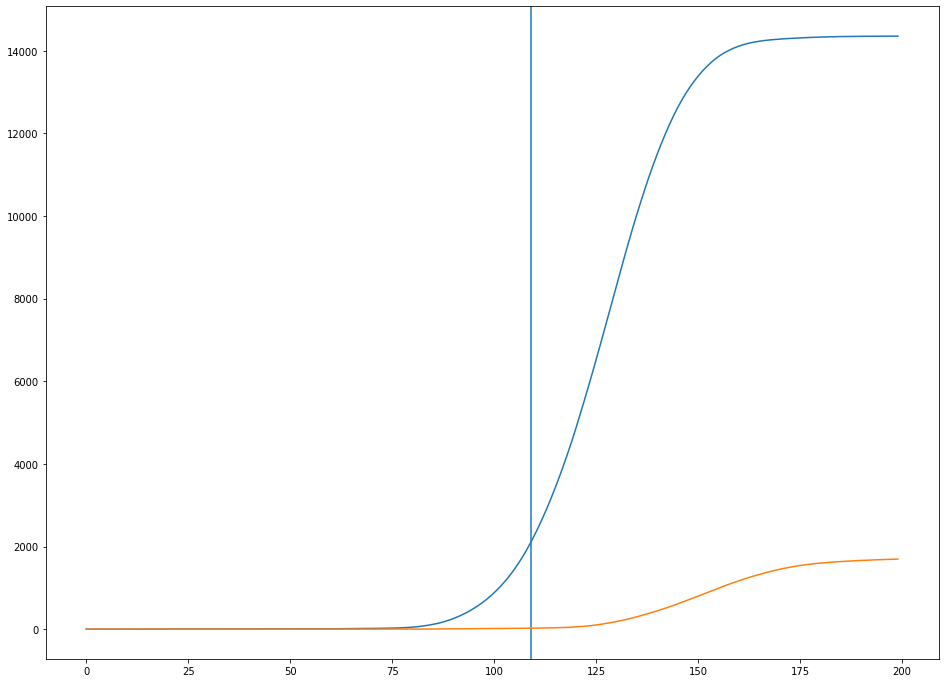

In [51]:
save=False
days=200
od=10
N=21
data_list=[data2b,data2d]
perc_list=["base2","domovi2"]
outbreak_plot(data_list,perc_list,cluster_size,type_ext,save,days,N,od)

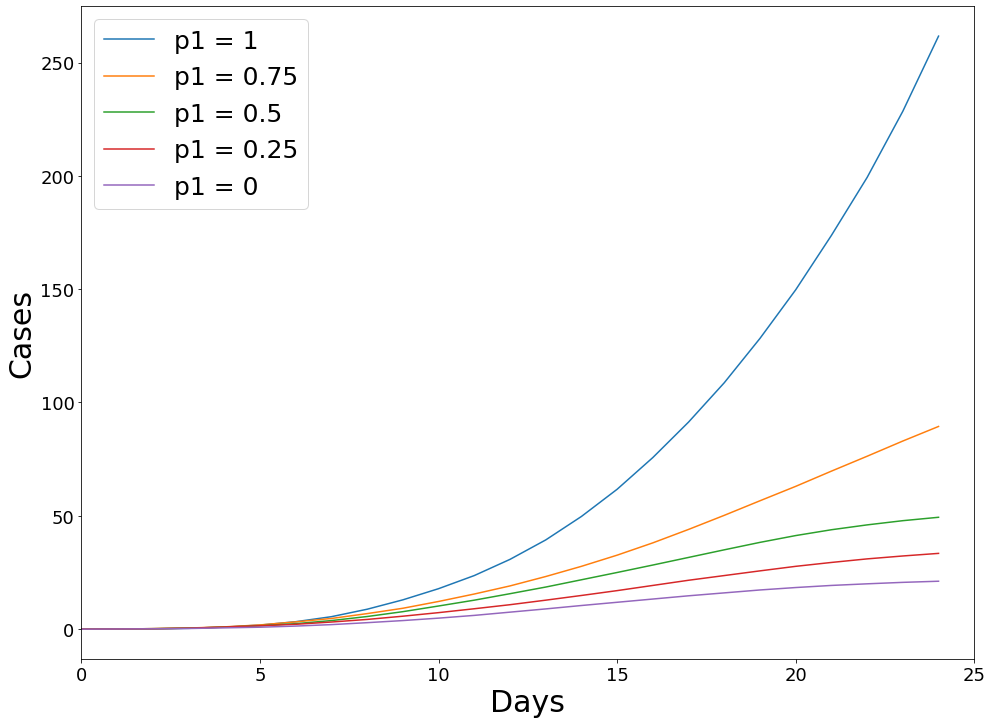

In [95]:
save=False
days=40
od=15
N=21
perc_list=[1,0.75,0.5,0.25,0]
outbreak_plot(data_list,perc_list,cluster_size,type_ext,save,days,N,od)

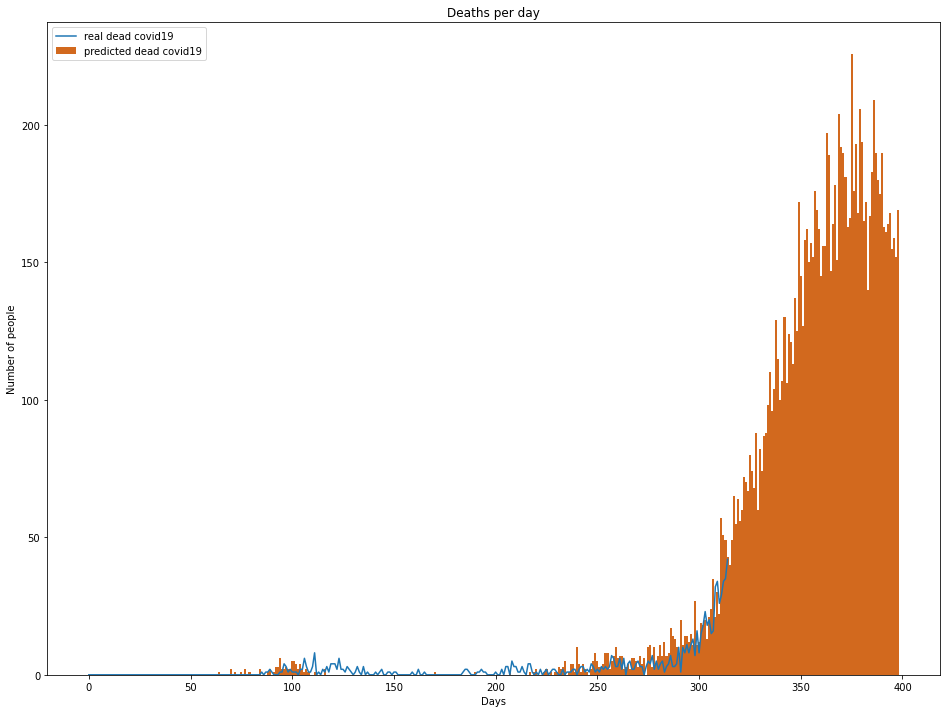

In [156]:
# y-axis in bold
#rc('font', weight='normal')
end_pandemic = (len((data["mild"])) - 1 - 
    next(x for x, val in enumerate(reversed(data["mild"])) if val > 0 ))
days=(end_pandemic+150)+1
diffdead=[t - s for s, t in zip(data['dead covid19'], data['dead covid19'][1:])]
diffnocoronadead=[t - s for s, t in zip(data['dead nocovid19'], data['dead nocovid19'][1:])]
width=1

plt.ylabel('Number of people')            
plt.xlabel('Days')

# Create brown bars
plt.title("Deaths per day")
# Create green bars (middle), on top of the firs ones
item2=plt.bar(np.arange(len(diffdead[0:days])), diffdead[0:days], 
              width=width,color="chocolate")
item1,=plt.plot(np.arange(len(death_croatia_int)), death_croatia_int)
# Create green bars (top)

plt.legend([item1 ,item2], ['real dead covid19','predicted dead covid19'])
 
# Custom X axis
figure = plt.gcf() # get current figure
figure.set_size_inches(16, 12)
plt.show
plt.savefig('outputsBilj/'+"hrvatska_smrti_prediction.pdf")

## From Mu

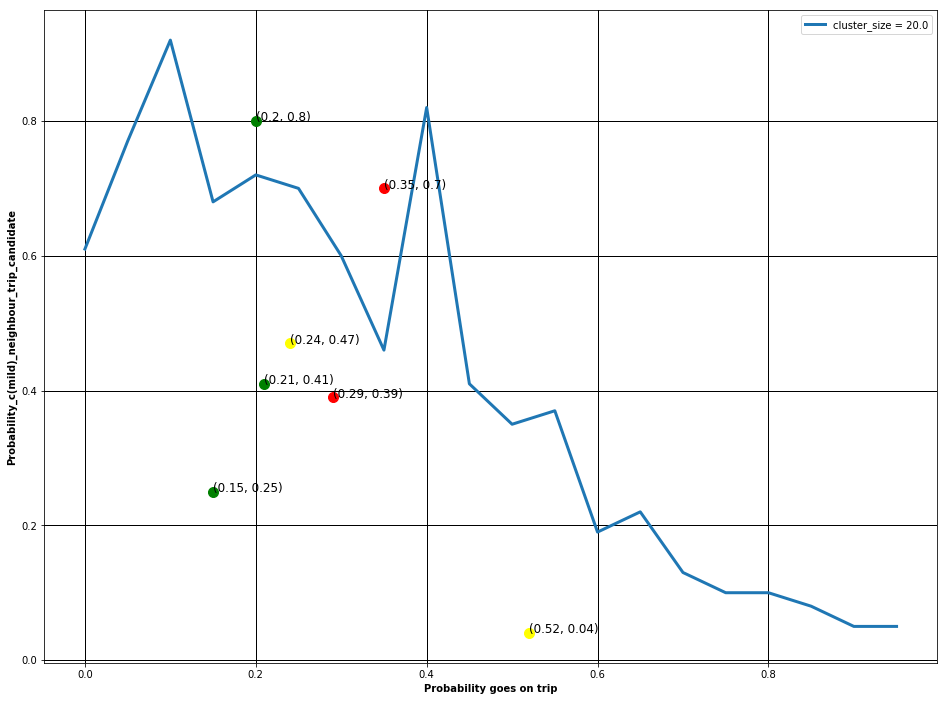

In [135]:
#rc('font', weight='bold')
h=19#15 je mu=5
for i in range(h,h+1):
#for i in range(0,len(list(mu_dict.keys()))-8):
    res = list(mu_dict.keys())[i]
    #rc('font', weight='normal')
    #plt.figure(figsize=(16,10))
    plt.plot([round(float(k),2) for k in mu_dict[res].keys()], [round(np.sum(mu_dict[res][k])/len(seeds),2) for k in mu_dict[res].keys()], 
             color='C'+str(i-h), linewidth=3,label='cluster_size = {}'.format(round(res,2)))
    plt.plot(0.21, 0.41, color='green', marker='o', linestyle='dashed',linewidth=2, markersize=10)
    plt.plot(0.15, 0.25, color='green', marker='o', linestyle='dashed',linewidth=2, markersize=10)
    plt.plot(0.2, 0.8, color='green', marker='o', linestyle='dashed',linewidth=2, markersize=10)
    plt.plot(0.35, 0.7, color='red', marker='o', linestyle='dashed',linewidth=2, markersize=10)
    plt.plot(0.29, 0.39, color='red', marker='o', linestyle='dashed',linewidth=2, markersize=10)
    plt.plot(0.24, 0.47, color='yellow', marker='o', linestyle='dashed',linewidth=2, markersize=10)
    plt.plot(0.52, 0.04, color='yellow', marker='o', linestyle='dashed',linewidth=2, markersize=10)
    plt.text(0.21, 0.41, "(0.21, 0.41)", fontsize=12)
    plt.text(0.15, 0.25, "(0.15, 0.25)", fontsize=12)
    plt.text(0.2, 0.8, "(0.2, 0.8)", fontsize=12)
    plt.text(0.35, 0.7, "(0.35, 0.7)", fontsize=12)
    plt.text(0.29, 0.39, "(0.29, 0.39)", fontsize=12)
    plt.text(0.52, 0.04, "(0.52, 0.04)", fontsize=12)
    plt.text(0.24, 0.47, "(0.24, 0.47)", fontsize=12)
    #plt.title('Success border for MU = {}'.format(round(res,2)))
    plt.xlabel('Probability goes on trip',weight='bold')
    plt.ylabel('Probability_c(mild)_neighbour_trip_candidate',weight='bold')
    plt.legend()
    plt.grid(color='k', linestyle='-', linewidth=1)
    #fig = matplotlib.pyplot.gcf()
    #fig.set_size_inches(18.5, 10.5)
    figure = plt.gcf() # get current figure
    figure.set_size_inches(16, 12)

plt.savefig('outputsBilj/mu_5critbound.png')

# EXTRACTION FROM FOLDERS

In [6]:
from os import listdir
from os.path import isfile, join


def find_file_by_name(onlyfiles,string):
    res = [i for i in onlyfiles if string in i]
    for i in res:
        try:
            i = res.index(string)
        except ValueError:
            i=0
        else:
            i = res.index(string)
            del res[i]
    res=[]
            
def change_dodatak(dodatak):
    if str(dodatak)=="base":
        dodatak="Base"
    if str(dodatak)=="superspreaders":
        dodatak="Superspreaders"
    if str(dodatak)=="domovi":
        dodatak="Domovi"
    return dodatak
    
    
def get_files2(initialpath,extrapath,mu,extpop,k=2.5):
    os.chdir(initialpath) # put path where you have all the needed folders.
    #print(os.getcwd())
    mypath=os.getcwd()+extrapath
    os.chdir(mypath)
    #print(os.getcwd())
    onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
    
    find_file_by_name(onlyfiles,".gitignore")
    find_file_by_name(onlyfiles,".zip")
    
    dodatak=change_dodatak(extrapath[9:-6])  # potencijalno greska ako ime foldera nije like %_model 
    if dodatak=="Base":
        extrastr=dodatak+"_real_grid_search_k_trip"+str(k)+"_mu"+str(mu)+"_cluster_size"
    else:
        extrastr=dodatak+"_real_grid_search_extpop"+str(extpop)+"_k_trip"+str(k)+"_mu"+str(mu)+"_cluster_size"

        
    smaller_list=[s for s in onlyfiles if extrastr in s]
    #print("smaller_list = ", smaller_list,"\n")
    
# extract dictionary in string form
    mu_dict_str={}
    for name in smaller_list:
        res=(name[len(extrastr):-5])
        with open(name) as f:
            mu_dict_str[res] = json.load(f)

# convert dictionary to float form    
    dict_float={}
    for res in mu_dict_str.keys():  
        p1_dict_float={}
        for p1 in mu_dict_str[res].keys():
            p2_dict_float={}
            for p2 in mu_dict_str[res][p1].keys():
                p2f=float(p2)
                p2_dict_float[p2f]=mu_dict_str[res][p1][p2]
            p1f=float(p1)
            p1_dict_float[p1f]=p2_dict_float
        resf=float(res)
        dict_float[resf]=p1_dict_float    
                    
# numerically sort each keys in float form dictionary    
    dict_sorted={}                
    for res in sorted(dict_float.keys()):  
        p1_dict_sorted={}               
        for p1 in sorted(dict_float[res].keys()):
            p2_dict_sorted={}
            for p2 in sorted(dict_float[res][p1].keys()):
                p2_dict_sorted[float(p2)]=dict_float[res][p1][p2]            
            p1_dict_sorted[float(p1)]=p2_dict_sorted            
        dict_sorted[float(res)]=p1_dict_sorted

# restore the path
    mypath = mypath[0:-len(extrapath)]
    os.chdir(mypath)
    # print(os.getcwd())
    return dict_sorted


def getfile_crit(initialpath,extrapath,mu,extpop,k=2.5):
    os.chdir(initialpath) # put path where you have all the needed folders.
    #print(os.getcwd())
    mypath=os.getcwd()+extrapath
    os.chdir(mypath)
    #print(os.getcwd())
    onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
        
    find_file_by_name(onlyfiles,".gitignore")
    find_file_by_name(onlyfiles,".zip")
    
    dodatak=change_dodatak(extrapath[9:-6])
    if dodatak=="Base":
        extrastr=dodatak+"_crit_bound_search_k_trip"+str(k)+"_mu"+str(mu)+"_cluster_size"
    else:
        extrastr=dodatak+"_crit_bound_search_extpop"+str(extpop)+"_k_trip"+str(k)+"_mu"+str(mu)+"_cluster_size"
  
    smaller_list=[s for s in onlyfiles if extrastr in s]
    #print("smaller_list = ", smaller_list,"\n")
            
    mu_dict_str={}
    for name in smaller_list:
        res=(name[len(extrastr):-5])
        with open(name) as f:
            mu_dict_str[res] = json.load(f)
            
# restore the path          
    mypath = mypath[0:-len(extrapath)]
    os.chdir(mypath)
    return mu_dict_str

In [7]:
def test_crit_bound(res):
    krnjetak=list(np.arange(cluster_dict_crit[str(res)]["p1_vrijednosti"][-1]+0.005,1.0000001,0.005))
    print(cluster_dict_crit[str(res)]["p1_vrijednosti"][-1])
    p1_crit=cluster_dict_crit[str(res)]["p1_vrijednosti"]+krnjetak
    print(p1_crit)
    print(len(krnjetak))
    print(len(p1_crit))
    p2_crit=cluster_dict_crit[str(res)]["p2_vrijednosti"]+[-0.02]*len(krnjetak)
    print(len(p2_crit))
test_crit_bound(int(4.0))

NameError: name 'cluster_dict_crit' is not defined

In [8]:
# cluster_dict : p1_dict : p2_dict : [seed_dict : [list of 8 elements], ratio_of_success_seeds]
        #0 first day of infectious case,1 length of pandemic (first infectious, last mild case),
        #2 peak of pandemic (max (infectious+mild+ic) ) 3 peak of pandemic known cases,
        #4 total corona deaths, 5 total no_corona deaths
        #6 number days in system overload ,7 first day system overload ,
        #8 nocorona death increase, 9 percentage immunity        
def get_name(parameter):
    if parameter==0:
        name="Beginning of pandemic"
    if parameter==1:
        name="Length of pandemic"
    if parameter==2:
        name="Peak of pandemic"
    if parameter==3:
        name="Peak of pandemic (mild or icu)"
    if parameter==4:
        name="Total deaths (covid19 related)"
    if parameter==5:
        name="Total deaths (covid19 non-related)"
    if parameter==6:
        name="Days in system overload"
    if parameter==7:
        name="Beginning of system overload"
    if parameter==8:
        name="Relative shift in deaths (covid19 non-related)"
    if parameter==9:
        name="Percentage of immune people"
    return name

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def arange_plot(cluster_dim,parameter,cluster_dict,cluster_dict_crit,plot_type):
    implista=[]
    p1_list=[]
    p2_list=[]
    
    h = list(cluster_dict.keys()).index(cluster_dim) #gets the position of cluster_dim
    res = list(cluster_dict.keys())[h]
    # zna biti potrebno!
    res=int(res)
    
    array = np.zeros((len(cluster_dict[res].keys()), len(cluster_dict[res][0].keys())))

    p1_crit=[]
    p2_crit=[]
    for p1 in cluster_dict[res].keys():
        p1_crit.append(p1)
        p2_crit.append(0)
        for p2 in cluster_dict[res][p1].keys():

            important_list=cluster_dict[res][p1][p2][0][str(0)] #seed 0.
            if important_list[6]<=0: #end of critical boundary
                p2_crit.pop()
                p2_crit.append(p2)
            
            if parameter<=9:
                toadd=important_list[parameter]                
            #if parameter==8:
            #    minimal_imp_list=cluster_dict[res][0][0][0][str(0)]
            #    daily_nc_dead_Nopandemic=float(minimal_imp_list[5])/1194
            #    if important_list[1]<=100:
            #        daily_nc_dead_pandemic=0
            #    else:
            #        daily_nc_dead_pandemic=float((important_list[5]-minimal_imp_list[5]))/important_list[1]
                #expected_daily_deaths=6.18*(1-important_list[4]/1000000/2)*0.36
            #    toadd=daily_nc_dead_pandemic/daily_nc_dead_Nopandemic
            #if parameter==9:
            #    toadd=100*important_list[8]/(1000000-important_list[4]-important_list[5])
                
            p1_list.append(p1)
            p2_list.append(p2)
            implista.append(toadd) # used for scatterplot case
            array[int(p2*20)][int(p1*20)]=toadd #used for interpolation case
    
    # KREIRANJE LOSEG BOUND INTERVALA PREKO GRID_STEP = 0.05
    #plt.plot(p1_crit, p2_crit, color="black", marker='o', linestyle='solid',linewidth=2, markersize=5)
    
    # KREIRANJE FINIJEG BOUND INTERVALA PREKO GRID_STEP=0.005
    try:
        krnjetak=list(np.arange(cluster_dict_crit[str(res)]["p1_vrijednosti"][-1]+0.005,1.0000001,0.005))
        p1_crit=cluster_dict_crit[str(res)]["p1_vrijednosti"]+krnjetak
        p2_crit=cluster_dict_crit[str(res)]["p2_vrijednosti"]+[-0.0]*len(krnjetak)
    except:
        print("No data about precise critical boundary Cl_size" + str(res))
    p1_list_np=np.array(p1_list)
    p2_list_np=np.array(p2_list)
    implista_np=np.array(implista)
    # if log
    if plot_type=="log":
        implista_np=np.where(implista_np<1, 0.1, implista_np)
        array[array < 1] = 0.1
        implista_np=np.log10(implista_np)
        array=np.log10(array)
    
    return [p1_crit,p2_crit,p1_list_np,p2_list_np,implista_np,array]
    #plt.savefig('outputsBilj/clusters_grid/mu_100/'+'fine_grid'+file_title+'.png')
    #plt.savefig('outputsBilj/clusters_grid/cluster_trip_model_v2/'+'Modelv2_fine_grid'+file_title+'.png')
    #plt.close(figure)

def plot_grid(cluster_dim,parameter,mu,k,extpop,cluster_dict,cluster_dict_crit,type_ext,save,plot_type):
    name=get_name(parameter)
    
    out=arange_plot(cluster_dim,parameter,cluster_dict,cluster_dict_crit,plot_type)
    p1_crit=out[0]
    p2_crit=out[1]
    p1_list_np=out[2]
    p2_list_np=out[3]
    implista_np=out[4]
    
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    # Major ticks every 20, minor ticks every 5
    major_ticks = np.arange(0, 1.01, 0.05)
    minor_ticks = np.arange(0, 1.01, 0.01)
    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_yticks(major_ticks)
    ax.set_yticks(minor_ticks, minor=True)
    # And a corresponding grid
    ax.grid(which='both')

    plt.plot(p1_crit, p2_crit, color="black", marker='o', linestyle='solid',linewidth=1, markersize=1)
    plt.scatter(p1_list_np, p2_list_np, label=None,
    c=implista_np, cmap='rainbow', linewidth=12, alpha=5) #cmap='Accent' good alpha=5

    plt.colorbar(label='INTENSITY MAP')
    plt.clim(math.floor(min(implista_np)), math.ceil(max(implista_np)))

    file_title=(type_ext.capitalize()+"_Model : " + name + ', Cluster_Size = {}'.format(cluster_dim) + 
                " , K = {}".format(k) + ' , MU = {}'.format(mu) 
                + ' , Special_pop = {:.2f} % '.format(float(extpop/10000)))
    plt.title(file_title)
    plt.xlabel('Probability of mobility',weight='bold')
    plt.ylabel('Probability of quarantine misbehaviour',weight='bold')
    
    #plt.imshow(p1_list_np, p2_list_np,interpolation="gaussian")

    figure = plt.gcf() # get current figure
    figure.set_size_inches(16, 12)
    
    if save==True:
        plt.savefig('outputsBilj/check/'+file_title+'.png')
        plt.close(figure)
    
def plot_grid_v2(cluster_dim,parameter,mu,k,extpop,cluster_dict,cluster_dict_crit,type_ext,save,plot_type):
    name=get_name(parameter)
    
    out=arange_plot(cluster_dim,parameter,cluster_dict,cluster_dict_crit,plot_type)
    p1_crit=out[0]
    p2_crit=out[1]    
    implista_np=out[4]
    array=out[5]
    

    # Major ticks every 20, minor ticks every 5

    plt.imshow(array,interpolation='bilinear',cmap='rainbow',origin="lower",extent=[0,1,0,1])
    plt.plot(p1_crit, p2_crit, color="black", marker='o', linestyle='solid',linewidth=1, markersize=1)
    
    plt.colorbar(label='INTENSITY MAP')
    plt.clim(math.floor(min(implista_np)), math.ceil(max(implista_np)))

    file_title=(type_ext.capitalize()+"_Model : " +name + ', Cluster_Size = {}'.format(cluster_dim) + 
                " , K = {}".format(k) + ' , MU = {}'.format(mu) 
                + ' , Special_pop = {:.2f} % '.format(float(extpop/10000)))
    plt.title(file_title)
    plt.xlabel('Probability of mobility',weight='bold')
    plt.ylabel('Probability of quarantine misbehaviour',weight='bold')
    

    figure = plt.gcf() # get current figure
    figure.set_size_inches(18, 14)
    if save==True:
        plt.savefig('outputsBilj/check/'+file_title+"v2"+'.png')
        plt.close(figure)   


def get_name2(parameter):
    if parameter==0:
        name="Beginning of pandemic"
    if parameter==1:
        name="Length of pandemic"
    if parameter==2:
        name="Peak of pandemic"
    if parameter==3:
        name="Peak of pandemic (m + c)"
    if parameter==4:
        name="Total covid19 deaths"
    if parameter==5:
        name="Total deaths (covid19 non-related)"
    if parameter==6:
        name="Days in system overload"
    if parameter==7:
        name="Beginning of system overload"
    if parameter==8:
        name="Total number of immune people"
    return name

In [5]:
# cluster_dict : p1_dict : p2_dict : [seed_dict : [list of 8 elements], ratio_of_success_seeds]
        #0 first day of infectious case,1 length of pandemic (first infectious, last mild case),
        #2 peak of pandemic (max (infectious+mild+ic) ) 3 peak of pandemic known cases,
        #4 total corona deaths, 5 total no_corona deaths
        #6 number days in system overload ,7 first day system overload ,
        #8 nocorona death increase, 9 percentage immunity
cluster_sizes=[2,4,6,8,10]
extpops=[5000,10000, 100000, 280000]
save=True
#extpops=[10000,100000]
for cluster in cluster_sizes: # ima ih 30 trenutno
    for extpopi in extpops:
        print("cluster_size = " ,cluster, "extpop = ", extpopi)
        mu=5 # 5, 100
        k=2.5 # 1,2,5,10
        extpop=extpopi# 100,1000,10000,100000
        initialpath=os.getcwd()
        #initialpath="/home/dorian/Codes/covid19"
        cluster_dict={}
        cluster_dict_crit={}

        #path_to_open="/outputs/cluster_trip_model_v2"
        #path_to_open="/outputs/base_model"
        #path_to_open="/outputs/superspreaders_model"
        mod="domovi"
        path_to_open="/outputs/"+mod+"_model"

        cluster_dict=get_files2(initialpath,path_to_open,mu,extpop,k)
        cluster_dict_crit=getfile_crit(initialpath,path_to_open,mu,extpop,k)


        clustdim=cluster
        control_par=4
        #"superspreaders","base","domovi"
        #plot_grid(clustdim,control_par,mu,k,extpop,cluster_dict,cluster_dict_crit,mod)
        try:
            plot_grid(clustdim,control_par,mu,k,extpop,cluster_dict,cluster_dict_crit,mod,save)
        except KeyError:
            print("Something went wrong")

cluster_size =  2 extpop =  5000


NameError: name 'os' is not defined

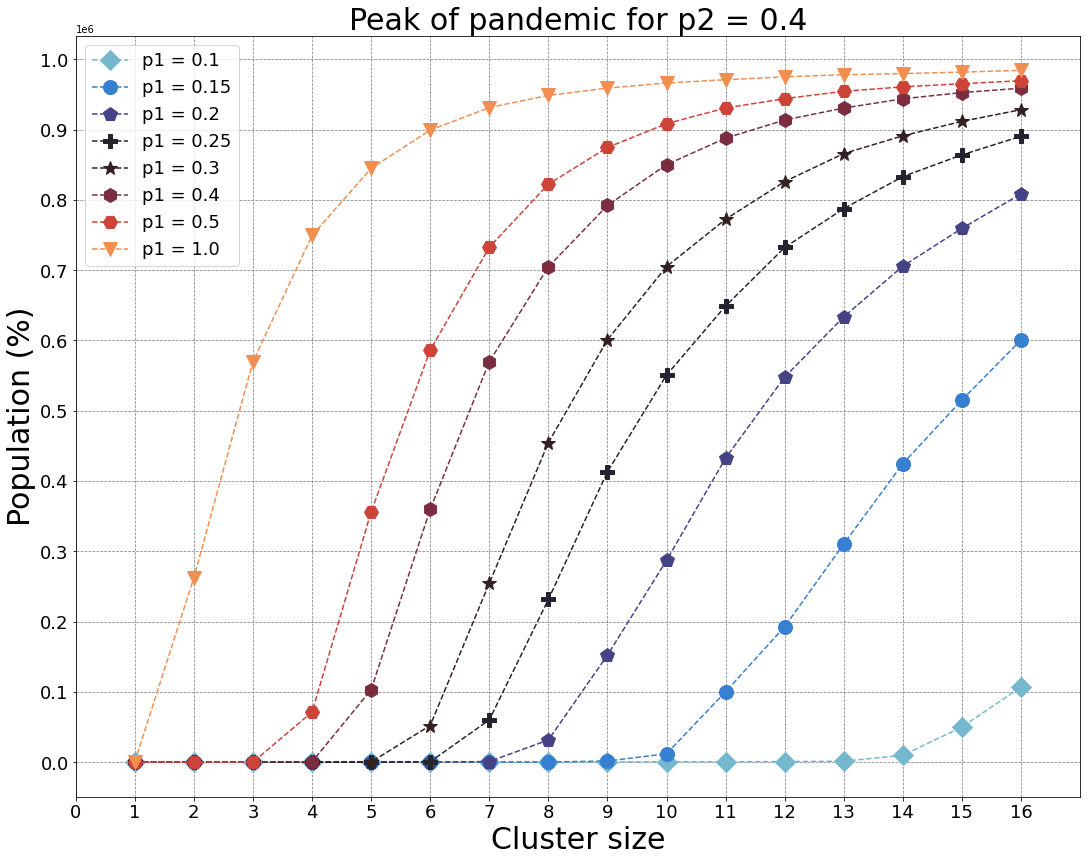

In [19]:
# cluster_dict : p1_dict : p2_dict : [seed_dict : [list of 8 elements], ratio_of_success_seeds]
        #0 first day of infectious case,1 length of pandemic (first infectious, last mild case),
        #2 peak of pandemic (max (infectious+mild+ic) ) 3 peak of pandemic known cases,
        #4 total corona deaths, 5 total no_corona deaths
        #6 n days in system overload 7 n 1st day system overload
        #8 immune people,
def get_name2(parameter):
    if parameter==0:
        name="Beginning of pandemic"
    if parameter==1:
        name="Length of pandemic"
    if parameter==2:
        name="Peak of pandemic"
    if parameter==3:
        name="Peak of pandemic (m + c)"
    if parameter==4:
        name="Total deaths (covid19 related)"
    if parameter==5:
        name="Total deaths (covid19 non-related)"
    if parameter==6:
        name="Days in system overload"
    if parameter==7:
        name="Beginning of system overload"
    if parameter==8:
        name="Total number of immune people"
    return name

def plot_help(intero):
    if intero==0:
        return "D"
    if intero==1:
        return "o"
    if intero==2:
        return "p"        
    if intero==3:
        return "P"
    if intero==4:
        return "*"
    if intero==5:
        return "h"
    if intero==6:
        return "H"
    if intero==7:
        return "v"
    if intero==8:
        return "x"
    if intero==9:
        return "X"
    if intero==10:
        return "D"


def plot_lines(cluster_dim_list,p1_list,p2,parameter,cluster_dict,save):
# cluster_dict : p1_dict : p2_dict : [seed_dict : [list of 8 elements], ratio_of_success_seeds]  
    index=0
    seed='0'    
    tic_list=[0,100000,200000,300000,400000,500000,600000,700000,800000,900000,1000000]
    p1_dict={}
    for p1 in p1_list:
        p1_pom=[]
        for cldim in cluster_dim_list:
            name=get_name2(parameter)
            p1_pom.append(cluster_dict[cldim][p1][p2][index][seed][parameter])
        p1_dict[p1]=p1_pom
    #viridis,jet,Spectral
    cmap = plt.get_cmap('icefire')
    colors = [cmap(i) for i in np.linspace(0.1, 0.9, len(p1_dict.keys()))]
    i=0
    for p1 in p1_dict:
        plt.plot(cluster_dim_list, p1_dict[p1],label="p1 = " + str(p1),marker=plot_help(i), markersize=14,
                 linestyle='--',color=colors[i])    
        i+=1
        
    figure = plt.gcf() # get current figure
    figure.set_size_inches(18, 14)
    #plt.yscale("log")
    filetitle=name+" for p2 = "+str(p2)
    plt.title(filetitle.capitalize(),fontsize=30)
    #plt.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.5)
    plt.legend(fontsize=18)
    #plt.grid(color='black', which='major',linestyle='-', linewidth=1)
    plt.grid(color='grey', which='both',linestyle='--', linewidth=0.75)
    plt.xlim(min(cluster_dim_list)-1,max(cluster_dim_list)+1)
    #plt.xticks(ticks=cluster_dim_list,fontsize=18)
    plt.xticks(np.arange(min(cluster_dim_list)-1,max(cluster_dim_list)+1,step=1),fontsize=18)
    plt.yticks(tic_list,fontsize=18)
    plt.xlabel('Cluster size',fontsize=30)
    plt.ylabel('Population (%)',fontsize=30)
    
    if save==True:
        plt.savefig('outputsBilj/paper images/'+filetitle+str(cluster_dim_list)+'.png')
        plt.close(figure)
        
mu=5 # 5, 100
k=2.5 # 1,2,5,10
extpop=0# 100,1000,10000,100000
initialpath=os.getcwd()
#initialpath="/home/dorian/Codes/covid19"
cluster_dict={}
cluster_dict_crit={}


#path_to_open="/outputs/cluster_trip_model_v2"
#path_to_open="/outputs/base_model"
#path_to_open="/outputs/superspreaders_model"
mod="base"
path_to_open="/outputs/"+mod+"_model"

cluster_dict=get_files2(initialpath,path_to_open,mu,extpop,k)
cluster_dict_crit=getfile_crit(initialpath,path_to_open,mu,extpop,k)

#cluster_dim_list=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,20,25,30,50,100]
cluster_dim_list=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
#p1_list=[0.0, 0.05,0.1]
#p1_list=[0.1,0.15,0.2,0.25,0.3,0.35, 0.4,0.45, 0.5, 0.55,0.6,0.65,0.7,0.75,0.8,0.85, 0.9,0.95,1.0]
p1_list=[0.1,0.15,0.2,0.25,0.3,0.4,0.5,1.0]
p2=0.4
parameter=2
save=False
plot_lines(cluster_dim_list,p1_list,p2,parameter,cluster_dict,save)

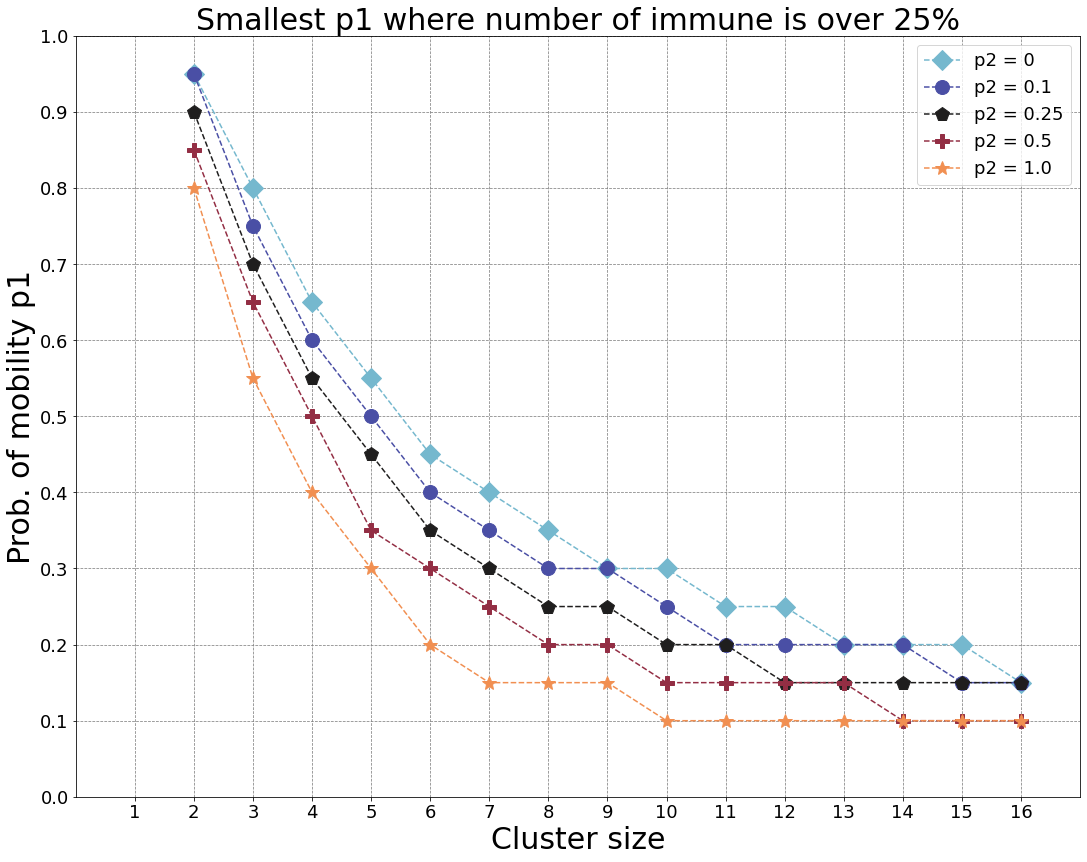

In [38]:
# cluster_dict : p1_dict : p2_dict : [seed_dict : [list of 8 elements], ratio_of_success_seeds]
        #0 first day of infectious case,1 length of pandemic (first infectious, last mild case),
        #2 peak of pandemic (max (infectious+mild+ic) ) 3 peak of pandemic known cases,
        #4 total corona deaths, 5 total no_corona deaths
        #6 n days in system overload 7 n 1st day system overload
        #8 immune people,
def plot_lines_grozd_p1_p2(cluster_dim_list,p1_list,p2_list,thresh,parameter,cluster_dict,save):
# cluster_dict : p1_dict : p2_dict : [seed_dict : [list of 8 elements], ratio_of_success_seeds]  
    index=0
    seed='0' 
    tic_list=[0,0.05,0.1,0.15,0.2,0.25,0.3,0.35, 0.4,0.45, 0.5, 0.55,0.6,0.65,0.7,0.75,0.8,0.85, 0.9,0.95,1.0]
    tic_list=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
    if len(p1_list) > 1 and len(p2_list) == 0:
        var_dict={}
        for p1 in p1_list:
            pom=[]
            for cldim in cluster_dim_list:
                name=get_name2(parameter)
                for p2 in cluster_dict[cldim][p1].keys():
                    if cluster_dict[cldim][p1][p2][index][seed][parameter]>=thresh:#maybe add something like many ppts
                        pom.append(p2)
                        break
            var_dict[p1]=pom
            #crit_bound=cluster_dict_crit[cldim]["p1_vrijednosti"]
        cmap = plt.get_cmap('icefire')
        colors = [cmap(i) for i in np.linspace(0.1, 0.9, len(var_dict.keys()))]
        i=0
        for p1 in var_dict.keys():
            plt.plot(cluster_dim_list[len(cluster_dim_list)-len(var_dict[p1]):], var_dict[p1],
                     label="p1 = " + str(p1),marker=plot_help(i),markersize=14, linestyle='--',color=colors[i])   
            i+=1
        #plt.plot(cluster_dim_list,cluster_dict_crit)
    if len(p1_list) == 0 and len(p2_list) > 1:
        var_dict={}
        for p2 in p2_list:
            pom=[]
            for cldim in cluster_dim_list:
                name=get_name2(parameter)
                for p1 in cluster_dict[cldim].keys():
                    if cluster_dict[cldim][p1][p2][index][seed][parameter]>=thresh:#maybe add something like many ppts
                        pom.append(p1)
                        break
            var_dict[p2]=pom
        cmap = plt.get_cmap('icefire')
        colors = [cmap(i) for i in np.linspace(0.1, 0.9, len(var_dict.keys()))]
        i=0
        for p2 in var_dict.keys():
            plt.plot(cluster_dim_list[len(cluster_dim_list)-len(var_dict[p2]):], var_dict[p2],
                     label="p2 = " + str(p2),marker=plot_help(i),markersize=14, linestyle='--',color=colors[i])    
            i+=1
    figure = plt.gcf() # get current figure
    figure.set_size_inches(18, 14)
    #plt.yscale("log")
    if len(p1_list) > 1 and len(p2_list) == 0:
        filetitle="Smallest p2 where number of immune is over " + str(round(100*thresh/1000000)) + '%' 
        plt.ylabel('Prob. of quarantine disobedience p2',fontsize=30)
    if len(p1_list) == 0 and len(p2_list) > 1:
        filetitle="Smallest p1 where number of immune is over " + str(round(100*thresh/1000000)) + '%' 
        plt.ylabel('Prob. of mobility p1',fontsize=30)
    plt.title(filetitle,fontsize=30)
    #plt.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.5)
    plt.legend(fontsize=18)
    #plt.grid(color='black', which='major',linestyle='-', linewidth=1)
    plt.grid(color='grey', which='both',linestyle='--', linewidth=0.75)
    plt.xlim(min(cluster_dim_list)-1,max(cluster_dim_list)+1)
    plt.xticks(ticks=cluster_dim_list,fontsize=18)
    plt.yticks(tic_list,fontsize=18)
    plt.xlabel('Cluster size',fontsize=30)


    if save==True:
        plt.savefig('outputsBilj/paper images/'+filetitle+'.png')
        plt.close(figure)
        
mu=5 # 5, 100
k=2.5 # 1,2,5,10
extpop=0# 100,1000,10000,100000
initialpath=os.getcwd()
#initialpath="/home/dorian/Codes/covid19"
cluster_dict={}
cluster_dict_crit={}


#path_to_open="/outputs/cluster_trip_model_v2"
#path_to_open="/outputs/base_model"
#path_to_open="/outputs/superspreaders_model"
mod="base"
path_to_open="/outputs/"+mod+"_model"

cluster_dict=get_files2(initialpath,path_to_open,mu,extpop,k)
cluster_dict_crit=getfile_crit(initialpath,path_to_open,mu,extpop,k)

cluster_dim_list=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
#p1_list=[0.0, 0.05,0.1]
#p1_list=[0.1,0.15,0.2,0.25,0.3,0.35, 0.4,0.45, 0.5, 0.55,0.6,0.65,0.7,0.75,0.8,0.85, 0.9,0.95,1.0]
#p1_list=[0.1,0.15,0.2,0.25,0.3,0.4,0.5,0.6,0.8,1.0]
#p2_list=[]
p1_list=[]
p2_list=[0,0.1,0.25,0.5,1.0]
parameter=8
thresh=250000
save=False
plot_lines_grozd_p1_p2(cluster_dim_list,p1_list,p2_list,thresh,parameter,cluster_dict,save)

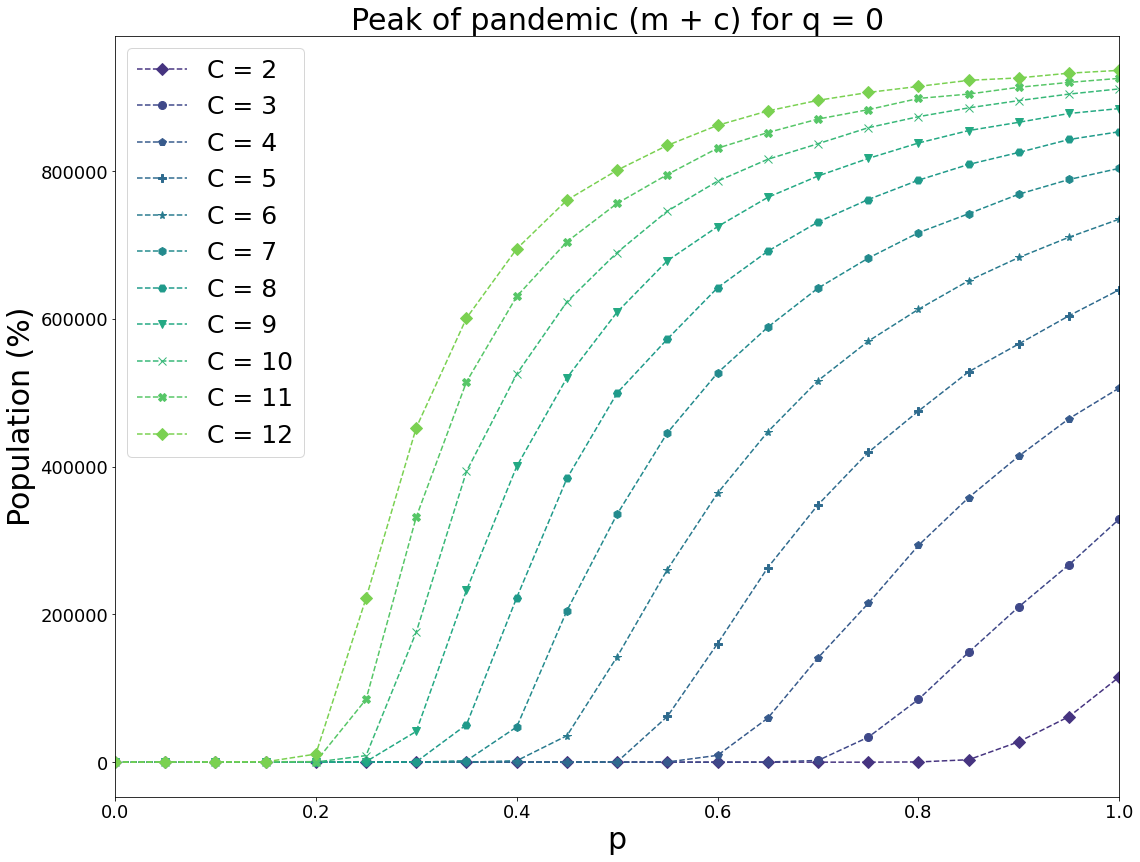

In [34]:
# cluster_dict : p1_dict : p2_dict : [seed_dict : [list of 8 elements], ratio_of_success_seeds]
        #0 first day of infectious case,1 length of pandemic (first infectious, last mild case),
        #2 peak of pandemic (max (infectious+mild+ic) ) 3 peak of pandemic known cases,
        #4 total corona deaths, 5 total no_corona deaths
        #6 n days in system overload 7 n 1st day system overload
        #8 immune people,
def get_name2(parameter):
    if parameter==0:
        name="Beginning of pandemic"
    if parameter==1:
        name="Length of pandemic"
    if parameter==2:
        name="Peak of pandemic"
    if parameter==3:
        name="Peak of pandemic (m + c)"
    if parameter==4:
        name="Total deaths (covid19 related)"
    if parameter==5:
        name="Total deaths (covid19 non-related)"
    if parameter==6:
        name="Days in system overload"
    if parameter==7:
        name="Beginning of system overload"
    if parameter==8:
        name="Total number of immune people"
    return name

def plot_help(intero):
    if intero==0:
        return "D"
    if intero==1:
        return "o"
    if intero==2:
        return "p"        
    if intero==3:
        return "P"
    if intero==4:
        return "*"
    if intero==5:
        return "h"
    if intero==6:
        return "H"
    if intero==7:
        return "v"
    if intero==8:
        return "x"
    if intero==9:
        return "X"
    if intero==10:
        return "D"


def plot_fase_jump(cluster_dim_list,p1_list,p2,parameter,cluster_dict,save):
# cluster_dict : p1_dict : p2_dict : [seed_dict : [list of 8 elements], ratio_of_success_seeds]  
    index=0
    seed='0'    
    
    cl_dict={}
    for cldim in cluster_dim_list:
        cl_pom=[]
        for p1 in p1_list:
            name=get_name2(parameter)
            cl_pom.append(cluster_dict[cldim][p1][p2][index][seed][parameter])
        cl_dict[cldim]=cl_pom
    
    cmap = plt.get_cmap('viridis')
    colors = [cmap(i) for i in np.linspace(0.15, 0.8, len(cl_dict.keys()))]
    i=0
    for cldim in cl_dict:
        plt.plot(p1_list, cl_dict[cldim],label="C = " + str(cldim),marker=plot_help(i), markersize=8,
                 linestyle='--',color=colors[i])    
        i+=1
        
    figure = plt.gcf() # get current figure
    figure.set_size_inches(18, 14)
    #plt.yscale("log")
    filetitle=name+" for q = "+str(p2)
    plt.title(filetitle.capitalize(),fontsize=30)
    #plt.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.5)
    plt.legend(fontsize=25)
    #plt.grid(color='black', which='major',linestyle='-', linewidth=1)
    plt.grid(color='grey', which='minor',linestyle='--', linewidth=0.3)
    plt.xlim(min(p1_list),max(p1_list))
    #plt.xticks(ticks=cluster_dim_list,fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.xlabel('p',fontsize=30)
    plt.ylabel('Population (%)',fontsize=30)
    
    if save==True:
        plt.savefig('outputsBilj/base/'+filetitle+str(cluster_dim_list)+'.pdf')
        plt.close(figure)
        
mu=5 # 5, 100
k=2.5 # 1,2,5,10
extpop=0# 100,1000,10000,100000
initialpath=os.getcwd()
#initialpath="/home/dorian/Codes/covid19"
cluster_dict={}
cluster_dict_crit={}


#path_to_open="/outputs/cluster_trip_model_v2"
#path_to_open="/outputs/base_model"
#path_to_open="/outputs/superspreaders_model"
mod="base"
path_to_open="/outputs/"+mod+"_model"

cluster_dict=get_files2(initialpath,path_to_open,mu,extpop,k)
cluster_dict_crit=getfile_crit(initialpath,path_to_open,mu,extpop,k)

cluster_dim_list=[2,3,4,5,6,7,8,9,10,11,12]
#p1_list=[0.0, 0.05,0.1]
#p1_list=[0.1,0.15,0.2,0.25,0.3,0.35, 0.4,0.45, 0.5, 0.55,0.6,0.65,0.7,0.75,0.8,0.85, 0.9,0.95,1.0]
p1_list=[0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1.0]
#p1_list=[0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4]
p2=0
parameter=3
save=False
plot_fase_jump(cluster_dim_list,p1_list,p2,parameter,cluster_dict,save)

Scaled total covid19 deaths (%) for Within Capacity: 95% quantile = 517.0, 99% quantile = 613.4000000000001
Scaled total covid19 deaths (%) for Within + Over Capacity: 5% quantile = 10792.160000000002, 1% quantile = 26.29
Scaled total covid19 deaths (%) max = 34184


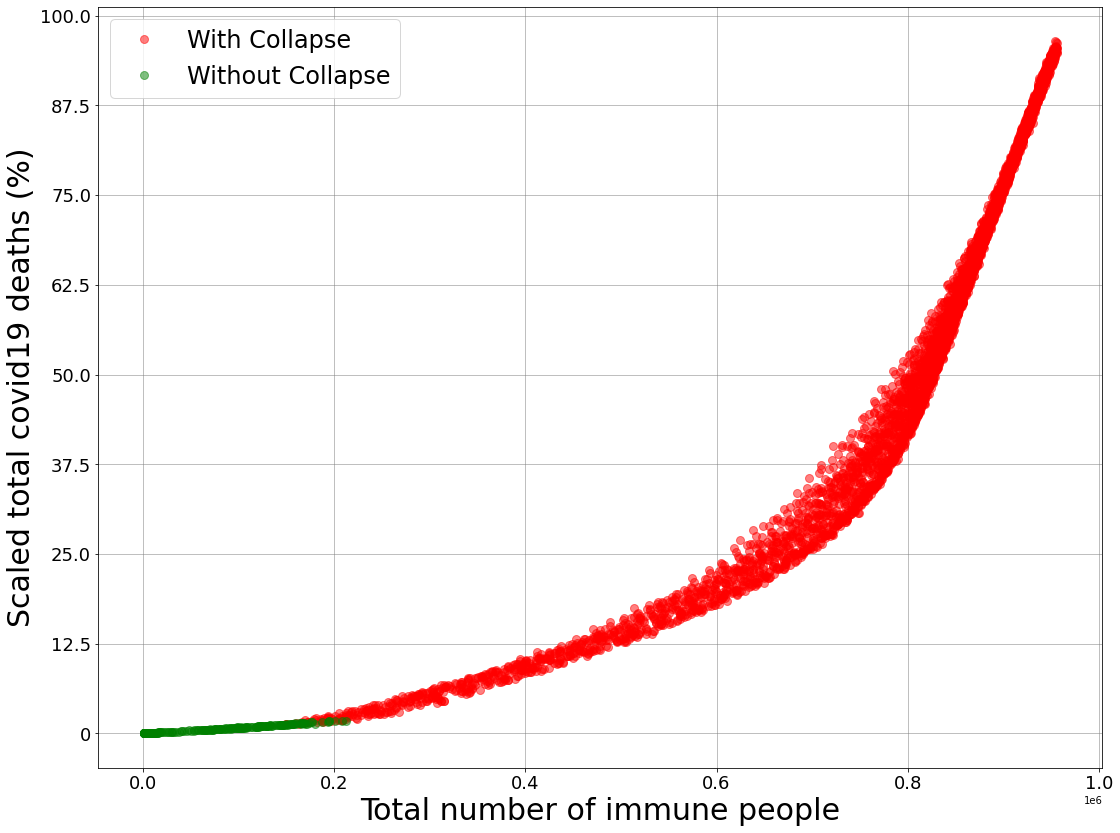

In [58]:
# cluster_dict : p1_dict : p2_dict : [seed_dict : [list of 8 elements], ratio_of_success_seeds]
        #0 first day of infectious case,1 length of pandemic (first infectious, last mild case),
        #2 peak of pandemic (max (infectious+mild+ic) ) 3 peak of pandemic known cases,
        #4 total corona deaths, 5 total no_corona deaths
        #6 n days in system overload 7 n 1st day system overload
        #8 immune people,
def get_name2(parameter):
    if parameter==0:
        name="Beginning of pandemic"
    if parameter==1:
        name="Length of pandemic"
    if parameter==2:
        name="Peak of pandemic"
    if parameter==3:
        name="Peak of pandemic (m + c)"
    if parameter==4:
        name="Total covid19 deaths"
    if parameter==5:
        name="Total deaths (covid19 non-related)"
    if parameter==6:
        name="Days in system overload"
    if parameter==7:
        name="Beginning of system overload"
    if parameter==8:
        name="Total number of immune people"
    return name

def plot_2d(cluster_dim_list,parameter_x,parameter_y,cluster_dict,save,mod):
# cluster_dict : p1_dict : p2_dict : [seed_dict : [list of 8 elements], ratio_of_success_seeds]  
    index=0
    seed='0'    
    colapsx=[]
    colapsy=[]
    nocolapsx=[]
    nocolapsy=[]
    for cldim in cluster_dim_list:
        for p1 in cluster_dict[cldim].keys():
            for p2 in cluster_dict[cldim][p1].keys():
                if cluster_dict[cldim][p1][p2][index][seed][4]>9:
                    if parameter_y<9:
                        namex=get_name2(parameter_x)
                        namey=get_name2(parameter_y)
                        namey="Scaled total covid19 deaths (%)"
                        if cluster_dict[cldim][p1][p2][index][seed][6]>0:
                            colapsx.append(cluster_dict[cldim][p1][p2][index][seed][parameter_x]) 
                            colapsy.append(cluster_dict[cldim][p1][p2][index][seed][parameter_y])
                                          #/cluster_dict[cldim][p1][p2][index][seed][1])
                        else:
                            nocolapsx.append(cluster_dict[cldim][p1][p2][index][seed][parameter_x]) 
                            nocolapsy.append(cluster_dict[cldim][p1][p2][index][seed][parameter_y])
                                            #/cluster_dict[cldim][p1][p2][index][seed][1])
                    if parameter_y==9:
                        namex=get_name2(parameter_x)
                        namey="Total number of cases"
                        if cluster_dict[cldim][p1][p2][index][seed][6]>0:
                            colapsx.append(cluster_dict[cldim][p1][p2][index][seed][parameter_x]) 
                            colapsy.append(cluster_dict[cldim][p1][p2][index][seed][8]+
                                           cluster_dict[cldim][p1][p2][index][seed][4])
                        else:
                            nocolapsx.append(cluster_dict[cldim][p1][p2][index][seed][parameter_x]) 
                            nocolapsy.append(cluster_dict[cldim][p1][p2][index][seed][8]+
                                             cluster_dict[cldim][p1][p2][index][seed][4])
    print(namey+ " for Within Capacity: 95% quantile = {}, 99% quantile = {}".format(np.quantile(nocolapsy,0.95),
                                                                                    np.quantile(nocolapsy,0.99)))
    
    print(namey+ " for Within + Over Capacity: 5% quantile = {}, 1% quantile = {}".format(np.quantile(nocolapsy+
                                                            colapsy,0.26),np.quantile(nocolapsy+colapsy,0.01)))
    print(namey+ " max = {}".format(max(nocolapsy+colapsy)))
    plt.plot(colapsx,colapsy,"ro", markersize=8,color="red",label="With Collapse",alpha=0.5)
    plt.plot(nocolapsx,nocolapsy,"ro", markersize=8,color="green",label="Without Collapse",alpha=0.5)  
         
    figure = plt.gcf() # get current figure
    figure.set_size_inches(18, 14)
    #plt.yscale("log")
    filetitle=mod+namex+namey
    #plt.title(filetitle.capitalize(),fontsize=30)
    #plt.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.5)
    plt.legend(fontsize=24)
    #plt.grid(color='black', which='major',linestyle='-', linewidth=1)
    plt.grid(color='grey', which='both',linestyle='-', linewidth=0.5)
    #plt.xlim(min(p1_list),max(p1_list))
    plt.yticks(ticks=[0,4432,4432*2,4432*3,4432*4,4432*5,4432*6,4432*7,4432*8],
               labels=[0,12.5,12.5*2,12.5*3,12.5*4,12.5*5,12.5*6,12.5*7,12.5*8],fontsize=18)
    plt.xticks(fontsize=18)
    #plt.yticks(fontsize=15)
    plt.xlabel(namex,fontsize=30)
    plt.ylabel(namey,fontsize=30)
    #plt.xscale("log")
    #plt.yscale("log")

    if save==True:
        plt.savefig('outputsBilj/base/'+"scatterplot_"+filetitle+str(cluster_dim_list)+"1"+'.png')
        plt.close(figure)
        
mu=5 # 5, 100
k=2.5 # 1,2,5,10
extpop=280000# 100,1000,10000,100000
initialpath=os.getcwd()
#initialpath="/home/dorian/Codes/covid19"
cluster_dict={}
cluster_dict_crit={}


#path_to_open="/outputs/cluster_trip_model_v2"
#path_to_open="/outputs/base_model"
#path_to_open="/outputs/superspreaders_model"
mod="domovi"
path_to_open="/outputs/"+mod+"_model"

cluster_dict=get_files2(initialpath,path_to_open,mu,extpop,k)
cluster_dict_crit=getfile_crit(initialpath,path_to_open,mu,extpop,k)

cluster_dim_list=[2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
#cluster_dim_list=[10,11,12,13,14,15]
#cluster_dim_list=[10]
#cluster_dim_list=[2]
        #0 first day of infectious case,1 length of pandemic (first infectious, last mild case),
        #2 peak of pandemic (max (infectious+mild+ic) ) 3 peak of pandemic known cases,
        #4 total corona deaths, 5 total no_corona deaths
        #6 n days in system overload 7 n 1st day system overload
        #8 immune people,
parameter_x=8 # x = 4 and y = 9 interesting
parameter_y=4
save=False
plot_2d(cluster_dim_list,parameter_x,parameter_y,cluster_dict,save,mod)

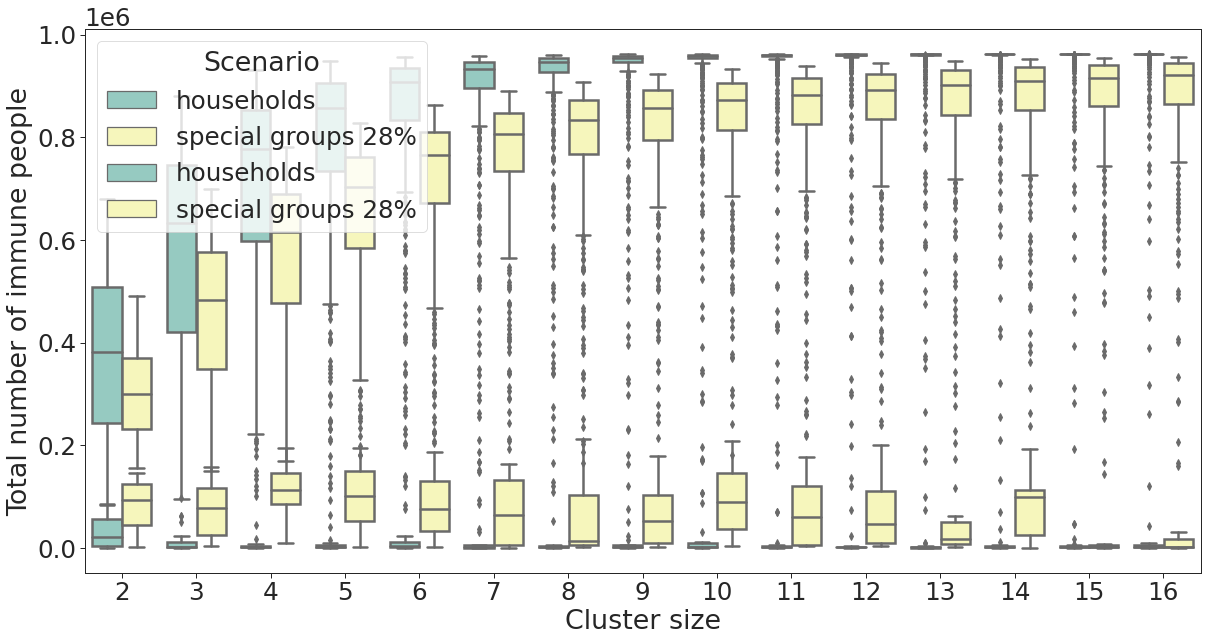

In [509]:
##### cluster_dict : p1_dict : p2_dict : [seed_dict : [list of 8 elements], ratio_of_success_seeds]
        #0 first day of infectious case,1 length of pandemic (first infectious, last mild case),
        #2 peak of pandemic (max (infectious+mild+ic) ) 3 peak of pandemic known cases,
        #4 total corona deaths, 5 total no_corona deaths
        #6 n days in system overload 7 n 1st day system overload
        #8 immune people,
def data_frame_for_boxplot(cluster_dim_list,parameter_y,mod_list,mod_list1,extpop_list,save):
# cluster_dict : p1_dict : p2_dict : [seed_dict : [list of 8 elements], ratio_of_success_seeds]  
    mu=5 # 5, 100
    k=2.5 # 1,2,5,10
    initialpath=os.getcwd()
    colapsy=[]
    nocolapsy=[]
    cldim_frame_col=[]
    cldim_frame_nocol=[]
    modlist_frame_col=[]
    modlist_frame_nocol=[]
    for i in range(len(mod_list)):
        path_to_open="/outputs/"+mod_list[i]+"_model"
        cluster_dict={}
        cluster_dict=get_files2(initialpath,path_to_open,mu,extpop_list[i],k)
        index=0
        seed='0'    
        for cldim in cluster_dim_list:
            for p1 in cluster_dict[cldim].keys():
                for p2 in cluster_dict[cldim][p1].keys():
                    if cluster_dict[cldim][p1][p2][index][seed][4]>9:
                        namey=get_name2(parameter_y)
                        #namey="Average covid19 deaths per day"
                        if cluster_dict[cldim][p1][p2][index][seed][6]>0:
                            colapsy.append(cluster_dict[cldim][p1][p2][index][seed][parameter_y])
                                           #/cluster_dict[cldim][p1][p2][index][seed][1])
                            cldim_frame_col.append(cldim)
                            modlist_frame_col.append(mod_list1[i])
                        else:
                            nocolapsy.append(cluster_dict[cldim][p1][p2][index][seed][parameter_y])
                                             #/cluster_dict[cldim][p1][p2][index][seed][1])
                            cldim_frame_nocol.append(cldim)
                            modlist_frame_nocol.append(mod_list1[i])
                            
    percentile_list_col = pd.DataFrame({'Scenario':modlist_frame_col,'Cluster size': cldim_frame_col,namey: colapsy})
    percentile_list_nocol = pd.DataFrame({'Scenario':modlist_frame_nocol,'Cluster size': cldim_frame_nocol,namey: nocolapsy})
    #sns.boxplot(x="C. size", y=namey, hue="Scenario",data=percentile_list_col , palette="Set3")
    sns.set_theme(style="ticks")
    sns.set_context("paper", font_scale=2.8)   
    
    plot1=sns.boxplot(x="Cluster size", y=namey, hue="Scenario",data=percentile_list_col , palette="Set3",linewidth=2.5)
    fig1 = plot1.get_figure()
    #sns.pairplot(hue="Scenario",data=percentile_list_col , palette="Set3")
    if save==True:
        fig1.savefig('outputsBilj/base/'+"boxplot"+"_colapse_"+namey+str(cluster_dim_list)+str(mod_list)+'.png')
        plt.close(fig1)
        
    plot2=sns.boxplot(x="Cluster size", y=namey, hue="Scenario",data=percentile_list_nocol , palette="Set3",linewidth=2.5)
    fig2 = plot2.get_figure()
    if save==True:
        fig2.savefig('outputsBilj/base/'+"boxplot"+"_nocolapse_"+namey+str(cluster_dim_list)+str(mod_list)+'.png')
        plt.close(fig2) 

#path_to_open="/outputs/cluster_trip_model_v2"
#path_to_open="/outputs/base_model"
#path_to_open="/outputs/superspreaders_model"
mod_list=["base","domovi","superspreaders"]
mod_list1=["households","special groups 28%","super-spreaders 0.2%"]
mod_list=["base","domovi"]
mod_list1=["households","special groups 28%"]
#extpop_list=[0,280000,2000]
extpop_list=[0,280000]
path_to_open="/outputs/"+mod+"_model"
#cluster_dim_list=[2,4,6,8,10]
cluster_dim_list=[2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
#cluster_dim_list=[2]
        #0 first day of infectious case,1 length of pandemic (first infectious, last mild case),
        #2 peak of pandemic (max (infectious+mild+ic) ) 3 peak of pandemic known cases,
        #4 total corona deaths, 5 total no_corona deaths
        #6 n days in system overload 7 n 1st day system overload
        #8 immune people,
parameter_y=8
save=False
#sns.set(rc={'figure.figsize':(20,10)},font_scale=1.5) 
data_frame_for_boxplot(cluster_dim_list,parameter_y,mod_list,mod_list1,extpop_list,save)

In [80]:
mod_list=["base","domovi","superspreaders"]
for i in range(len(mod_list)):
    cldim_frame_col=[]
    cldim_frame_col.append(mod_list[i])
cldim_frame_col

['domovi', 'superspreaders']

In [50]:
    figure = plt.gcf() # get current figure
    figure.set_size_inches(18, 14)
    #plt.yscale("log")
    filetitle=mod+namex+namey
    #plt.title(filetitle.capitalize(),fontsize=30)
    #plt.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.5)
    plt.legend(fontsize=30)
    #plt.grid(color='black', which='major',linestyle='-', linewidth=1)
    plt.grid(color='grey', which='minor',linestyle='--', linewidth=0.3)
    #plt.xlim(min(p1_list),max(p1_list))
    #plt.xticks(ticks=cluster_dim_list,fontsize=18)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel(namex,fontsize=30)
    plt.ylabel(namey,fontsize=30)
    #plt.xscale("log")
    plt.yscale("log")
    
    if save==True:
        plt.savefig('outputsBilj/base/'+filetitle+str(cluster_dim_list)+'.pdf')
        plt.close(figure)

TypeError: 'list' object cannot be interpreted as an integer

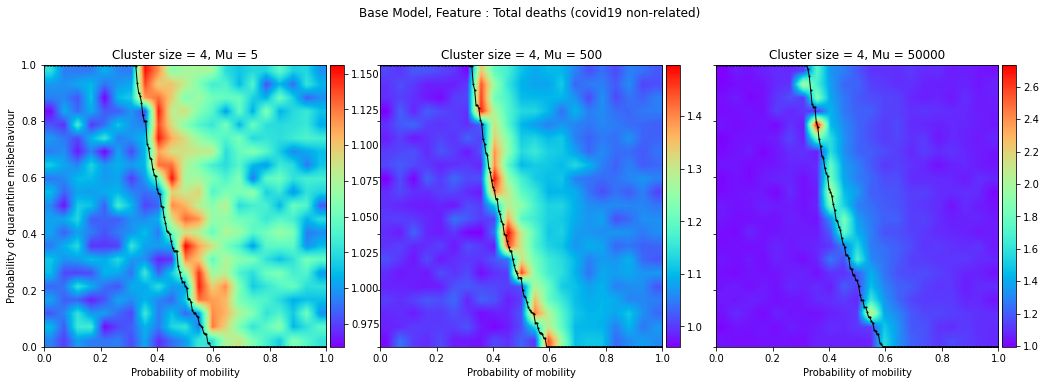

In [190]:
def grid_mu_plot(cluster_dim,parameter,mu_list,k,type_ext,type_grid,interpolation,save,sx,plot_type,extpop):
    #cnt=0
    initialpath=os.getcwd()
    #initialpath="/home/dorian/Codes/covid19"
    path_to_open="/outputs/"+type_ext+"_model"
    list_cluster_dict=[]
    list_cluster_dict_crit=[]
    for mu in mu_list:
        list_cluster_dict.append(get_files2(initialpath,path_to_open,mu,extpop,k))
        list_cluster_dict_crit.append(getfile_crit(initialpath,path_to_open,mu,extpop,k))

    name=get_name(parameter)
    
    title_plot=("Base" + " Model, Feature : " + name) 

    file_title=(type_ext.capitalize() 
                + " Model : " + name
                + ", K = {}".format(k)
                + ' , MU = {}'.format(mu)
                + ', Grid by : {}'.format(type_grid.capitalize()) 
                + ', plot : {}'.format(plot_type)) 
    
    #sx=2
    #sy=2
    fig, ax = plt.subplots(nrows=1,ncols=sx, sharex='col', sharey='row',figsize=(15, 6))
    fig.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.99, wspace=0.12,hspace = 0.05)
    fig.suptitle(title_plot)
    for i in range(sx):
        #cnt=cnt+1
        out=arange_plot(cluster_dim[0],parameter,list_cluster_dict[i],
                        list_cluster_dict_crit[i],plot_type)
        p1_crit=out[0]
        p2_crit=out[1]
        implista_np=out[4]
        #implista_np=np.log10(implista_np)
        array=out[5]/2660
        
        #plt.clim(math.floor(min(implista_np)), math.ceil(max(implista_np)))
        #'inferno'
        #'rainbow'
        im=ax[i].imshow(array,interpolation="bilinear",cmap='rainbow',origin="lower",extent=[0,1,0,1])
                        #clim=(2000,7250))
        ax[i].plot(p1_crit, p2_crit, color="black", marker='o', linestyle='solid',linewidth=1, 
                          markersize=1)
        divider = make_axes_locatable(ax[i])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')
        
        ax[i].set_title("Cluster size = {}".format(cluster_dim[0]) + ", Mu = {}".format(mu_list[i]))
        if i==0:
            ax[i].set_ylabel('Probability of quarantine misbehaviour')

        ax[i].set_xlabel('Probability of mobility')
        
    if save==True:            
        plt.savefig("outputsBilj/"+type_ext+"/"+file_title+str(cluster_dim)+str(mu_list)+'.png')
        
mu_list=[5,500,50000] # 5, 100
k=2.5 # 1,2,5,10 # 1,2,5 has mistakes,... all population <60
cluster_dict={}
cluster_dict_crit={}
clustdim=[4]
extpop=0
type_ext="base" # "superspreaders","base","domovi"
type_grid="cluster" #"extpop" ,"cluster"
interpolation=1 # 1 is interpolated, 0 is scatter plot
save=False
plot_type="nlog" #log
sx=3
parameter=5
#sy=3 # grid dimensions


grid_mu_plot(clustdim,parameter,mu_list,k,type_ext,type_grid,interpolation,save,sx,plot_type,extpop)

Domovi Total deaths (covid19 related)_Length of pandemicnlog[4][5000, 10000, 100000, 280000]


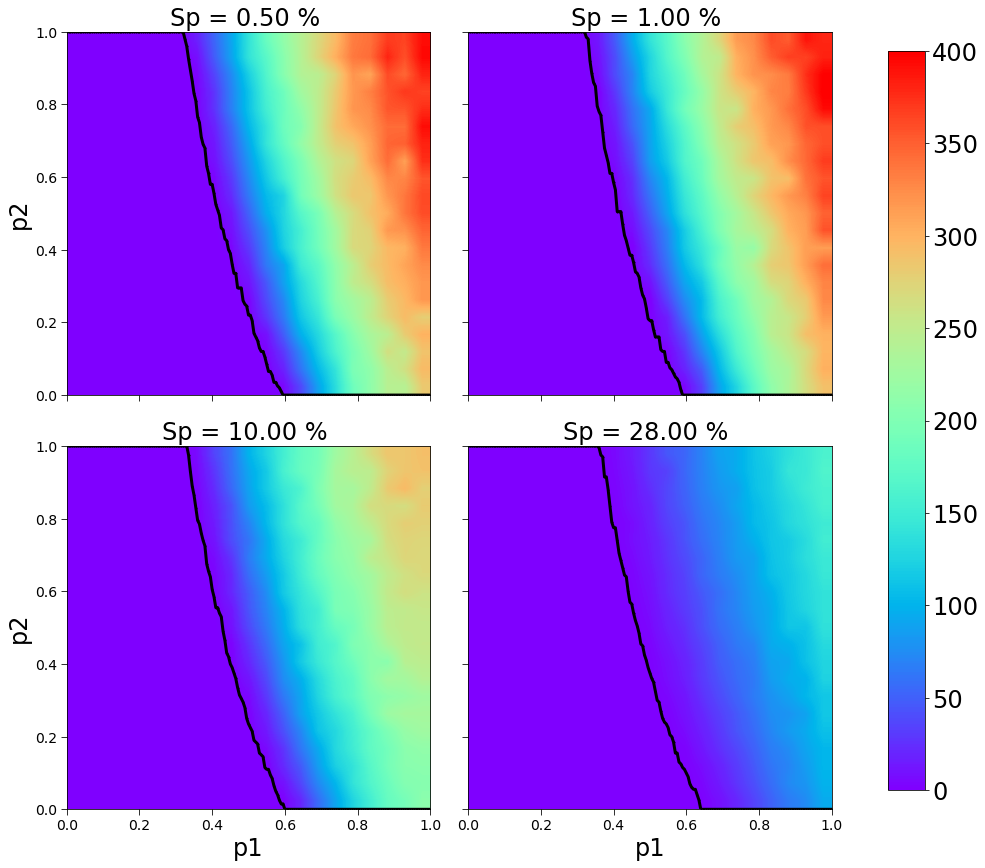

In [193]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

def grid_grid_plot(cluster_dim,parameter,parameter2,mu,k,extpop_list,type_ext,type_grid,interpolation,save,sx,sy,plot_type):
    #cnt=0
    initialpath=os.getcwd()
    #initialpath="/home/dorian/Codes/covid19"
    path_to_open="/outputs/"+type_ext+"_model"
    list_cluster_dict=[]
    list_cluster_dict_crit=[]
    for extpop in extpop_list:
        list_cluster_dict.append(get_files2(initialpath,path_to_open,mu,extpop,k))
        list_cluster_dict_crit.append(getfile_crit(initialpath,path_to_open,mu,extpop,k))

    name=get_name(parameter)
    
    title_plot=(type_ext.capitalize() + " Model, Feature : " + name) 
    if parameter2>0:
        file_title=(type_ext.capitalize()+" " + get_name2(parameter) + "_" + get_name2(parameter2) + plot_type +
                    str(cluster_dim)+str(extpop_list)) 
    else:
        file_title=(type_ext.capitalize()+" " + get_name2(parameter)+plot_type+str(cluster_dim)+str(extpop_list)) 
    print(file_title)
    #sx=2
    #sy=2
    fig, ax = plt.subplots(sx, sy, sharex='col', sharey='row',figsize=(16, 12))
    if interpolation == 0:
        fig.subplots_adjust(left=0.01, bottom=0.06, right=0.99, top=0.96, wspace=0.15,hspace = 0.12)
    if interpolation == 1:
        fig.subplots_adjust(left=0.01, bottom=0.06, right=0.99, top=0.96, wspace=-0.20,hspace = 0.14)#0.12
    #fig.suptitle(title_plot)
    for i in range(sx):
        for j in range(sy):
            #cnt=cnt+1
            if type_grid=="extpop":
                out=arange_plot(cluster_dim[0],parameter,list_cluster_dict[sy*i+j],
                                list_cluster_dict_crit[sy*i+j],plot_type)
            if type_grid=="cluster":
                out=arange_plot(cluster_dim[sy*i+j],parameter,list_cluster_dict[0],
                                list_cluster_dict_crit[0],plot_type)
            if parameter2>0:
                if type_grid=="extpop":
                    out2=arange_plot(cluster_dim[0],parameter2,list_cluster_dict[sy*i+j],
                                    list_cluster_dict_crit[sy*i+j],plot_type)
                if type_grid=="cluster":
                    out2=arange_plot(cluster_dim[sy*i+j],parameter2,list_cluster_dict[0],
                                    list_cluster_dict_crit[0],plot_type)
            p1_crit=out[0]
            p2_crit=out[1]
            implista_np=out[4]
            #implista_np=np.log10(implista_np)
            if parameter2>0:
                array=out[5]/out2[5]
            else:
                array=out[5]
            #print(type(array))
            #cmap = plt.get_cmap('viridis')
            cmap = plt.get_cmap('rainbow')
            #cmap = plt.get_cmap('Spectral')
            #cmap = plt.get_cmap('jt')
            #cmap = plt.get_cmap('Spectral_r')
            #new_cmap = truncate_colormap(cmap, 0.05, 1)
            #cmap = plt.get_cmap('nipy_spectral')
            #new_cmap = ListedColormap(truncate_colormap(cmap, 0, 1).colors[::-1])
            #cmap = plt.get_cmap('Spectral')
            #cmap = plt.get_cmap('nipy_spectral')
            new_cmap = truncate_colormap(cmap, 0, 1)
            if interpolation==1:         
                im=ax[i, j].imshow(array,interpolation="bilinear",cmap=new_cmap,origin="lower",extent=[0,1,0,1]
                                  ,vmin=0,vmax=400)
                                  #,clim=(0,30000))
                major_ticks = np.arange(0, 1.01, 0.2)
                ax[i, j].set_xticks(major_ticks)
                ax[i, j].set_yticks(major_ticks)
                ax[i, j].tick_params(labelsize=14,size=6)
                #ax[i, j].set_xlabel(fontsize=15)
                #ax[i, j].set_ylabel(fontsize=15)
                # 'Greens'
                #if i<2 or j<2:
                ax[i, j].plot(p1_crit, p2_crit, color="black", marker='o', linestyle='solid',linewidth=3, 
                              markersize=1)
            else:
                p1_list_np=out[2]
                p2_list_np=out[3]

                major_ticks = np.arange(0, 1.01, 0.1)
                minor_ticks = np.arange(0, 1.01, 0.05)
                ax[i, j].set_xticks(major_ticks,fontsize=20)
                ax[i, j].set_xticks(minor_ticks, minor=True)
                ax[i, j].set_yticks(major_ticks,fontsize=20)
                ax[i, j].set_yticks(minor_ticks, minor=True)

                ax[i, j].plot(p1_crit, p2_crit, color="black", marker='o', linestyle='solid',linewidth=1, 
                              markersize=1)
                #implista_np=np.log10(implista_np)
                # 'rainbow', 'viridis' , 'inferno'
                cmap = plt.get_cmap('Spectral')
                new_cmap = truncate_colormap(cmap, 0.05, 1)
                im=ax[i, j].scatter(p1_list_np, p2_list_np, label=None,
                c=implista_np, cmap=new_cmap , linewidth=12, alpha=5) #cmap='Accent' good alpha=5 #rainbow
            

            #divider = make_axes_locatable(ax[i, j])
            #cax = divider.append_axes('right', size='5%', pad=0.05)
            #cbar=fig.colorbar(im, cax=cax, orientation='vertical')
            #for t in cbar.ax.get_yticklabels():
            #    t.set_fontsize(18) 

                                     
            if type_grid=="extpop":
                index1=sy*i+j
                index2=0
            if type_grid=="cluster":
                index1=0
                index2=sy*i+j      
            e=float(extpop_list[index1])/10000
            if type_grid=="cluster":
                ax[i, j].set_title("Cluster size = {}".format(cluster_dim[index2]),fontsize=24,fontname="Arial")
            else:
                ax[i, j].set_title("Sp = {:.2f} % ".format(e),fontsize=24)
            if j==0:
                ax[i, j].set_ylabel('p2',fontsize=24)
            if i==sx-1:
                ax[i, j].set_xlabel('p1',fontsize=24)
    cbar = fig.colorbar(im, ax=ax.ravel().tolist(), shrink=0.95)
    for t in cbar.ax.get_yticklabels():
        t.set_fontsize(24) 
    
    if save==True:            
        plt.savefig("outputsBilj/paper images/"+file_title+'.png')
# cluster_dict : p1_dict : p2_dict : [seed_dict : [list of 8 elements], ratio_of_success_seeds]
        #0 first day of infectious case,1 length of pandemic (first infectious, last mild case),
        #2 peak of pandemic (max (infectious+mild+ic) ) 3 peak of pandemic known cases (max (mild+ic)),
        #4 total corona deaths, 5 total no_corona deaths
        #6 number days in system overload ,7 first day system overload ,
        #8 nocorona death increase, 9 percentage immunity

mu=5 # 5, 100
k=2.5 # 1,2,5,10 # 1,2,5 has mistakes,... all population <60
#extpop_list=[2000,1000,2000,10000] # [100],1000,10000,100000
#extpop_list=[8000,9000,10000,100000]
#extpop_list=[8000,8400,8800,9200,9400,9600,9800,10000,11000,12000,13000,50000,100000]
#extpop_list=[1000,2000,3000,4000,5000,6000,7000,8000,10000]
#extpop_list=[8200,8600,9000,10000,11000,12000,13000,14000,15000]
#extpop_list=[2000]
#extpop_list=[280000]
extpop_list=[5000,10000,100000,280000]
cluster_dict={}
cluster_dict_crit={}
#clustdim=[2,3,9,10]
#clustdim=[2,3,4,5]

#clustdim=[2,3,4,5,6,7,8,9,10]
clustdim=[4]
#clustdim=[2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,25]
#clustdim=[4,6,8,10]
#clustdim=[5,10,15,20]
#clustdim=[4,5,6,7,8,10,12,14,15]
control_par=4
control_par2=1
type_ext="domovi" # "superspreaders","base","domovi"
type_grid="extpop" #"extpop" ,"cluster"
interpolation=1 # 1 is interpolated, 0 is scatter plot
save=True
plot_type="nlog" #log #nlog
sx=2
sy=2 # grid dimensions


grid_grid_plot(clustdim,control_par,control_par2,mu,k,extpop_list,type_ext,type_grid,interpolation,save,sx,sy,plot_type)
#b=grid_grid_plot(clustdim,control_par,mu,k,extpop_list,type_ext,type_grid,interpolation,save,sx,sy,plot_type)

# Plot PHASES CROATIA

In [ ]:
def croatia_random_walk(stringency_croatia_float,p2,init,delta):
    seed=20 #choose seed
    np.random.seed(seed)
    december19=0
    january=31
    february=january + 29
    march=february + 31
    april=march + 30
    may=april+31
    june=may+30
    july=june+31
    august=july+31
    september=august+30
    october=september+31
    november=october+30
    december=november+31
    january21=december+31
    february21=january21+28
    march21=february21+25
    months_end=[december19,january,february,march,april,may,june,july,august,september,october,november,december,
               january21,february21,march21]
    p1_cro=[]
    p2_cro=[]
    i=0
    stringency_zone=stringency_croatia_float[months_end[init]:months_end[init+delta]]
    for index in stringency_zone:
        p1=1-(index)/100
        if i % 1 == 0:
            s = np.random.normal(p2,0.05)
            while s<0 or s>1:
                s = np.random.normal(p2,0.05)
            f = np.random.normal(p1,0.025)
            while f<0 or f>1:
                f = np.random.normal(p1,0.025)
        p2_cro.append(s)
        p1_cro.append(f)
        i+=1
    return [p1_cro,p2_cro]

Croatia_random_walk1_2
No data about precise critical boundary Cl_size3
No data about precise critical boundary Cl_size3


<Figure size 1152x864 with 0 Axes>

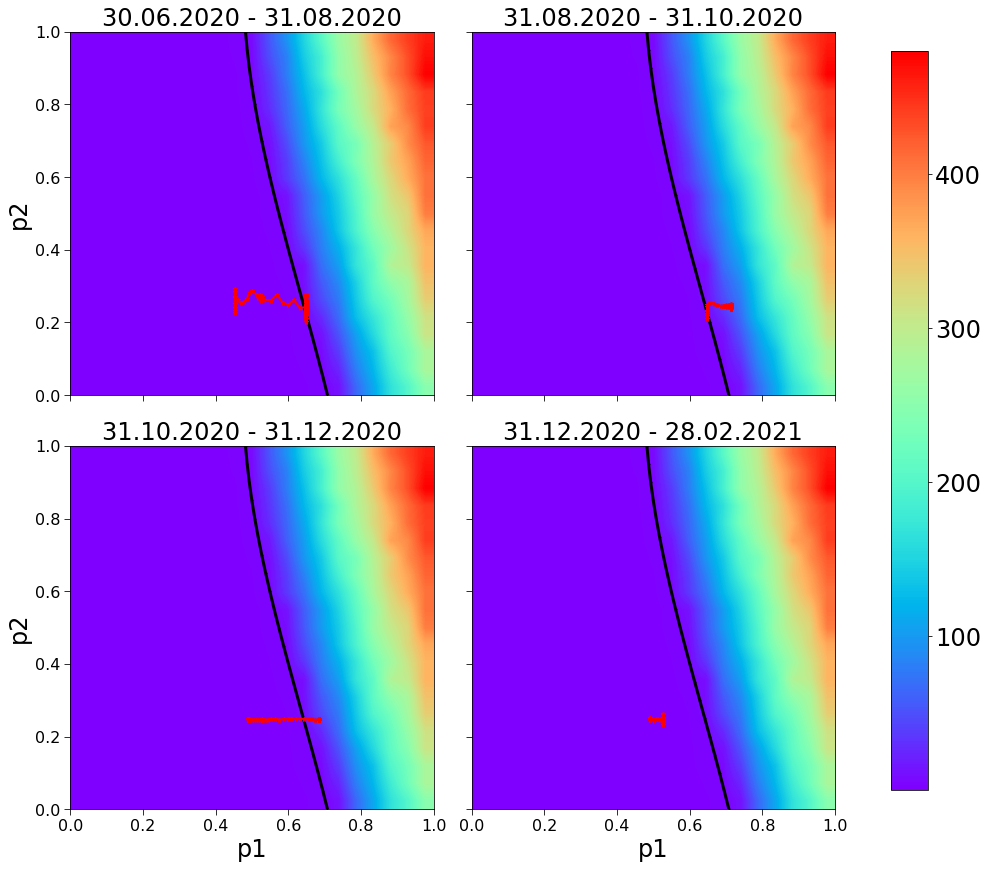

In [277]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

def grid_grid_plot_croatia(cluster_dim,parameter,parameter2,mu,k,extpop_list,type_ext,type_grid,interpolation,
                           save,sx,sy,plot_type,stringency,p2_par):
    #cnt=0
    initialpath=os.getcwd()
    #print(initialpath)
    #initialpath="/home/dorian/Codes/covid19"
    path_to_open="/outputs/"+type_ext+"_croat" #"_model" ili "_croat"
    list_cluster_dict=[]
    list_cluster_dict_crit=[]
    for extpop in extpop_list:
        list_cluster_dict.append(get_files2(initialpath,path_to_open,mu,extpop,k))
        list_cluster_dict_crit.append(getfile_crit(initialpath,path_to_open,mu,extpop,k))

    name=get_name(parameter)
    
    title_plot=(type_ext.capitalize() + " Model, Feature : " + name) 
    file_title=("Croatia_random_walk1_2")
    print(file_title)
    figure = plt.gcf() # get current figure
    figure.set_size_inches(16, 12)
    fig, ax = plt.subplots(sx, sy, sharex='col', sharey='row',figsize=(16, 12))
    if interpolation == 0:
        fig.subplots_adjust(left=0.01, bottom=0.06, right=0.99, top=0.96, wspace=0.15,hspace = 0.12)
    if interpolation == 1:
        fig.subplots_adjust(left=0.01, bottom=0.06, right=0.99, top=0.96, wspace=-0.2,hspace = 0.14)#0.12
    #fig.suptitle(title_plot)
    if type_grid=="extpop":
        out=arange_plot(cluster_dim[0],parameter,list_cluster_dict[0],
                        list_cluster_dict_crit[0],plot_type)
    if type_grid=="cluster":
        out=arange_plot(cluster_dim[0],parameter,list_cluster_dict[0],
                        list_cluster_dict_crit[0],plot_type)
    if parameter2>0:
        if type_grid=="extpop":
            out2=arange_plot(cluster_dim[0],parameter2,list_cluster_dict[0],
                            list_cluster_dict_crit[0],plot_type)
        if type_grid=="cluster":
            out2=arange_plot(cluster_dim[0],parameter2,list_cluster_dict[0],
                            list_cluster_dict_crit[0],plot_type)
    p1_crit=out[0]
    p2_crit=out[1]
    implista_np=out[4]
    #implista_np=np.log10(implista_np)
    if parameter2>0:
        with open('/home/dorian/Codes/covid19/outputs/base_croat/Base_real_grid_search_series_k_trip2.5_mu5_cluster_size3.json') as json_file:
            series = json.load(json_file)
        seed="0"
        p1="0.0"
        length_arr_cro = np.zeros((21,21))
        for p2 in series[p1].keys():
            for p1 in series.keys():
                a=min([idx for idx, element in enumerate(series[p1][p2][seed]['dead']) 
                       if element>0.95*series[p1][p2][seed]['dead'][-1]])
                length_arr_cro[int(float(p2)*20)][int(float(p1)*20)]=a
        array=out[5]*10/length_arr_cro
        #array=out[5]*10/out2[5]
    else:
        array=out[5]*10
    #print(array)
    p1_crit2=[0.47,0.5,0.5,0.5,0.5,0.5,0.55,0.55,0.55,0.55,0.55,0.6,0.6,0.6,0.65,0.65,0.65,0.65,0.7,0.7,0.7]
    p2_crit2=[1,0.95,0.9,0.85,0.8,0.75,0.7,0.65,0.6,0.55,0.5,0.45,0.4,0.35,0.3,0.25,0.2,0.15,0.1,0.05,0]
    p1_crit2_filt = savgol_filter(p1_crit2, 21, 3)
    p2_crit2_filt = savgol_filter(p2_crit2, 21, 3)
    cmap = plt.get_cmap('rainbow')
    #cmap = plt.get_cmap('jet')
    #cmap = plt.get_cmap('viridis')
    new_cmap = truncate_colormap(cmap, 0, 1)
                                   
    #init_list=[0,2,4,6,-1]
    init_list=[6,8,10,12,-1]
    #delta_list=[2,2,2,2]
    #delta_list=[2,2,2,2]
    delta=2
    a=0
    init=init_list[a]
    for i in range(sx):
        for j in range(sy):    
            im=ax[i, j].imshow(array,interpolation="bilinear",cmap=new_cmap,origin="lower",extent=[0,1,0,1])
                              #clim=(0,30000))
            major_ticks = np.arange(0, 1.01, 0.2)
            ax[i, j].set_xticks(major_ticks)
            ax[i, j].set_yticks(major_ticks)
            ax[i, j].tick_params(labelsize=16,size=6)

            ax[i, j].plot(p1_crit2_filt, p2_crit2_filt, color="black", marker='o', linestyle='solid',linewidth=3, 
                          markersize=1)
            p1_cro=[];p2_cro=[]
            [p1_cro,p2_cro]=croatia_random_walk2(list_optimal_data_inf,stringency_croatia_float,init,delta)
            #[p1_cro,p2_cro]=croatia_random_walk(stringency,p2_par,init,delta)
            NUM=7
            ax[i, j].plot(moving_avg(p1_cro,NUM), moving_avg(p2_cro,NUM), color="red", marker='*', linestyle='solid',
                          linewidth=2, markersize=5)
            #cbar = plt.colorbar()
            #for t in cbar.ax.get_yticklabels():
            #    t.set_fontsize(20) 
            #cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])
            #divider = make_axes_locatable(ax[i, j])
            #cax = divider.append_axes('right', size='5%', pad=0.05)
            #fig.colorbar(im, cax=cax,orientation='vertical')
                        
            if type_grid=="cluster":
                if init==0:
                    ax[i, j].set_title("31.12.2019 - 29.02.2020",fontsize=24,fontname="Arial")
                if init==2:
                    ax[i, j].set_title("29.02.2020 - 30.04.2020",fontsize=24,fontname="Arial")
                if init==4:
                    ax[i, j].set_title("30.04.2020 - 30.06.2020",fontsize=24,fontname="Arial")
                if init==6:
                    ax[i, j].set_title("30.06.2020 - 31.08.2020",fontsize=24,fontname="Arial")
                if init==8:
                    ax[i, j].set_title("31.08.2020 - 31.10.2020",fontsize=24,fontname="Arial")
                if init==10:
                    ax[i, j].set_title("31.10.2020 - 31.12.2020",fontsize=24,fontname="Arial")
                if init==12:
                    ax[i, j].set_title("31.12.2020 - 28.02.2021",fontsize=24,fontname="Arial")
                if init==11:
                    ax[i, j].set_title("30.11.2020 - 31.01.2021",fontsize=24,fontname="Arial")
            else:
                ax[i, j].set_title("Sp = {:.2f} % ".format(e),fontsize=24)
            if j==0:
                ax[i, j].set_ylabel('p2',fontsize=24)
            if i==sx-1:
                ax[i, j].set_xlabel('p1',fontsize=24)
            a+=1
            init=init_list[a]
            #init+=2 
    cbar = fig.colorbar(im, ax=ax.ravel().tolist(), shrink=0.95)
    for t in cbar.ax.get_yticklabels():
                t.set_fontsize(24) 
    #cbar.set_ticks(np.arange(0, 1.1, 0.5))
    #cbar.set_ticklabels(['low', 'medium', 'high'])
            
    
    if save==True:            
        plt.savefig("outputsBilj/paper images/"+file_title+'.png')
    return array
# cluster_dict : p1_dict : p2_dict : [seed_dict : [list of 8 elements], ratio_of_success_seeds]
        #0 first day of infectious case,1 length of pandemic (first infectious, last mild case),
        #2 peak of pandemic (max (infectious+mild+ic) ) 3 peak of pandemic known cases (max (mild+ic)),
        #4 total corona deaths, 5 total no_corona deaths
        #6 number days in system overload ,7 first day system overload ,
        #8 nocorona death increase, 9 percentage immunity

mu=5 # 5, 100
k=2.5 # 1,2,5,10 # 1,2,5 has mistakes,... all population <60
extpop_list=[0]
cluster_dict={}
cluster_dict_crit={}
clustdim=[3]
control_par=4
control_par2=1
type_ext="base" # "superspreaders","base","domovi"
type_grid="cluster" #"extpop" ,"cluster"
interpolation=1 # 1 is interpolated, 0 is scatter plot
save=False
plot_type="nlog" #log #nlog
sx=2
sy=2 # grid dimensions

p2=0.24684514907974991 #from minimization bayes


icus=grid_grid_plot_croatia(clustdim,control_par,control_par2,mu,k,extpop_list,type_ext,type_grid,interpolation,
                           save,sx,sy,plot_type,stringency_croatia_float,p2)
#b=grid_grid_plot(clustdim,control_par,mu,k,extpop_list,type_ext,type_grid,interpolation,save,sx,sy,plot_type)

In [28]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

def grid_grid_plot2(cluster_dim,parameter,parameter2,mu,k,extpop_list,type_ext,type_grid,interpolation,save,sx,sy,
                    plot_type,p1_cro,p2_cro):
    #cnt=0
    initialpath=os.getcwd()
    #initialpath="/home/dorian/Codes/covid19"
    path_to_open="/outputs/"+type_ext+"_model"
    list_cluster_dict=[]
    list_cluster_dict_crit=[]
    for extpop in extpop_list:
        list_cluster_dict.append(get_files2(initialpath,path_to_open,mu,extpop,k))
        list_cluster_dict_crit.append(getfile_crit(initialpath,path_to_open,mu,extpop,k))

    name=get_name(parameter)
    
    title_plot=(type_ext.capitalize() + " Model, Feature : " + name) 
    if parameter2>0:
        file_title=("Croatia"+type_ext.capitalize()+" " + get_name2(parameter) + "_" + get_name2(parameter2) + plot_type +
                    str(cluster_dim)+str(extpop_list)) 
    else:
        file_title=("Croatia"+type_ext.capitalize()+" " + get_name2(parameter)+plot_type+str(cluster_dim)+str(extpop_list)) 
    print(file_title)
    figure = plt.gcf() # get current figure
    figure.set_size_inches(16, 12)

    i=0;j=0
    #cnt=cnt+1
    if type_grid=="extpop":
        out=arange_plot(cluster_dim[0],parameter,list_cluster_dict[sy*i+j],
                        list_cluster_dict_crit[sy*i+j],plot_type)
    if type_grid=="cluster":
        out=arange_plot(cluster_dim[sy*i+j],parameter,list_cluster_dict[0],
                        list_cluster_dict_crit[0],plot_type)
    if parameter2>0:
        if type_grid=="extpop":
            out2=arange_plot(cluster_dim[0],parameter2,list_cluster_dict[sy*i+j],
                            list_cluster_dict_crit[sy*i+j],plot_type)
        if type_grid=="cluster":
            out2=arange_plot(cluster_dim[sy*i+j],parameter2,list_cluster_dict[0],
                            list_cluster_dict_crit[0],plot_type)
    p1_crit=out[0]
    p2_crit=out[1]
    implista_np=out[4]
    #implista_np=np.log10(implista_np)
    if parameter2>0:
        array=out[5]/out2[5]
    else:
        array=out[5]
    cmap = plt.get_cmap('rainbow')
    new_cmap = truncate_colormap(cmap, 0, 1)
    if interpolation==1:         
        plt.imshow(array,interpolation="bilinear",cmap=new_cmap,origin="lower",extent=[0,1,0,1])
                          #clim=(0,30000))
        major_ticks = np.arange(0, 1.01, 0.1)
        plt.xticks(major_ticks,fontsize=15)
        plt.yticks(major_ticks,fontsize=15)

        #ax[i, j].set_xlabel(fontsize=15)
        #ax[i, j].set_ylabel(fontsize=15)
        # 'Greens'
        #if i<2 or j<2:
        plt.plot(p1_crit, p2_crit, color="black", marker='o', linestyle='solid',linewidth=3, 
                      markersize=1)
        plt.plot(p1_cro, p2_cro, color="red", marker='*', linestyle='solid',linewidth=0.8, 
                      markersize=1)
    cbar = plt.colorbar()
    for t in cbar.ax.get_yticklabels():
        t.set_fontsize(20)
    #plt.colorbar(orientation='vertical',shrink=1)
    #plt.tick_params(labelsize=15)

    
    if type_grid=="extpop":
        index1=sy*i+j
        index2=0
    if type_grid=="cluster":
        index1=0
        index2=sy*i+j      
    e=float(extpop_list[index1])/10000
    if type_grid=="cluster":
        plt.title("Croatia from 01.08.2020 to 28.02.2021".format(cluster_dim[index2]),fontsize=24,fontname="Arial")
    else:
        plt.title("Sp = {:.2f} % ".format(e),fontsize=24)
    plt.ylabel('p2',fontsize=24)
    plt.xlabel('p1',fontsize=24)
    
    if save==True:            
        plt.savefig("outputsBilj/paper images/"+file_title+'.png')
# cluster_dict : p1_dict : p2_dict : [seed_dict : [list of 8 elements], ratio_of_success_seeds]
        #0 first day of infectious case,1 length of pandemic (first infectious, last mild case),
        #2 peak of pandemic (max (infectious+mild+ic) ) 3 peak of pandemic known cases (max (mild+ic)),
        #4 total corona deaths, 5 total no_corona deaths
        #6 number days in system overload ,7 first day system overload ,
        #8 nocorona death increase, 9 percentage immunity

mu=5 # 5, 100
k=2.5 # 1,2,5,10 # 1,2,5 has mistakes,... all population <60
#extpop_list=[2000,1000,2000,10000] # [100],1000,10000,100000
#extpop_list=[8000,9000,10000,100000]
#extpop_list=[8000,8400,8800,9200,9400,9600,9800,10000,11000,12000,13000,50000,100000]
#extpop_list=[1000,2000,3000,4000,5000,6000,7000,8000,10000]
#extpop_list=[8200,8600,9000,10000,11000,12000,13000,14000,15000]
extpop_list=[2000]
#extpop_list=[0]
extpop_list=[0]
cluster_dict={}
cluster_dict_crit={}
#clustdim=[2,3,9,10]
#clustdim=[2,3,4,5]

#clustdim=[2,3,4,5,6,7,8,9,10]
clustdim=[3]
#clustdim=[2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,25]
#clustdim=[4,6,8,10]
#clustdim=[5,10,15,20]
#clustdim=[4,5,6,7,8,10,12,14,15]
control_par=4
control_par2=1
type_ext="base" # "superspreaders","base","domovi"
type_grid="cluster" #"extpop" ,"cluster"
interpolation=1 # 1 is interpolated, 0 is scatter plot
save=False
plot_type="nlog" #log #nlog
sx=1
sy=1 # grid dimensions

seed=15
np.random.seed(seed)
p2=0.24684514907974991
p1_cro=[]
p2_cro=[]
i=0
a=12
stringency_zone=stringency_croatia_float[months_end[a]:months_end[a+2]]
for index in stringency_zone:
    p1=1-(index)/100
    if i % 1 == 0:
        s = np.random.normal(p2,0.05)
        while s<0:
            s = np.random.normal(p2,0.05)
        f = np.random.normal(p1,0.025)
        while f<0:
            f = np.random.normal(p1,0.025)
    p2_cro.append(s)
    p1_cro.append(f)
    i+=1

grid_grid_plot2(clustdim,control_par,control_par2,mu,k,extpop_list,type_ext,type_grid,interpolation,save,
                sx,sy,plot_type,p1_cro,p2_cro)
#b=grid_grid_plot(clustdim,control_par,mu,k,extpop_list,type_ext,type_grid,interpolation,save,sx,sy,plot_type)

NameError: name 'months_end' is not defined

In [92]:
def produce_simul_random_walk(inf_icu_rate,p2,num_icu):
    #coef_list=[1.40]
    #for coef in coef_list:
    scale=1 #1 if real simul 
    days=len(death_croatia_int); oduzeto=0; #35;
    scaledays=1
    p1=1; ext=5; extpop=0; k=2.5; mu=5; cluster_size=3; seed=0; r=0.1 ; number_people=4000000; 
    if ext==0:
        type_ext="base"
    if ext==1:
        type_ext="superspreaders"
    if ext==2:
        type_ext="domovi"
    else:
        type_ext="croatia"

    new_p2=1; new_day=10000
    data=simulation(scale,num_icu,number_people,days,oduzeto,scaledays,p1,p2,ext,extpop,k,mu,cluster_size,seed,
                    r,1,type_ext,inf_icu_rate,new_p2,new_day)
    return data
def create_list_optimal_data_croat_rw(logs_dataframe,n_icu):
    oduzeto = 0
    data_list_inf=[]
    small_icu_1000=logs_dataframe.head(1)
    for index, row in small_icu_1000.iterrows():
        print(row["inf_icu_rate"],row["p2"],row["rmse"])
        data = produce_simul_random_walk(row["inf_icu_rate"],row["p2"],n_icu) # 1000,4000000
        rms = mean_squared_error(moving_avg(list(accumulate(death_croatia_int[oduzeto:])),14), 
                moving_avg(data['dead covid19'],14), squared=False)
        print(rms)
        
        data_list_inf.append((data,row["inf_icu_rate"],row["p2"]))
    return data_list_inf

n_icu=4000000 #1000,400
list_optimal_data_inf=[] # list_optimal_data_1000, list_optimal_data_inf
#list_optimal_data_inf=create_list_optimal_data(logs_dataframe,n_icu)
list_optimal_data_inf=create_list_optimal_data_croat_rw(logs_dataframe,n_icu)

0.027621257119491878 0.24684514907974991 287.46120323215166


Running model with params: cluster_size = 3.000 , prob_goes_on_trip = 1.000 , prob_c_neighbour_trip_candidate = 0.247 seed = 0


335.78395773932


In [12]:
def random_walk(data,p2,stringency_croatia_float):
    p1_list_pravi=[1-i/100 for i in stringency_croatia_float]
    
    n1=[sum(x) for x in zip(data['susceptible'], data['recovered'],data['infected'])]
    m1=data['num_people_on_trip']
    n2_pom=data['num_able_people_with_cluster_corona']
    n2 = [i if i != 0 else 0.0001 for i in n2_pom]
    m2=data['num_people_on_trip_with_cluster_corona']
    
    #list(zip(m2,n2))
    p2_list_pom=[(a/b)/p1 for a,b,p1 in zip(m2,n2,p1_list_pravi)]
    p2_list=[i if (i> 0 and i < 1) else p2 for i in p2_list_pom]
    #p1_list_pom=[(a/b)/p2 for a,b in zip(m2,n2)]
    #p1_list=[i if (i> 0 and i < 1) else p1 for i,p1 in zip(p1_list_pom,p1_list_pravi)]
    p1_list=[min((a-b)/(c-d),1) for a,b,c,d in zip(m1,m2,n1,n2)]
    
    return [p1_list,p2_list]

In [13]:
def croatia_random_walk2(list_optimal_data_inf,stringency_croatia_float,init,delta):
    #seed=20 #choose seed
    #np.random.seed(seed)
    [p1_l,p2_l]=random_walk(list_optimal_data_inf[0][0],list_optimal_data_inf[0][2],stringency_croatia_float)
    
    december19=0
    january=31
    february=january + 29
    march=february + 31
    april=march + 30
    may=april+31
    june=may+30
    july=june+31
    august=july+31
    september=august+30
    october=september+31
    november=october+30
    december=november+31
    january21=december+31
    february21=january21+28
    march21=february21+31
    #april21=february21+31
    months_end=[december19,january,february,march,april,may,june,july,august,september,october,november,december,
               january21,february21,march21]
    p1_cro=p1_l[months_end[init]:months_end[init+delta]]
    p2_cro=p2_l[months_end[init]:months_end[init+delta]]
    return [p1_cro,p2_cro]

In [14]:
[p1_l,p2_l]=random_walk(list_optimal_data_inf[0][0],list_optimal_data_inf[0][2],stringency_croatia_float)

In [15]:
p1_list_pravi=[1-i/100 for i in stringency_croatia_float]

In [18]:
p1_list_pravi

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9444,
 0.9444,
 0.9444,
 0.9444,
 0.8889,
 0.8889,
 0.8889,
 0.8889,
 0.8611,
 0.8611,
 0.8611,
 0.8611,
 0.8611,
 0.8611,
 0.8611,
 0.8611,
 0.8611,
 0.8611,
 0.8611,
 0.8611,
 0.8611,
 0.8611,
 0.8611,
 0.8611,
 0.8611,
 0.8611,
 0.8611,
 0.8611,
 0.8611,
 0.8611,
 0.8611,
 0.8611,
 0.8611,
 0.8611,
 0.8611,
 0.8611,
 0.8611,
 0.8611,
 0.8611,
 0.8611,
 0.8611,
 0.8611,
 0.8611,
 0.7778,
 0.7778,
 0.7778,
 0.6852,
 0.6295999999999999,
 0.6019,
 0.5832999999999999,
 0.5832999999999999,
 0.5556000000000001,
 0.5,
 0.33329999999999993,
 0.25,
 0.22219999999999995,
 0.03700000000000003,
 0.03700000000000003,
 0.03700000000000003,
 0.03700000000000003,
 0.03700000000000003,
 0.03700000000000003,
 0.03700000000000003,
 0.03700000000000003,
 0.03700000000000003,
 0.03700000000000003,
 0.03700000000000003,
 0.03700000000000003,
 

In [186]:
p1_l

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0.9442187360782894,
 0.9447054861999892,
 0.9444107361262942,
 0.9445247361547972,
 0.8888117222251508,
 0.8889264722538411,
 0.8886367221813964,
 0.8890689722894698,
 0.8609462152580775,
 0.8608054652228864,
 0.860767715213448,
 0.8611539653100201,
 0.8611769653157707,
 0.8611284653036445,
 0.8608799652415132,
 0.8611149653002692,
 0.8614944653951536,
 0.8612022153220839,
 0.8611587153112078,
 0.8610132152748291,
 0.86104821528358,
 0.8614174653759017,
 0.8610657152879554,
 0.8610524652846426,
 0.8608899652440135,
 0.8609599652615153,
 0.8609752152653282,
 0.8612859653430235,
 0.8609792152663283,
 0.8612842991739723,
 0.8612179866989268,
 0.8609764640322923,
 0.8609636925280029,
 0.8607453130429783,
 0.8610913398279811,
 0.8611953216760244,
 0.860989399187276,
 0.8608799155770663,
 0.8612405955542688,
 0.8610364823423583,
 0.8608992864841513,
 0.8609916449527444,
 0.86105527336

In [164]:
moving_avg(p1_l,14)

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9960285714285716,
 0.9920571428571431,
 0.9880857142857147,
 0.9841142857142862,
 0.9761785714285719,
 0.9682428571428575,
 0.9603071428571432,
 0.952371428571429,
 0.9424500000000003,
 0.9325285714285718,
 0.9226071428571433,
 0.9126857142857148,
 0.9027642857142862,
 0.8928428571428577,
 0.8868928571428576,
 0.8809428571428575,
 0.8749928571428575,
 0.8690428571428573,
 0.8670571428571431,
 0.8650714285714288,
 0.8630857142857147,
 0.8611000000000004,
 0.8611000000000004,
 0.8611000000000004,
 0.8611000000000004,
 0.8611000000000004,
 0.8611000000000004,
 0.8611000000000004,
 0.8610999999999999,
 0.8610999999999994,
 0.82370668305587,
 0.7897581983850281,
 0.7881198646912289,
 0.7927535014812089,
 0.7762588336616913,
 0.7750362555870822,
 0.7750362555870817,
 0.778869802300685,
 0.7802682922600991,
 0.7802682922600985,
 0

In [139]:
([a-b for a,b in zip(p1_l,p1_list_pravi)])

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.5235064372178111,
 -0.4752787853917841,
 -0.02293667171318614,
 0.06487091505971809,
 -0.2309253494732474,
 -0.017116093044527658,
 0.0,
 0.05366965399044732,
 0.019578859431797158,
 0.0,
 -0.26409243634307644,
 -0.237850345632882,
 -0.03954363742516265,
 0.0,
 -0.07587279025485483,
 -0.17013158699206,
 0.01014196513346366,
 -0.0818066717119198,
 0.056265601390485975,
 -0.10541956796515883,
 -0.09795766524223204,
 0.008693605981039187,
 0.051014780632998025,
 0.006024811822097631,
 -0.03537097995304547,
 0.04344739366467332,
 0.0051991953477735775,
 -0.014240883407942353,
 -0.00906122239043957,
 -0.020167079972079255,
 0.0348071979920756,
 0.0018

In [19]:
def croatia_random_walk(stringency_croatia_float,p2,init,delta):
    seed=20 #choose seed
    np.random.seed(seed)
    december19=0
    january=31
    february=january + 29
    march=february + 31
    april=march + 30
    may=april+31
    june=may+30
    july=june+31
    august=july+31
    september=august+30
    october=september+31
    november=october+30
    december=november+31
    january21=december+31
    february21=january21+28
    march21=february21+25
    months_end=[december19,january,february,march,april,may,june,july,august,september,october,november,december,
               january21,february21,march21]
    p1_cro=[]
    p2_cro=[]
    i=0
    stringency_zone=stringency_croatia_float[months_end[init]:months_end[init+delta]]
    for index in stringency_zone:
        p1=1-(index)/100
        if i % 1 == 0:
            s = np.random.normal(p2,0.05)
            while s<0 or s>1:
                s = np.random.normal(p2,0.05)
            f = np.random.normal(p1,0.025)
            while f<0 or f>1:
                f = np.random.normal(p1,0.025)
        p2_cro.append(s)
        p1_cro.append(f)
        i+=1
    return [p1_cro,p2_cro]

In [112]:
with open('/home/dorian/Codes/covid19/outputs/base_croat/Base_real_grid_search_series_k_trip2.5_mu5_cluster_size3.json') as json_file:
    series = json.load(json_file)
seed="0"
p1="0.0"
length_arr_cro = np.zeros((21,21))
for p2 in series[p1].keys():
    for p1 in series.keys():
        a=min([idx for idx, element in enumerate(series[p1][p2][seed]['dead']) if element>0.95*series[p1][p2][seed]['dead'][-1]])
        print("(p1,p2) = ({},{}) : {}".format(p1,p2,a))
        length_arr_cro[int(float(p2)*20)][int(float(p1)*20)]=a

In [119]:
p1="0.0"
p2="0.0"
seed="0"
print(series[p1][p2][seed]["dead"])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

In [105]:
p1="0.65"
p2="1.0"
seed="0"
len(series[p1][p2][seed]["confirmed"])
data=series[p1][p2][seed]
data["mild"] = data["confirmed"]
del data["confirmed"]
data["dead covid19"] = data["dead"]
del data["dead"]
data["icu covid19"] = data["icu"]
del data["icu"]
data["dead nocovid19"] = data["nocorona_dead"]
del data["nocorona_dead"]
data["icu nocovid19"] = data['nocorona_icu']
del data['nocorona_icu']
data["recovered"] = data['immune']
del data['immune']
data["infected"] = data['infectious']
del data['infectious']
print(series[p1][p2][seed].keys())

dict_keys(['confirmed', 'dead', 'icu', 'immune', 'infectious', 'nocorona_dead', 'nocorona_icu', 'susceptible'])
dict_keys(['susceptible', 'mild', 'dead covid19', 'icu covid19', 'dead nocovid19', 'icu nocovid19', 'recovered', 'infected'])


In [ ]:
['mild','dead covid19', 'icu covid19', 'recovered', 'infected', 'dead nocovid19', 'icu nocovid19', 'susceptible']

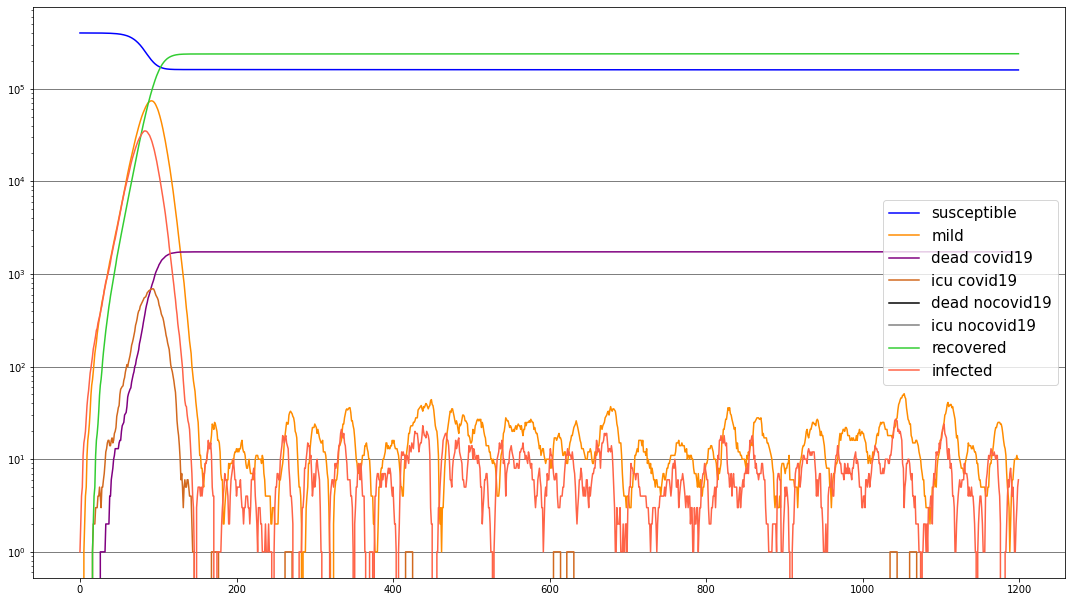

In [106]:
N=1
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
for state in data:
    plt.plot(np.arange(len(moving_avg(data[state],N))), moving_avg(data[state],N),
                label=state,color=colorplot(state)) 
    plt.legend(fontsize=15)
    plt.yscale("log")
    plt.grid(color='black',axis='y' ,which='major',linestyle='-', linewidth=0.5)

In [140]:
seed="0"
p1="0.0"
length_arr_cro = np.zeros((21,21))
for p2 in series[p1].keys():
    for p1 in series.keys():
        a=min([idx for idx, element in enumerate(series[p1][p2][seed]['dead']) if element>0.95*series[p1][p2][seed]['dead'][-1]])
        print("(p1,p2) = ({},{}) : {}".format(p1,p2,a))
        length_arr_cro[int(float(p2)*20)][int(float(p1)*20)]=a

(p1,p2) = (0.0,0.0) : 1129
(p1,p2) = (0.05,0.0) : 1003
(p1,p2) = (0.1,0.0) : 1170
(p1,p2) = (0.15000000000000002,0.0) : 1056
(p1,p2) = (0.2,0.0) : 1177
(p1,p2) = (0.25,0.0) : 1179
(p1,p2) = (0.30000000000000004,0.0) : 1190
(p1,p2) = (0.35000000000000003,0.0) : 1102
(p1,p2) = (0.4,0.0) : 1144
(p1,p2) = (0.45,0.0) : 1102
(p1,p2) = (0.5,0.0) : 1134
(p1,p2) = (0.55,0.0) : 1117
(p1,p2) = (0.6000000000000001,0.0) : 1130
(p1,p2) = (0.65,0.0) : 1121
(p1,p2) = (0.7000000000000001,0.0) : 1021
(p1,p2) = (0.75,0.0) : 458
(p1,p2) = (0.8,0.0) : 143
(p1,p2) = (0.8500000000000001,0.0) : 121
(p1,p2) = (0.9,0.0) : 104
(p1,p2) = (0.9500000000000001,0.0) : 98
(p1,p2) = (1.0,0.0) : 88
(p1,p2) = (0.0,0.05) : 888
(p1,p2) = (0.05,0.05) : 1199
(p1,p2) = (0.1,0.05) : 1196
(p1,p2) = (0.15000000000000002,0.05) : 1194
(p1,p2) = (0.2,0.05) : 1127
(p1,p2) = (0.25,0.05) : 1147
(p1,p2) = (0.30000000000000004,0.05) : 1091
(p1,p2) = (0.35000000000000003,0.05) : 1075
(p1,p2) = (0.4,0.05) : 1149
(p1,p2) = (0.45,0.05) : 95

(p1,p2) = (0.8,0.7000000000000001) : 95
(p1,p2) = (0.8500000000000001,0.7000000000000001) : 86
(p1,p2) = (0.9,0.7000000000000001) : 81
(p1,p2) = (0.9500000000000001,0.7000000000000001) : 76
(p1,p2) = (1.0,0.7000000000000001) : 72
(p1,p2) = (0.0,0.75) : 989
(p1,p2) = (0.05,0.75) : 828
(p1,p2) = (0.1,0.75) : 1115
(p1,p2) = (0.15000000000000002,0.75) : 991
(p1,p2) = (0.2,0.75) : 1108
(p1,p2) = (0.25,0.75) : 1113
(p1,p2) = (0.30000000000000004,0.75) : 1173
(p1,p2) = (0.35000000000000003,0.75) : 1126
(p1,p2) = (0.4,0.75) : 1152
(p1,p2) = (0.45,0.75) : 1129
(p1,p2) = (0.5,0.75) : 956
(p1,p2) = (0.55,0.75) : 404
(p1,p2) = (0.6000000000000001,0.75) : 168
(p1,p2) = (0.65,0.75) : 131
(p1,p2) = (0.7000000000000001,0.75) : 114
(p1,p2) = (0.75,0.75) : 98
(p1,p2) = (0.8,0.75) : 93
(p1,p2) = (0.8500000000000001,0.75) : 85
(p1,p2) = (0.9,0.75) : 77
(p1,p2) = (0.9500000000000001,0.75) : 76
(p1,p2) = (1.0,0.75) : 71
(p1,p2) = (0.0,0.8) : 1133
(p1,p2) = (0.05,0.8) : 1099
(p1,p2) = (0.1,0.8) : 1042
(p1,p2

In [122]:
p1="0.0"
p2="0.0"
seed="0"
min([idx for idx, element in enumerate(series[p1][p2][seed]['dead']) if element>0.95*series[p1][p2][seed]['dead'][-1]])

1129

In [130]:
array = np.zeros((len(cluster_dict[res].keys()), len(cluster_dict[res][0].keys())))
array[int(p2*20)][int(p1*20)]=toadd

40.0

In [143]:
arr/length_arr_cro

array([[1.77147919e-02, 2.99102692e-02, 3.41880342e-02, 1.89393939e-02,
        2.54885302e-02, 1.69635284e-02, 1.68067227e-02, 3.62976407e-02,
        4.37062937e-02, 3.62976407e-02, 3.52733686e-02, 5.37153089e-02,
        5.30973451e-02, 1.33809099e-01, 3.42801175e-01, 2.99126638e+00,
        2.20979021e+01, 4.29752066e+01, 7.28846154e+01, 9.48979592e+01,
        1.31022727e+02],
       [2.25225225e-02, 1.66805671e-02, 1.67224080e-02, 1.67504188e-02,
        2.66193434e-02, 3.48735833e-02, 2.74977085e-02, 2.79069767e-02,
        3.48128808e-02, 4.17972832e-02, 4.75285171e-02, 6.39269406e-02,
        6.86106346e-02, 1.70403587e-01, 5.45094153e-01, 5.71428571e+00,
        2.87407407e+01, 5.17647059e+01, 8.16831683e+01, 1.15157895e+02,
        1.54823529e+02],
       [1.83318057e-02, 2.79589935e-02, 2.85442436e-02, 2.55319149e-02,
        2.70270270e-02, 2.55536627e-02, 3.86100386e-02, 2.84900285e-02,
        2.77008310e-02, 3.64298725e-02, 5.25854514e-02, 4.24808836e-02,
        1.0507

# R0 SIMULATIONS

In [162]:
from random import random
it=10000
r=0.1
days=15
duljina=np.zeros(it)
duljina1=np.zeros(it)
br_susjeda=3
vel_grozda=br_susjeda+1

p1_trip=1
k_trip=2.5

for k in range(it):
    grozd=np.zeros(br_susjeda)
    for j in range(0,days):
        for i in range(0,len(grozd)):
            if grozd[i]==0:
                grozd[i]=int(random()<=r)
            else:
                continue
    duljina[k]=np.sum(grozd)/len(grozd)
    duljina1[k]=np.sum(grozd)
    
print("velicina grozda = ",vel_grozda, "\nbroj susjeda = ",br_susjeda,
      "\nomjer zarazenih susjeda = ",np.mean(duljina), "\nbroj zarazenih susjeda = ",np.mean(duljina1),
     "\nR0 = ", p1_trip*days*k_trip/10 + np.mean(duljina1))

velicina grozda =  4 
broj susjeda =  3 
omjer zarazenih susjeda =  0.7926333333333332 
broj zarazenih susjeda =  2.3779 
R0 =  9.8779


In [25]:
vel_grozda=4
dana_bolestan=np.zeros(vel_grozda)
dana_bolestan[vel_grozda-1]=5
dana_bolestan[0]=5
for i1 in range(int(np.sum(dana_bolestan>0))):
    print(i1)

0
1


In [56]:
import numpy as np
from random import random

def R0simul(k_trip,vel_grozda,v):
    it=10000
    r=0.1
    days=16
    duljina=np.zeros(it)
    br_susjeda=vel_grozda - 1

    broj_izlazaka_p=np.zeros(it)
    p1_trip=1
    p2_trip=0.5
    #k_trip=5

    # simuliramo odkad je 1 (i samo 1) infectious u grozdu. 
    # simulacija traje days dana sto je broj dana inkubacije. Nakon toga dolazi karantena i ne gledamo.
    for k in range(it):
        grozd=np.zeros(vel_grozda) # svi u grozdu susceptible
        grozd[vel_grozda-1]=1 # ubacimo jednog bolesnika na pocetku
        
        dana_bolestan=np.zeros(vel_grozda)
        dana_bolestan[vel_grozda-1]=5
        for j in range(0,days):
            pomocni=grozd # uvedemo pomocni da se ne dogodi a-b, b-c u istom danu.
            for i in range(0,len(pomocni)): # idemo po svim susjedima prvog oboljelog
                if pomocni[i]==0: # ako je vrh susceptible ...
                    for i1 in range(int(np.sum(dana_bolestan>0))): # svaki bolesnik u grozdu
                        pomocni[i]+=int(random()<=r) # susceptible vrh ima sansu r da se zarazi (racunato za svakog bolesnog susjeda posebno)
                    pomocni[i]=min(1,pomocni[i]) # stavljamo novooboljele na vrijednost 1 a susceptible ostavimo na 0.
                    dana_bolestan[i]=5*min(1,pomocni[i])
                    if pomocni[i]==1: # svim vrhovima koji su se zarazili u ovoj iteraciji racunamo koliko dana izlaze.
                        if v=="version1":
                            broj_izlazaka_p[k]=k_trip*r*p1_trip*(broj_izlazaka_p[k]+days-j)
                        if v=="version2":
                            if j<=5: # nakon toga slijedi karantena za grozd p2.
                                broj_izlazaka_p[k]=k_trip*r*p1_trip*(broj_izlazaka_p[k]+5-j)+k_trip*r*p1_trip*p2_trip*(broj_izlazaka_p[k]+j)
                                # unutar prvih 5 dana djeluje samo p1, kasnije p1*p2.
                            else:
                                broj_izlazaka_p[k]=k_trip*r*p1_trip*p2_trip*(broj_izlazaka_p[k]+min(5,days-j))
                else:
                    dana_bolestan[i]-=1
                    continue
            grozd=pomocni
            
        if v=="version1":
            broj_izlazaka_p[k]=p1_trip*(broj_izlazaka_p[k]+days) # prvi bolesnik u grozdu ce putovati "days" dana.
        if v=="version2":
            broj_izlazaka_p[k]=p1_trip*(broj_izlazaka_p[k]+5) # prvi bolesnik u grozdu ce putovati 5 dana.
            
        duljina[k]=np.sum(grozd)-1 # novozarazeni u grozdu bez onog prvog

    broj_zarazenih_susjeda=np.mean(duljina) 
    broj_zarazenih_na_putovanju=np.mean(broj_izlazaka_p)
    ukupan_broj_zarazenih=broj_zarazenih_susjeda+broj_zarazenih_na_putovanju
    R0=ukupan_broj_zarazenih/vel_grozda

    print("velicina grozda = ",vel_grozda, "\nbroj susjeda = ",br_susjeda,
          "\nprosjecan broj zarazenih susjeda = ",broj_zarazenih_susjeda,
          "\nbroj zarazenih na putovanjima = ", broj_zarazenih_na_putovanju,
         "\nUkupan broj zarazenih od grozdovih sudionika dok se grozd ne karantira = ",ukupan_broj_zarazenih,
         "\nR0 = ", R0,
         "\nUpperBound R0 = ", br_susjeda*r*5+r*k_trip*p1_trip*5)
    return R0

In [57]:
v="version2"
k_trip=5
velicina_grozda=9
R0simul(k_trip,velicina_grozda,v)

velicina grozda =  9 
broj susjeda =  8 
prosjecan broj zarazenih susjeda =  7.7343 
broj zarazenih na putovanjima =  9.993500833129882 
Ukupan broj zarazenih od grozdovih sudionika dok se grozd ne karantira =  17.727800833129884 
R0 =  1.9697556481255427 
UpperBound R0 =  6.5


1.9697556481255427

In [53]:
v="version2"
k_R0=[]
for cluster in np.arange(2,10,1):
    for k in np.arange(0,5.1,0.5):
        print("\nCluster = {}, k = {}\n".format(cluster,k))
        k_R0.append((k,R0simul(k,int(cluster),v),int(cluster)))


Cluster = 2, k = 0.0

velicina grozda =  2 
broj susjeda =  1 
prosjecan broj zarazenih susjeda =  0.3475 
broj zarazenih na putovanjima =  0.0 
Ukupan broj zarazenih od grozdovih sudionika dok se grozd ne karantira =  0.3475 
R0 =  0.17375

Cluster = 2, k = 0.5

velicina grozda =  2 
broj susjeda =  1 
prosjecan broj zarazenih susjeda =  0.3385 
broj zarazenih na putovanjima =  0.75719625 
Ukupan broj zarazenih od grozdovih sudionika dok se grozd ne karantira =  1.09569625 
R0 =  0.547848125

Cluster = 2, k = 1.0

velicina grozda =  2 
broj susjeda =  1 
prosjecan broj zarazenih susjeda =  0.3469 
broj zarazenih na putovanjima =  1.5264075000000001 
Ukupan broj zarazenih od grozdovih sudionika dok se grozd ne karantira =  1.8733075000000001 
R0 =  0.9366537500000001

Cluster = 2, k = 1.5

velicina grozda =  2 
broj susjeda =  1 
prosjecan broj zarazenih susjeda =  0.3429 
broj zarazenih na putovanjima =  2.28310875 
Ukupan broj zarazenih od grozdovih sudionika dok se grozd ne karanti

velicina grozda =  4 
broj susjeda =  3 
prosjecan broj zarazenih susjeda =  1.6321 
broj zarazenih na putovanjima =  16.920073125000002 
Ukupan broj zarazenih od grozdovih sudionika dok se grozd ne karantira =  18.552173125000003 
R0 =  4.638043281250001

Cluster = 4, k = 5.0

velicina grozda =  4 
broj susjeda =  3 
prosjecan broj zarazenih susjeda =  1.6266 
broj zarazenih na putovanjima =  18.787903125 
Ukupan broj zarazenih od grozdovih sudionika dok se grozd ne karantira =  20.414503125 
R0 =  5.10362578125

Cluster = 5, k = 0.0

velicina grozda =  5 
broj susjeda =  4 
prosjecan broj zarazenih susjeda =  2.6568 
broj zarazenih na putovanjima =  0.0 
Ukupan broj zarazenih od grozdovih sudionika dok se grozd ne karantira =  2.6568 
R0 =  0.53136

Cluster = 5, k = 0.5

velicina grozda =  5 
broj susjeda =  4 
prosjecan broj zarazenih susjeda =  2.6508 
broj zarazenih na putovanjima =  3.08055375 
Ukupan broj zarazenih od grozdovih sudionika dok se grozd ne karantira =  5.73135375 


velicina grozda =  7 
broj susjeda =  6 
prosjecan broj zarazenih susjeda =  5.0987 
broj zarazenih na putovanjima =  58.3643508984375 
Ukupan broj zarazenih od grozdovih sudionika dok se grozd ne karantira =  63.4630508984375 
R0 =  9.066150128348214

Cluster = 7, k = 4.0

velicina grozda =  7 
broj susjeda =  6 
prosjecan broj zarazenih susjeda =  5.066 
broj zarazenih na putovanjima =  65.1621496875 
Ukupan broj zarazenih od grozdovih sudionika dok se grozd ne karantira =  70.22814968750001 
R0 =  10.0325928125

Cluster = 7, k = 4.5

velicina grozda =  7 
broj susjeda =  6 
prosjecan broj zarazenih susjeda =  5.0777 
broj zarazenih na putovanjima =  73.2726769921875 
Ukupan broj zarazenih od grozdovih sudionika dok se grozd ne karantira =  78.3503769921875 
R0 =  11.19291099888393

Cluster = 7, k = 5.0

velicina grozda =  7 
broj susjeda =  6 
prosjecan broj zarazenih susjeda =  5.0499 
broj zarazenih na putovanjima =  81.88931835937501 
Ukupan broj zarazenih od grozdovih sudionika 

In [64]:
pd.set_option('display.max_rows', 320)
R0frame = pd.DataFrame(k_R0, columns = ['K_trip' , 'R0', 'Cluster_size'])
columns_titles = ['Cluster_size','K_trip','R0']
R0frame=R0frame.reindex(columns=columns_titles)
R0frame

,Cluster_size,K_trip,R0
0,2,0.0,0.173750
1,2,0.5,0.547848
2,2,1.0,0.936654
3,2,1.5,1.313004
4,2,2.0,1.698107
5,2,2.5,2.052291
6,2,3.0,2.450416
7,2,3.5,2.838829
8,2,4.0,3.210815
9,2,4.5,3.563692


In [66]:
## 2.2-2.7
left=[2.47,6.31,2.32,2.28,2.39,2,1.4,1.96,2.89,1.5,5.71,1.4]
right=[2.86,6.66,3.63,3.67,4.13,3.1,2.5,2.55,4.39,3.5,7.23,3.9]
R0range=[np.mean(left), np.mean(right)]
print(R0range)
R0frame_imp = R0frame[(R0frame['R0'] >= R0range[0]) & (R0frame['R0'] <= R0range[1])]
R0frame_imp

[2.7191666666666667, 4.01]


,Cluster_size,K_trip,R0
7,2,3.5,2.838829
8,2,4.0,3.210815
9,2,4.5,3.563692
10,2,5.0,3.957731
18,3,3.5,3.044742
19,3,4.0,3.415233
20,3,4.5,3.857706
27,4,2.5,2.770035
28,4,3.0,3.231021
29,4,3.5,3.731727


In [237]:
ktrp=2.5
R0frame_imp = R0frame[(R0frame['K_trip'] >= ktrp) & (R0frame['K_trip'] <= ktrp)]
print(np.mean(R0frame_imp["R0"]))
R0frame_imp

NameError: name 'R0frame' is not defined

# FAT TAILS TESTING

In [88]:
#FAT TAILS TEST
def maximum_to_sum(results,p):
    snp=0
    np=0
    mnp=0
    max_to_sum_p=[]
    for dead in results:
        np = max(np,dead)
        snp = snp + pow(dead,p)
        mnp=pow(np,p)
        max_to_sum_p.append(mnp/snp)
    return max_to_sum_p
def emexcess(results,u):
    suma=0
    count=0
    for dead in results:
        suma=suma+max(dead-u,0)
        if dead>u:
            count=count+1
            
    return suma/count
    

In [89]:
with open('out2.json') as json_file:
    results = json.load(json_file)

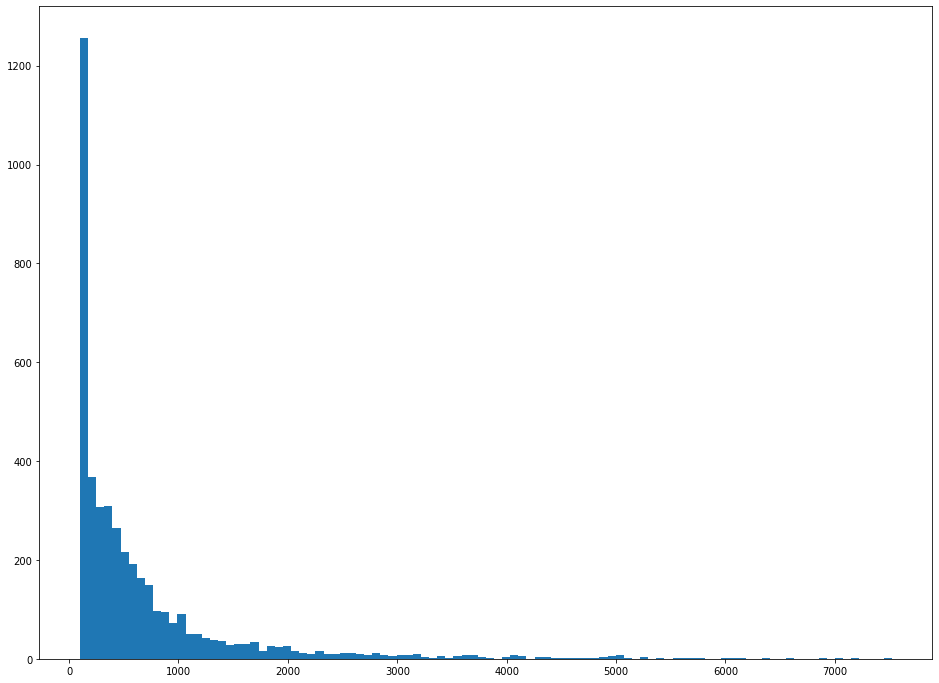

In [93]:
figure = plt.gcf() # get current figure
figure.set_size_inches(16, 12)
results_trunc_hist=[i for i in results['dead'] if i >= 100]
plt.hist(results_trunc_hist  ,bins=100)
plt.show()

In [95]:
results_trunc_hist=[i for i in results['dead'] if i >= 1000]
#results_trunc_hist=results_trunc_hist[0:200]
results_trunc_hist=np.random.permutation(results_trunc_hist)
print("Prosjek:",np.mean(results_trunc_hist))
print("Medijan:",np.median(results_trunc_hist))
print("Std:",np.std(results_trunc_hist))
print("Duljina:",len(results_trunc_hist))
print("Maks:",max(results_trunc_hist))

Prosjek: 2067.4760051880676
Medijan: 1666.0
Std: 1162.5376477766983
Duljina: 771
Maks: 7519


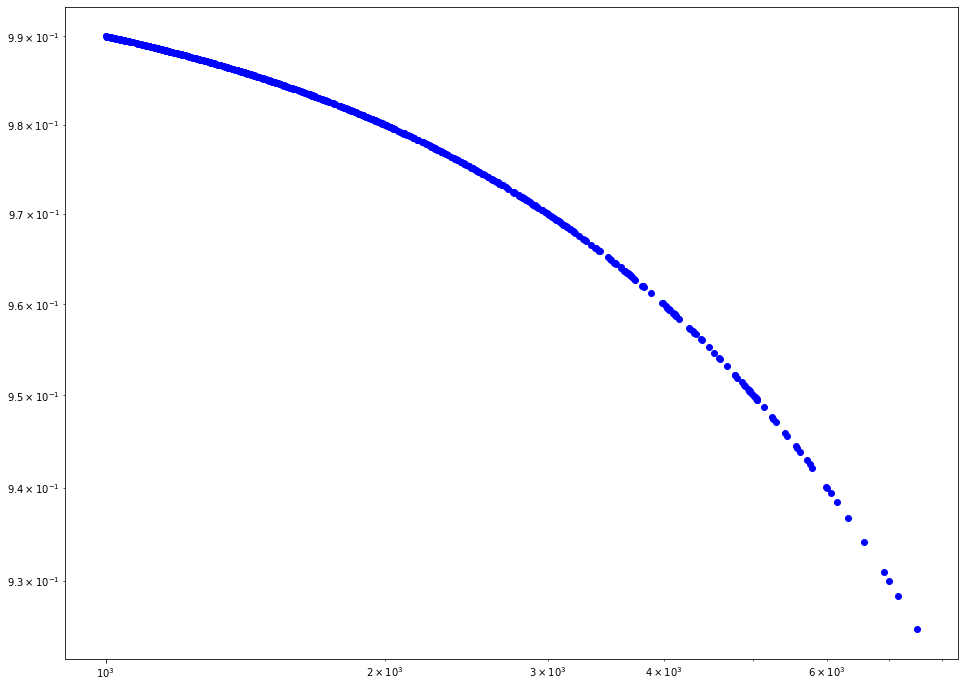

In [22]:
plt.loglog(results_trunc_hist,1-results_trunc_hist/100000,'bo')
figure = plt.gcf() # get current figure
figure.set_size_inches(16, 12)

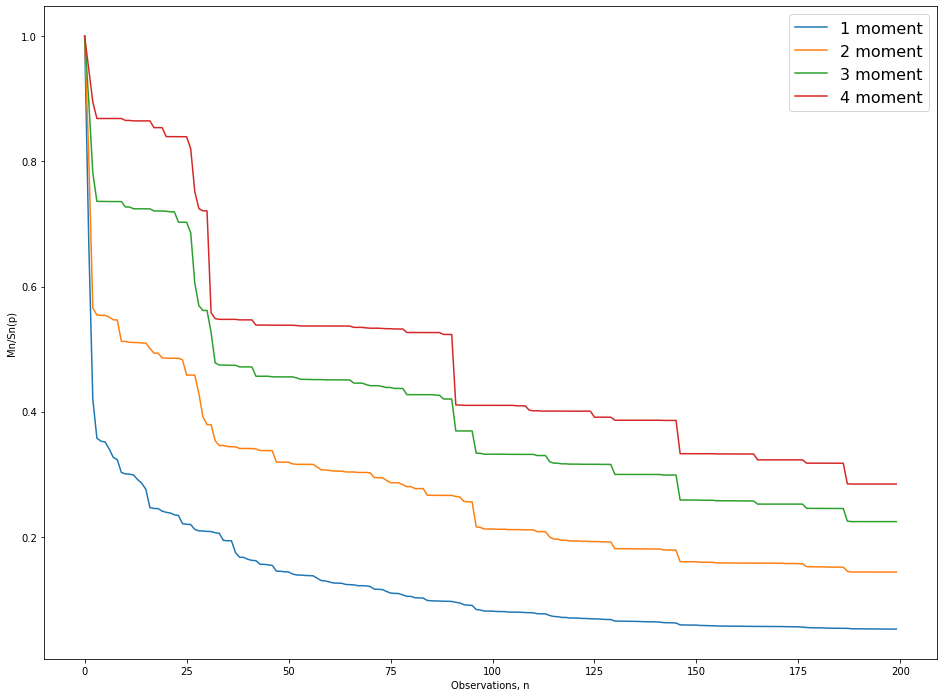

In [106]:
#np.random.seed(80) ovaj dobar
results_trunc=[i for i in results['dead'] if i >= 0]
results_trunc1=np.random.permutation(results_trunc[0:200])
lista=maximum_to_sum(results_trunc1,1)

p_list=[1,2,3,4]
for p in p_list:
    lista=maximum_to_sum(results_trunc1,p)
    lista.sort(reverse=True)
    plt.plot(np.arange(len(lista)),lista,label=(str(p)+" moment"))
    
plt.legend(prop={'size': 16})
plt.xlabel('Observations, n')
plt.ylabel('Mn/Sn(p)')

figure = plt.gcf() # get current figure
figure.set_size_inches(16, 12)


<ipython-input-200-42ce985f8226>:21: RuntimeWarning: invalid value encountered in long_scalars
  return suma/count


ZeroDivisionError: division by zero

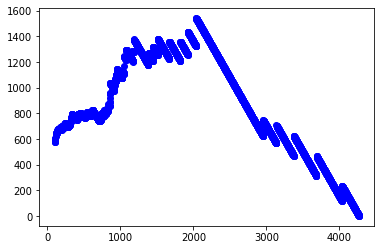

In [213]:
u_list=list(range(1, 7500))
for u in u_list:
    broj=emexcess(results_trunc1,u)
    plt.plot(u,broj,'bo')
figure = plt.gcf() # get current figure
figure.set_size_inches(16, 12)